# Dataset Exploration
This notebook serves to dive deeper into the properties of our data.

In [2]:
from pathlib import Path
import sys
sys.path.append('..') # add the parent directory to system path

%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import torch
from src.data.dataset import CnvDataset, CnvMemoryDataset

In [3]:
from plotnine import *

In [4]:
# directories we will need
git_root = Path('..')
data_root = git_root / 'data'
assert data_root.exists()
out_root = git_root / 'out'
plot_root = out_root / 'plots'
assert plot_root.is_dir()

# dataset split files
b1_train_path = data_root / 'splits' / 'batch1_training_filtered.tsv'
b1_val_path = data_root / 'splits' / 'batch1_val_filtered.tsv'
b1_test_path = data_root / 'splits' / 'batch1_test_filtered.tsv'
b2_train_path = data_root / 'splits' / 'batch2_training_filtered.tsv'
b2_val_path = data_root / 'splits' / 'batch2_val_filtered.tsv'
b2_test_path = data_root / 'splits' / 'batch2_test_filtered.tsv'

In [6]:
b1_full_data = data_root / 'preprocessing' / 'classification_median_batch_1.tsv'
b2_full_data = data_root / 'preprocessing' / 'classification_median_batch_2.tsv'

## Raw Data
This section explores the raw data. 

### scATAC-seq
Visualization of the raw scATAC-seq matrix from `.h5` file.

In [16]:
atac_raw_path = data_root / 'raw' / 'H_Kidney_Cancer_Chromium_Nuc_Iso_vs_SaltyEZ_vs_ComplexTissueDP_filtered_feature_bc_matrix.h5'

## Preprocessed Data
Visualizations on the preprocessed data.

### scATAC-seq
One of the inputs to our model are scATAc-seq peaks to inform about open chromatin regions in the genome.
Here we explore the distributions of peaks in this dataset.
The atac peaks are preprocessed and collected in a `.tsv` file by `match_peaks_genes.ipynb`.

In [7]:
atac_b1_path = data_root / 'gene_positions_and_overlaps' / 'overlaps_batch1.tsv'
atac_b2_path = data_root / 'gene_positions_and_overlaps' / 'overlaps_batch1.tsv'

In [8]:
atac_b1_df = pd.read_csv(atac_b1_path, sep='\t')
atac_b1_df

barcode Chromosome  Start_peak   End_peak          gene_id  \
0      AAACCAACATGTCAGC-1          1    47997167   47998016  ENSG00000269113   
1      AAACCGAAGGCGCATC-1          1    97920596   97921519  ENSG00000188641   
2      AAACCGAAGTAAACCC-1          1    66543200   66543959  ENSG00000118473   
3      AAACCGAAGTAAACCC-1          1    66648772   66649635  ENSG00000118473   
4      AAACCGAAGTAAACCC-1          1   171606177  171607044  ENSG00000283683   
...                   ...        ...         ...        ...              ...   
55150  TTTAGGATCGTTATCT-1          X   109732881  109733753  ENSG00000068366   
55151  TTTGTTGGTGCCGCAA-1          X    17405116   17405991  ENSG00000188158   
55152  TTTGTTGGTGCCGCAA-1          X    17526978   17527816  ENSG00000188158   
55153  TTTGTTGGTGCCGCAA-1          X    17566915   17567797  ENSG00000188158   
55154  TTTGTTGGTGCCGCAA-1          X    17580433   17581347  ENSG00000188158   

       Start_gene   End_gene  
0        47758528   47999385  
1        97075743   97997000  
2        66531267   66753139  
3        66531267   66753139  
4       171598621  171640799  
...           ...        ...  
55150   109622244  109735403  
55151    17373200   17737994  
55152    17373200   17737994  
55153    17373200   17737994  
55154    17373200   17737994  

[55155 rows x 7 columns]

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 39'. Pick better value with 'binwidth'.


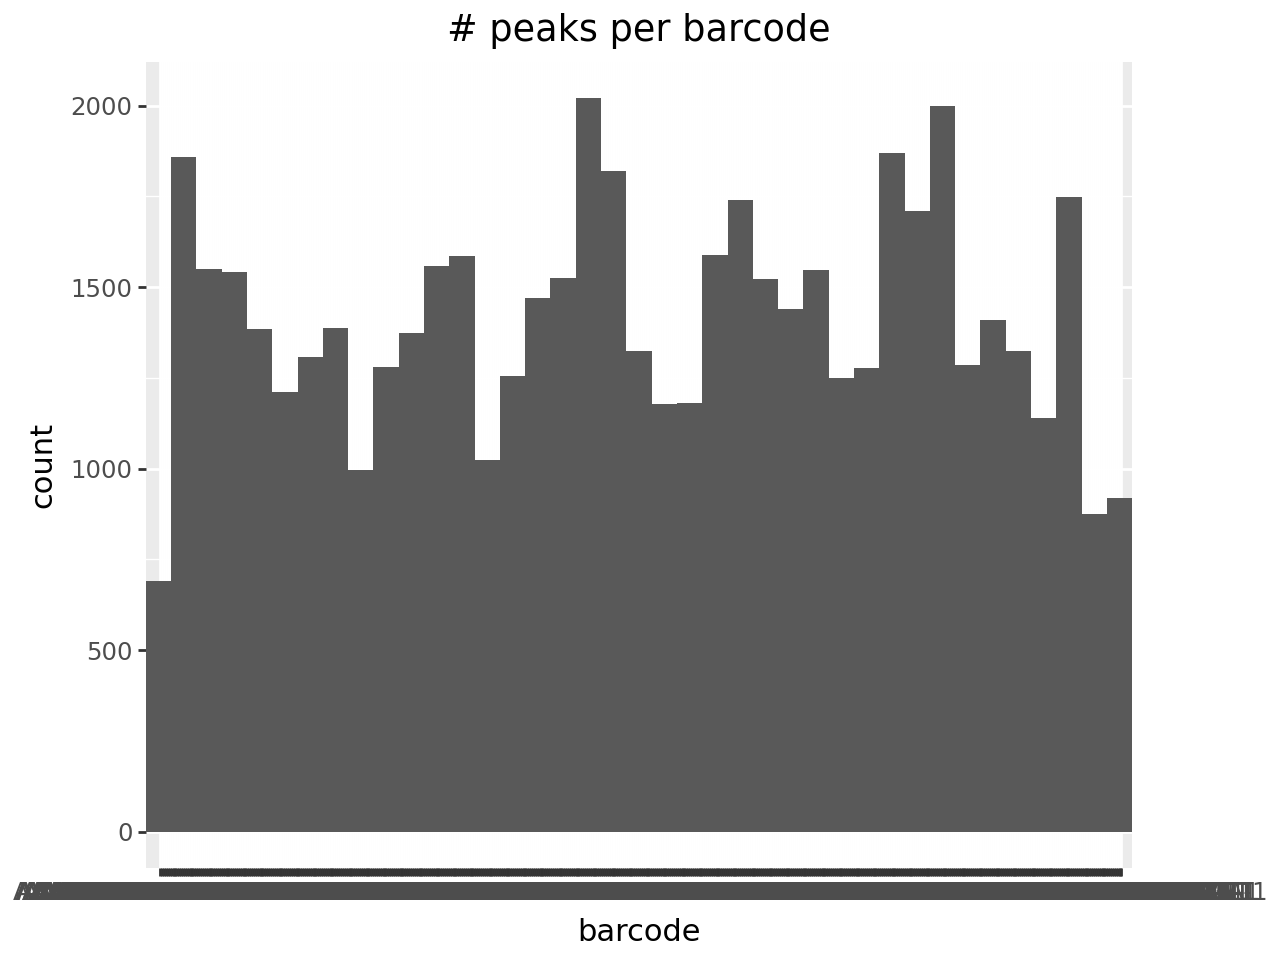

In [9]:
# plot number of peaks per barcode
ggplot(atac_b1_df, aes(x='barcode')) + \
    geom_histogram() + \
    labs(title='# peaks per barcode', x='barcode', y='count')

In [ ]:
# calculate peak size
atac_b1_df['peak_length'] = atac_b1_df['End_peak'] - atac_b1_df['Start_peak']

# calculate overlap size between gene and peak
# TODO: calculate with pyranges
# check cases where Start gene > End peak
atac_b1_df['overlap_length'] = atac_b1_df['End_peak'] - atac_b1_df['Start_gene']

In [11]:
atac_b1_df

barcode Chromosome  Start_peak   End_peak          gene_id  \
0      AAACCAACATGTCAGC-1          1    47997167   47998016  ENSG00000269113   
1      AAACCGAAGGCGCATC-1          1    97920596   97921519  ENSG00000188641   
2      AAACCGAAGTAAACCC-1          1    66543200   66543959  ENSG00000118473   
3      AAACCGAAGTAAACCC-1          1    66648772   66649635  ENSG00000118473   
4      AAACCGAAGTAAACCC-1          1   171606177  171607044  ENSG00000283683   
...                   ...        ...         ...        ...              ...   
55150  TTTAGGATCGTTATCT-1          X   109732881  109733753  ENSG00000068366   
55151  TTTGTTGGTGCCGCAA-1          X    17405116   17405991  ENSG00000188158   
55152  TTTGTTGGTGCCGCAA-1          X    17526978   17527816  ENSG00000188158   
55153  TTTGTTGGTGCCGCAA-1          X    17566915   17567797  ENSG00000188158   
55154  TTTGTTGGTGCCGCAA-1          X    17580433   17581347  ENSG00000188158   

       Start_gene   End_gene  peak_length  overlap_length  
0        47758528   47999385          849          239488  
1        97075743   97997000          923          845776  
2        66531267   66753139          759           12692  
3        66531267   66753139          863          118368  
4       171598621  171640799          867            8423  
...           ...        ...          ...             ...  
55150   109622244  109735403          872          111509  
55151    17373200   17737994          875           32791  
55152    17373200   17737994          838          154616  
55153    17373200   17737994          882          194597  
55154    17373200   17737994          914          208147  

[55155 rows x 9 columns]

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 205'. Pick better value with 'binwidth'.


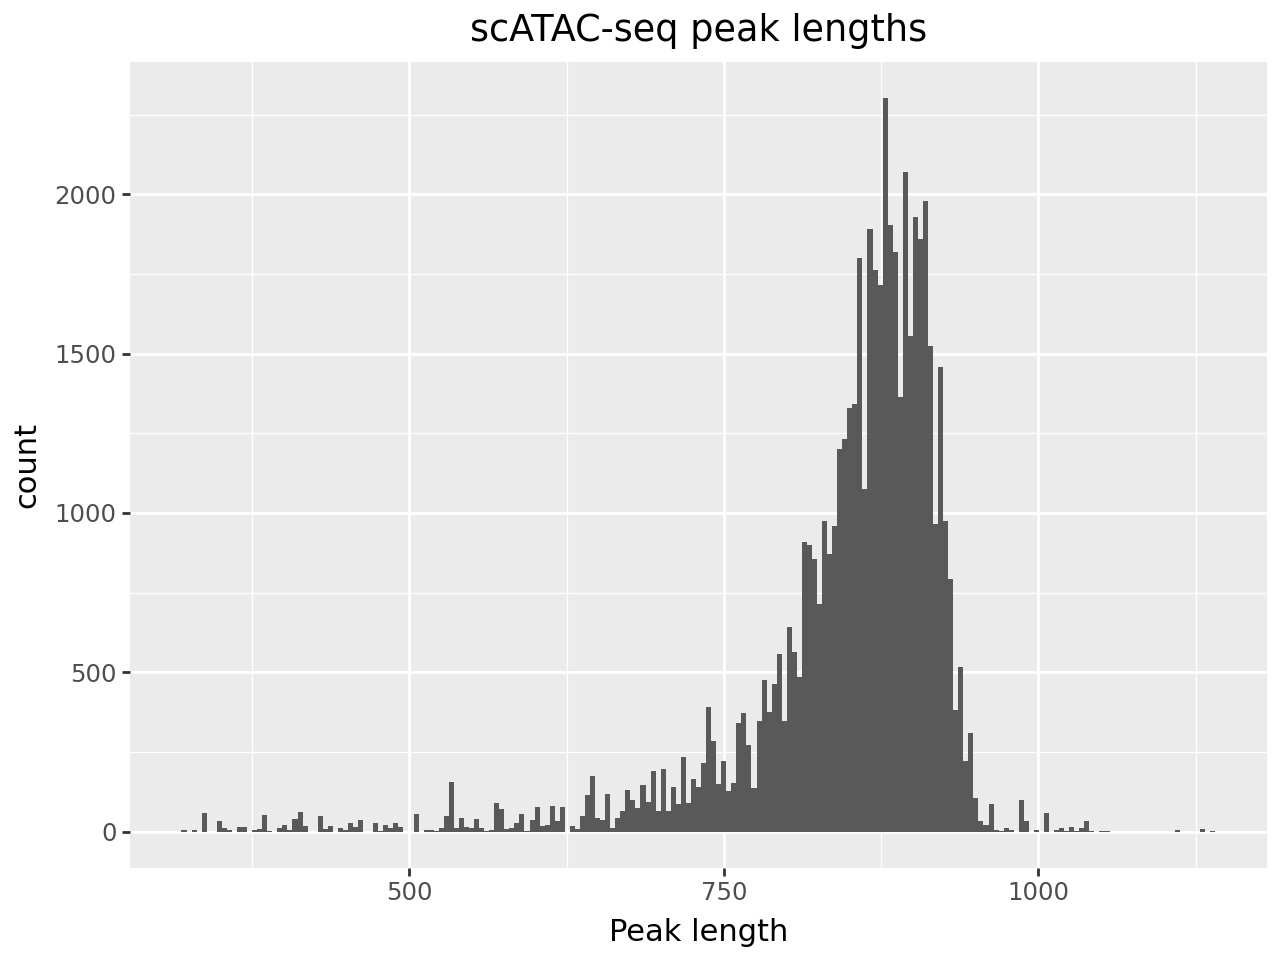

In [12]:
ggplot(atac_b1_df, aes(x='peak_length')) + \
    geom_histogram() + \
    labs(title='scATAC-seq peak lengths', x='Peak length', y='count')

This distribution of peak length is expected.
So there should be no embedding that has open chromatin signal over the full length.

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 166'. Pick better value with 'binwidth'.


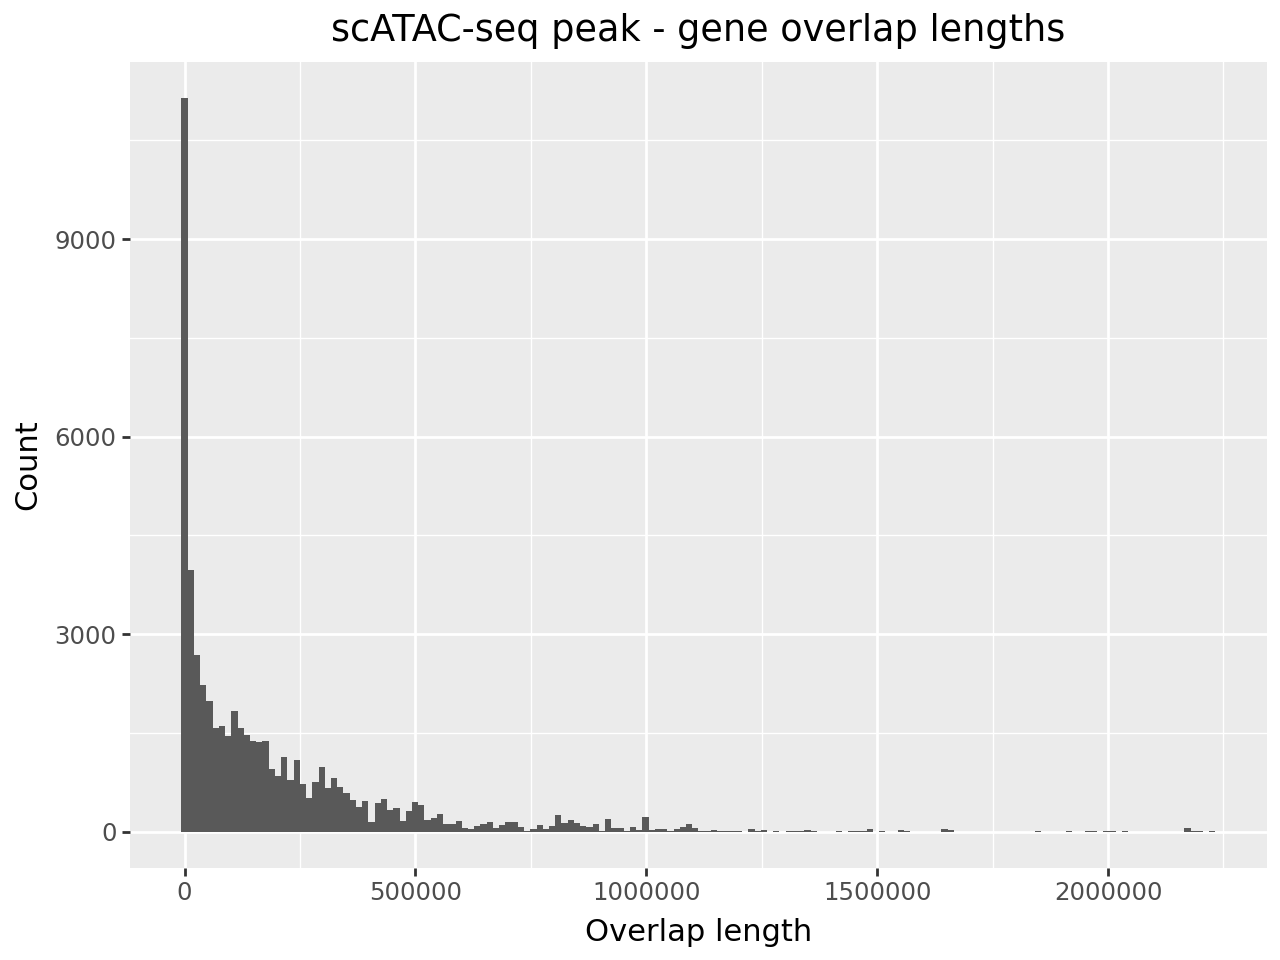

In [13]:
ggplot(atac_b1_df, aes(x='overlap_length')) + \
    geom_histogram() + \
    labs(title='scATAC-seq peak - gene overlap lengths', x='Overlap length', y='Count')

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 111'. Pick better value with 'binwidth'.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 42797 rows containing non-finite values.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


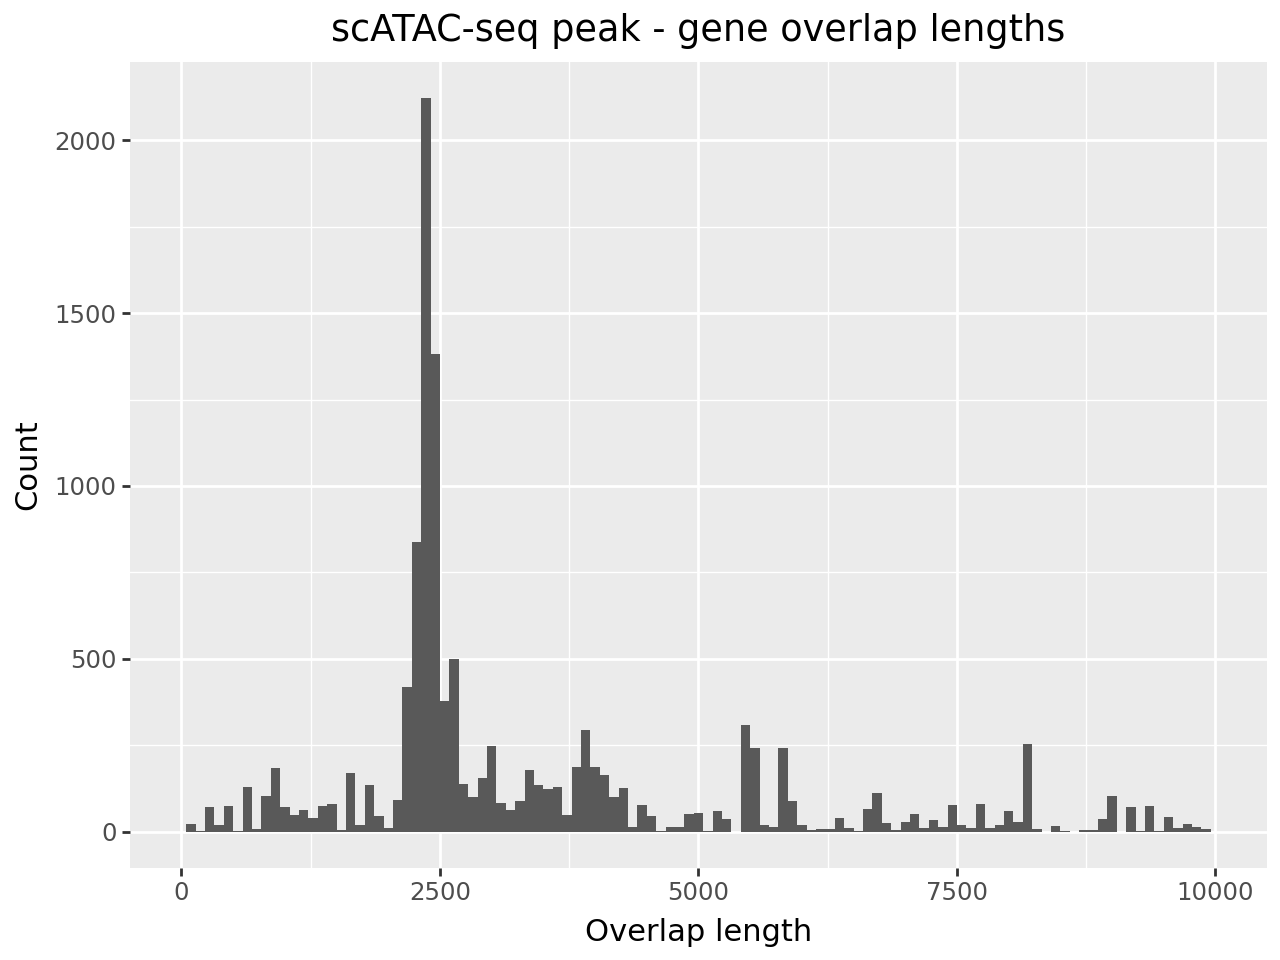

In [15]:
ggplot(atac_b1_df, aes(x='overlap_length')) + \
    geom_histogram() + xlim(0, 10_000) + \
    labs(title='scATAC-seq peak - gene overlap lengths', x='Overlap length', y='Count')

## Data splits

### Split summary
This subsection summarizes the distribution of ATAC, CNV loss/gain and class distribution per split (e.g. stacked bar plot)

In [9]:
def dataset_dist(dataset: CnvDataset):
    return torch.vstack([torch.hstack([e.sum(axis=1), t]) for e, t in dataset])

In [12]:
def dataset_metadata(dist_tensor: torch.Tensor, emb_length=10_000):
    # list elements: 1. no, 2. some, 3. all positions in embedding show signal
    status_matrix = np.zeros(shape=(6, 3))
    # high_atac = [0] * 3
    # low_atac = [0] * 3
    # high_CNV-_loss, low_CNV-_loss = [0] * 3, [0] * 3
    # high_cnv_gain, low_cnv_gain = [0] * 3, [0] * 3
    # no_atac, some_atac, full_atac = 0, 0, 0
    # no_cnv_loss, some_cnv_loss, full_cnv_loss = 0, 0, 0
    # no_cnv_gain, some_cnv_gain, full_cnv_gain = 0, 0, 0
    for atac, cnv_loss, cnv_gain, target_class in dist_tensor[:,4:]:
        target_class = int(target_class)
        if atac == 0:
            status_matrix[target_class, 0] += 1
        elif atac == emb_length:
            status_matrix[target_class, 2] += 1
        else:
            status_matrix[target_class, 1] += 1

        if cnv_loss == 0:
            status_matrix[(2 + target_class), 0] += 1
        elif cnv_loss == emb_length:
            status_matrix[(2 + target_class), 2] += 1
        else:
            status_matrix[(2 + target_class), 1] += 1

        if cnv_gain == 0:
            status_matrix[(4 + target_class), 0] += 1
        elif cnv_gain == emb_length:
            status_matrix[(4 + target_class), 2] += 1
        else:
            status_matrix[(4 + target_class), 1] += 1
    
    # return dataframe for plotting
    return pd.DataFrame({
        'data': [
            'ATAC', 'ATAC', 'ATAC', 'ATAC', 'ATAC', 'ATAC',
            'CNV-', 'CNV-', 'CNV-', 'CNV-', 'CNV-', 'CNV-',
            'CNV+', 'CNV+', 'CNV+', 'CNV+', 'CNV+', 'CNV+'
            ],
        'classification': ['high', 'high', 'high', 'low', 'low', 'low'] * 3,
        'status': ['none', 'part', 'full'] * 6,
        'value': status_matrix.flatten()
        })
    

In [29]:
def plot_signal_strength(dataset: CnvDataset, batch: int, split: str):
    assert batch in (1, 2), 'No valid batch'
    # assert split in ('train', 'val', 'test'), 'No valid split name'

    dataset_dist_tensor = dataset_dist(dataset)
    dataset_meta_df = dataset_metadata(dataset_dist_tensor)

    class_balance_df = pd.DataFrame(dataset.class_balance())
    class_balance_df['status'] = class_balance_df.index
    class_balance_df['classification'] = 'class balance'
    class_balance_df['data'] = ''
    class_balance_df

    p = ggplot(data=dataset_meta_df, mapping=aes(x='data', y='value')) +\
        geom_col(aes(fill='status'), position='stack') +\
        geom_col(data=class_balance_df, mapping=aes(y='count', fill='status'), position='dodge') +\
        facet_wrap('~classification', scales='free_x') +\
        labs(
            title='Batch {} {} signal summary'.format(batch, split),
            x='Signal type', y='# data points')
    ggsave(p, plot_root / 'dataset' / 'batch{}_{}_signal_summary.png'.format(batch, split))
    p.show()

    return dataset_dist_tensor, dataset_meta_df

In [ ]:
b2_train = CnvDataset(
    root=data_root / 'embeddings' / 'batch_2' / 'train',
    data_df=pd.read_csv(b2_train_path, sep='\t')
)
b2_train

Using 239 barcodes
Using 1217 genes
No embedding files for 2835 data points in ../data/embeddings/batch_2/train/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 20661 datapoints

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch2_train_signal_summary.png


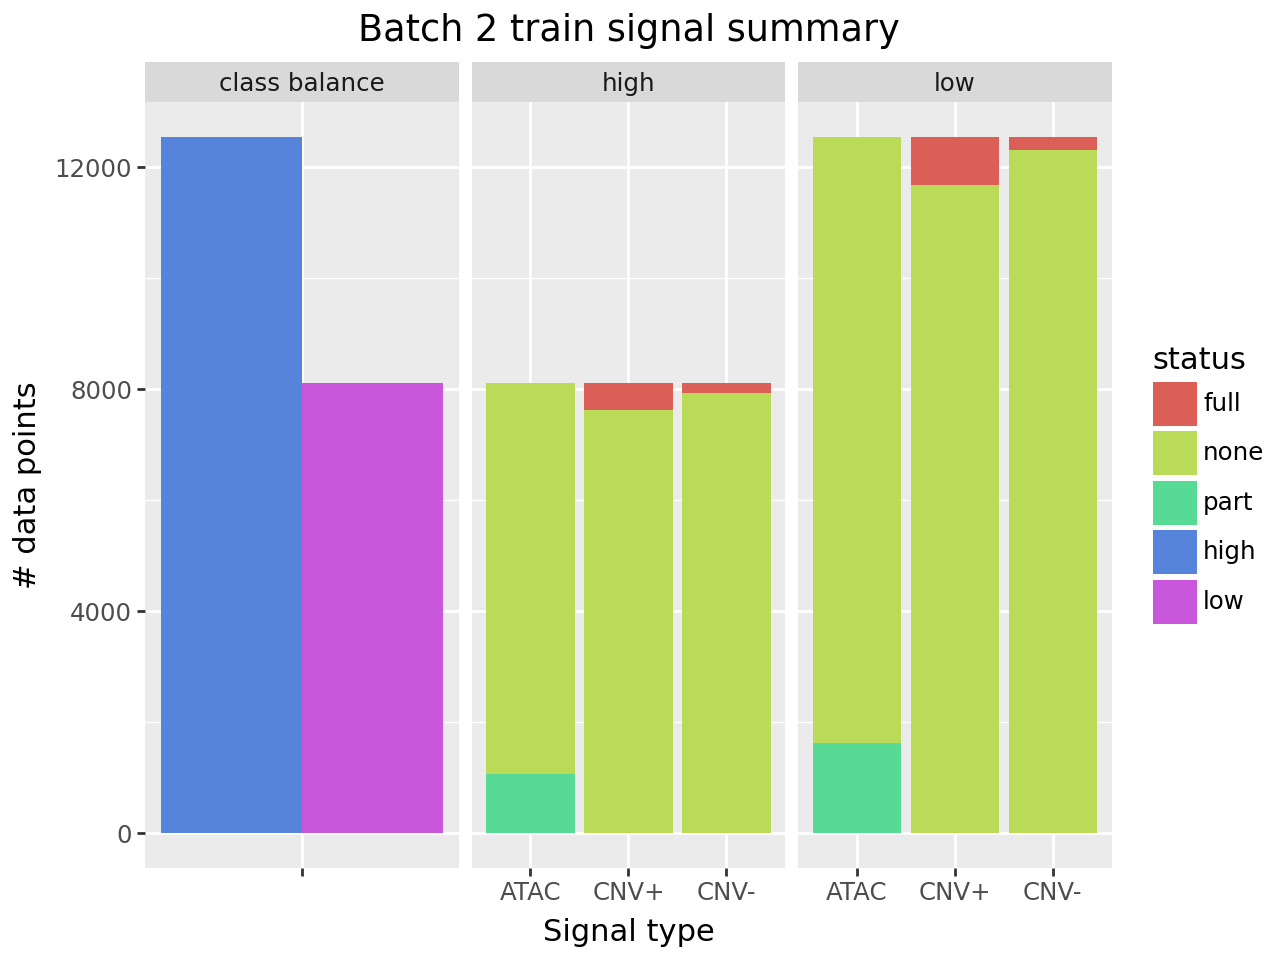

In [28]:
b2_train_dist_t, b2_train_meta_df = plot_signal_strength(b2_train, batch=2, split='train')

In [5]:
b2_val = CnvDataset(
    root=data_root / 'embeddings' / 'batch_2' / 'val',
    data_df=pd.read_csv(b2_val_path, sep='\t')
)
b2_val

Using 35 barcodes
Using 621 genes
No embedding files for 426 data points in ../data/embeddings/batch_2/val/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 3177 datapoints

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch2_val_signal_summary.png


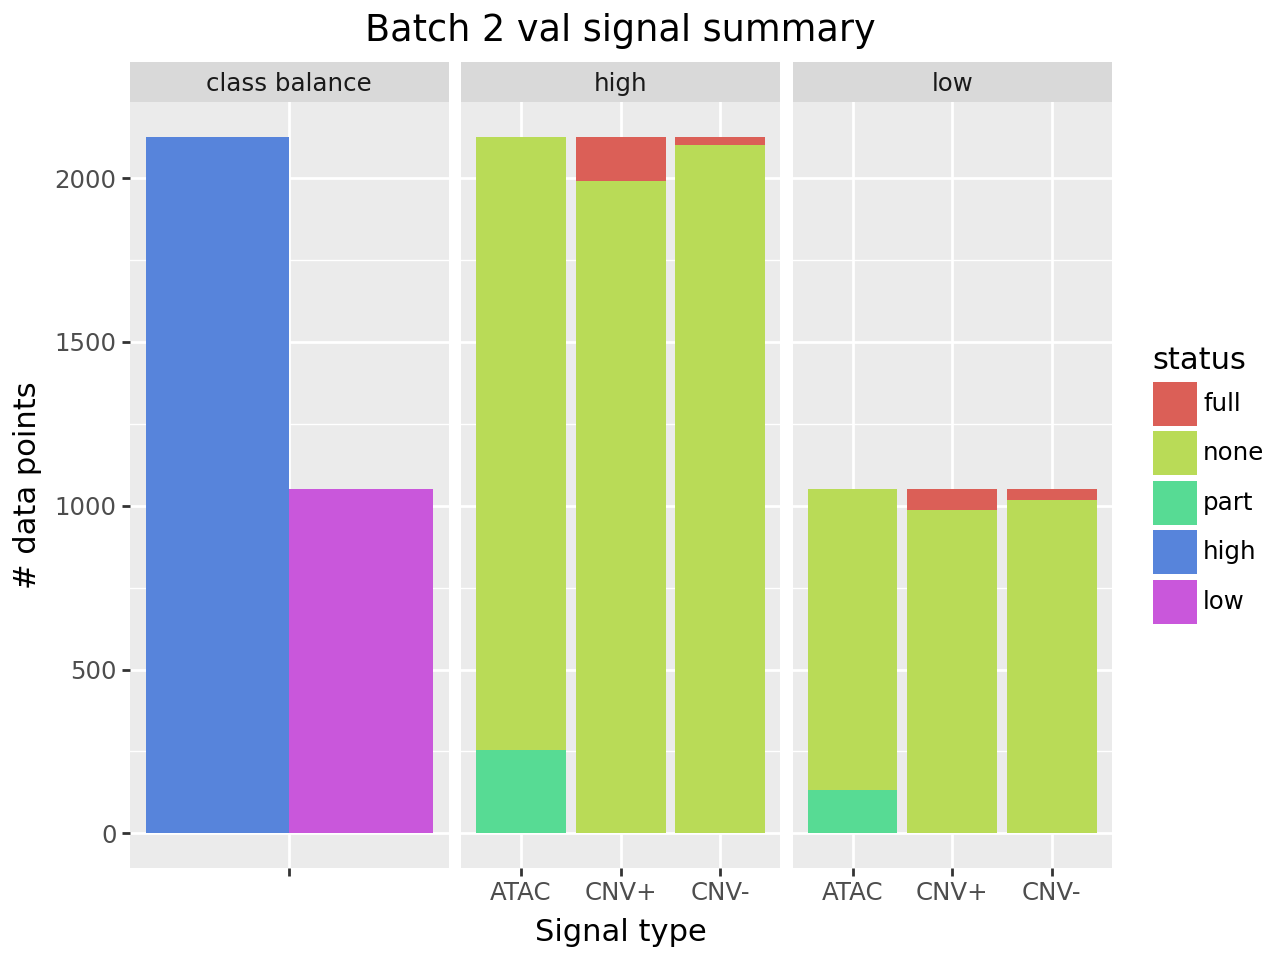

In [27]:
b2_val_dist_t, b2_val_meta_df = plot_signal_strength(b2_val, batch=2, split='val')

In [20]:
b2_train_sub_path = data_root / 'splits' / 'batch2_train_subsampled.tsv'
b2_train_sub = CnvDataset(
    root=data_root / 'embeddings' / 'batch_2' / 'train',
    data_df=pd.read_csv(b2_train_sub_path, sep='\t')
)
b2_train_sub

Using 239 barcodes
Using 1098 genes
No embedding files for 2147 data points in ../data/embeddings/batch_2/train/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 15995 datapoints

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch2_train_downsampled_signal_summary.png


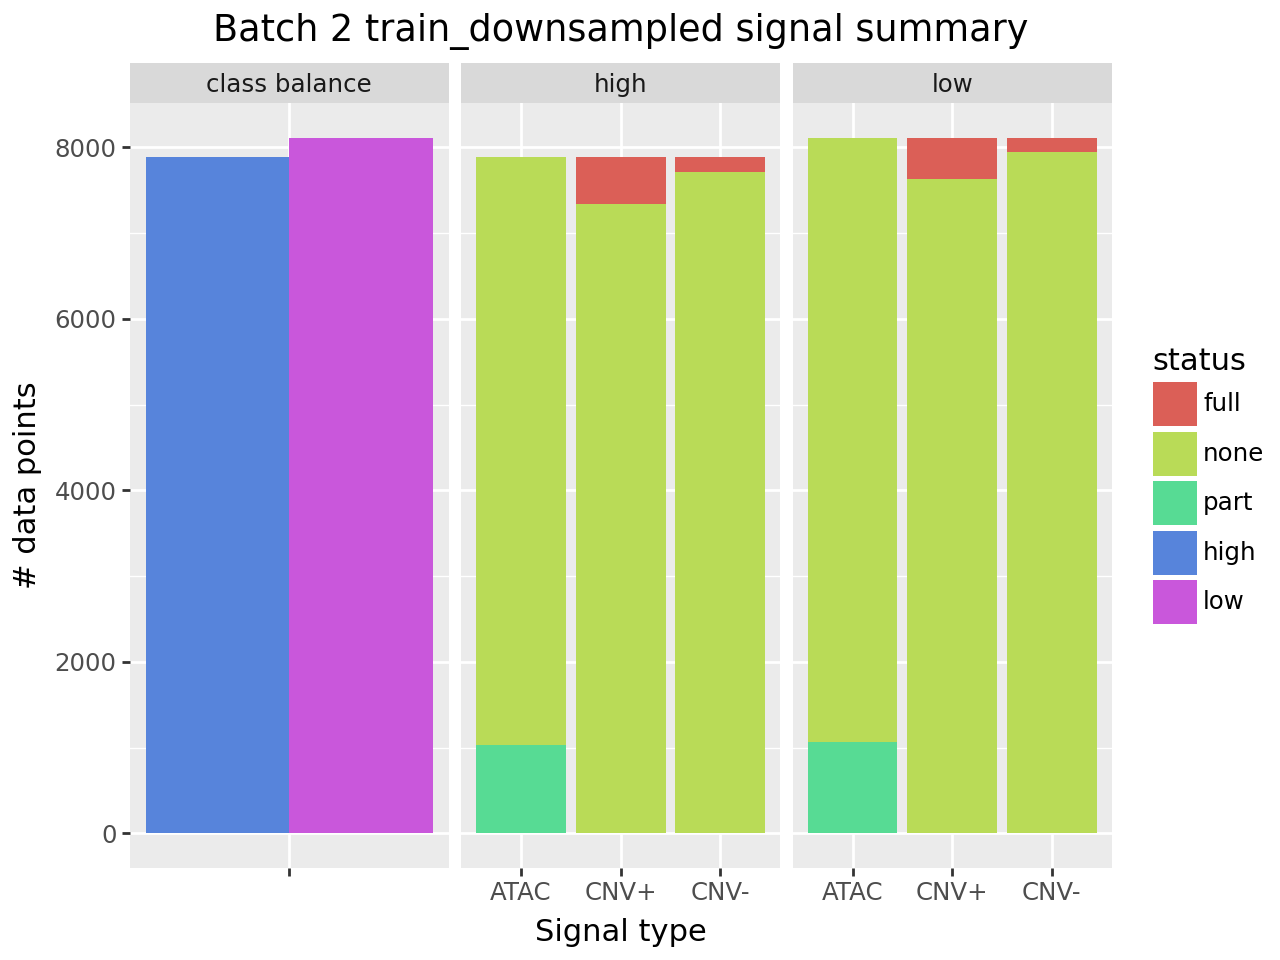

In [30]:
b2_train_sub_dist_t, b2_train_sub_meta_df = plot_signal_strength(b2_train_sub, batch=2, split='train_downsampled')

In [31]:
b2_test = CnvDataset(
    root=data_root / 'embeddings' / 'batch_2' / 'test',
    data_df=pd.read_csv(b2_test_path, sep='\t')
)
b2_test

Using 69 barcodes
Using 726 genes
No embedding files for 884 data points in ../data/embeddings/batch_2/test/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 6444 datapoints

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch2_test_signal_summary.png


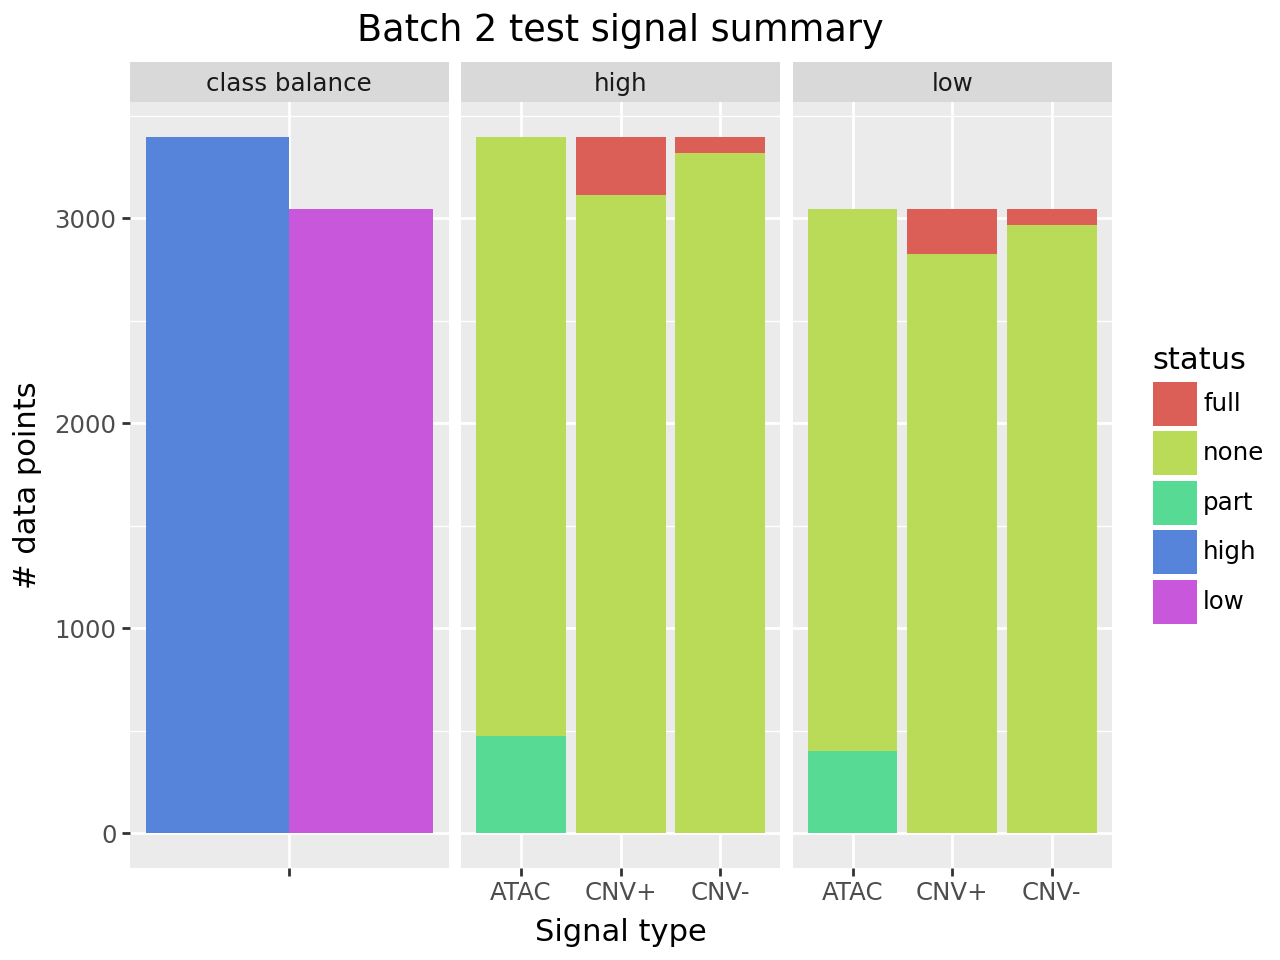

In [32]:
b2_test_dist_t, b2_test_meta_df = plot_signal_strength(b2_test, batch=2, split='test')

In [35]:
b1_train = CnvDataset(
    root=data_root / 'embeddings' / 'batch_1' / 'train',
    data_df=pd.read_csv(b1_train_path, sep='\t')
)
b1_train

Using 356 barcodes
Using 1595 genes
No embedding files for 4335 data points in ../data/embeddings/batch_1/train/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 55006 datapoints

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch1_train_signal_summary.png


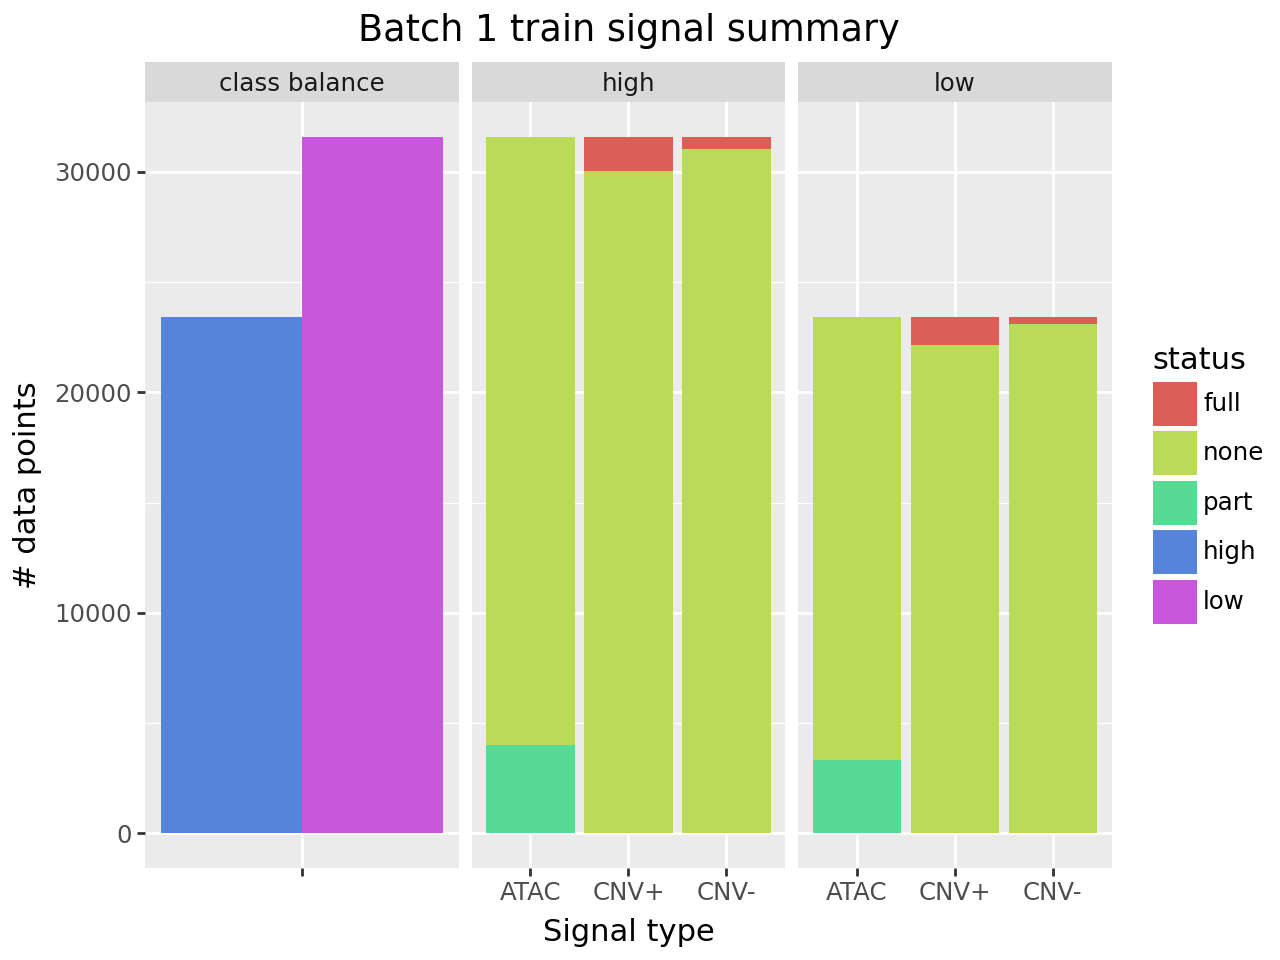

In [36]:
b1_train_dist_t, b1_train_meta_df = plot_signal_strength(b1_train, batch=1, split='train')

In [39]:
b1_train_sub_path = data_root / 'splits' / 'batch1_train_subsampled'
b1_train_sub = CnvDataset(
    root=data_root / 'embeddings' / 'batch_1' / 'train',
    data_df=pd.read_csv(b1_train_sub_path, sep='\t')
)
b1_train_sub

Using 356 barcodes
Using 1549 genes
No embedding files for 4092 data points in ../data/embeddings/batch_1/train/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 48820 datapoints

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch1_train_downsampled_signal_summary.png


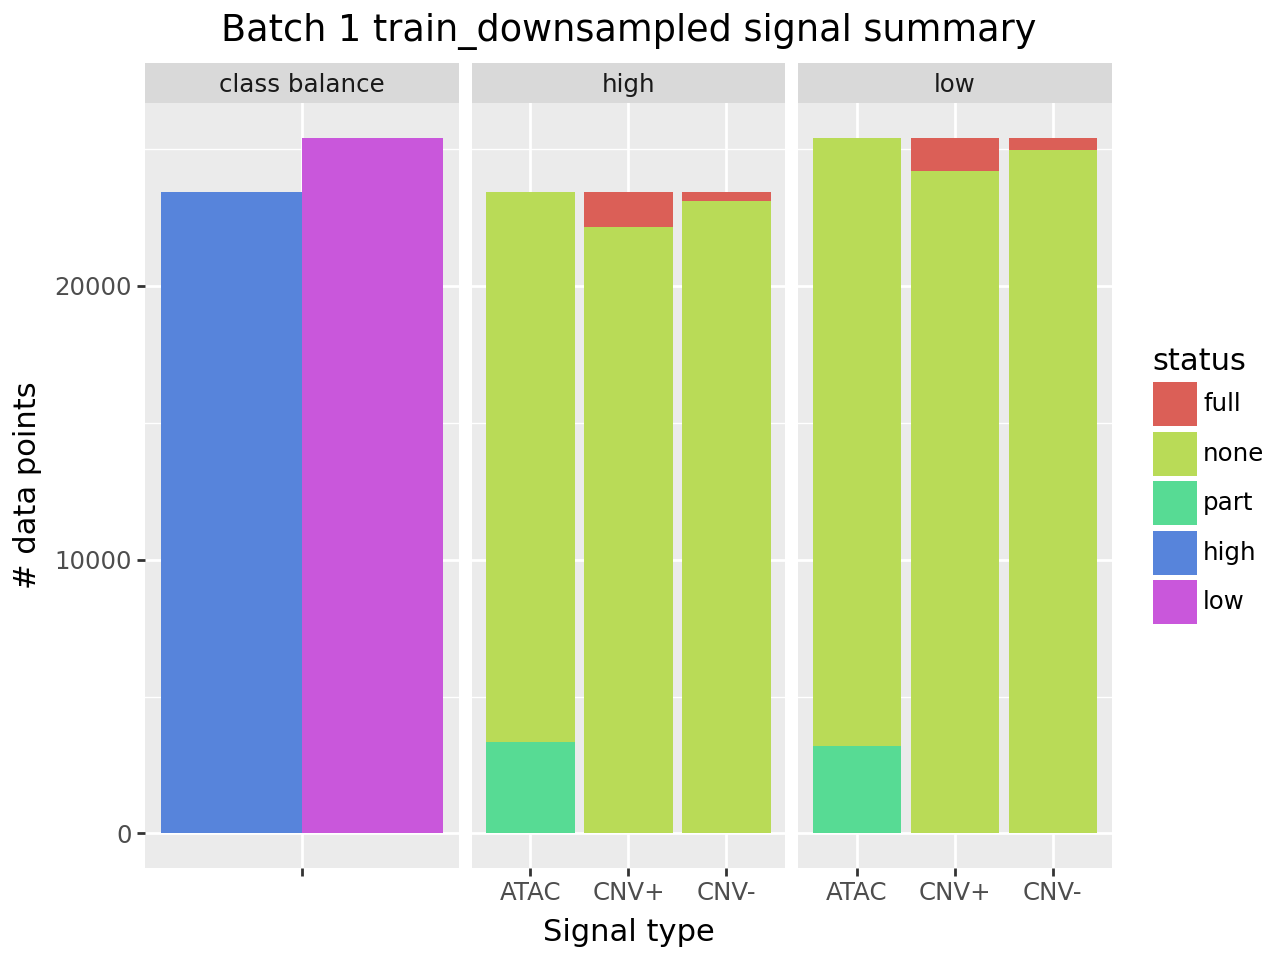

In [40]:
b1_train_sub_dist_t, b1_train_sub_meta_df = plot_signal_strength(b1_train_sub, batch=1, split='train_downsampled')

In [37]:
b1_val = CnvDataset(
    root=data_root / 'embeddings' / 'batch_1' / 'val',
    data_df=pd.read_csv(b1_val_path, sep='\t')
)
b1_val

Using 51 barcodes
Using 1093 genes
No embedding files for 988 data points in ../data/embeddings/batch_1/val/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 7966 datapoints

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch1_val_signal_summary.png


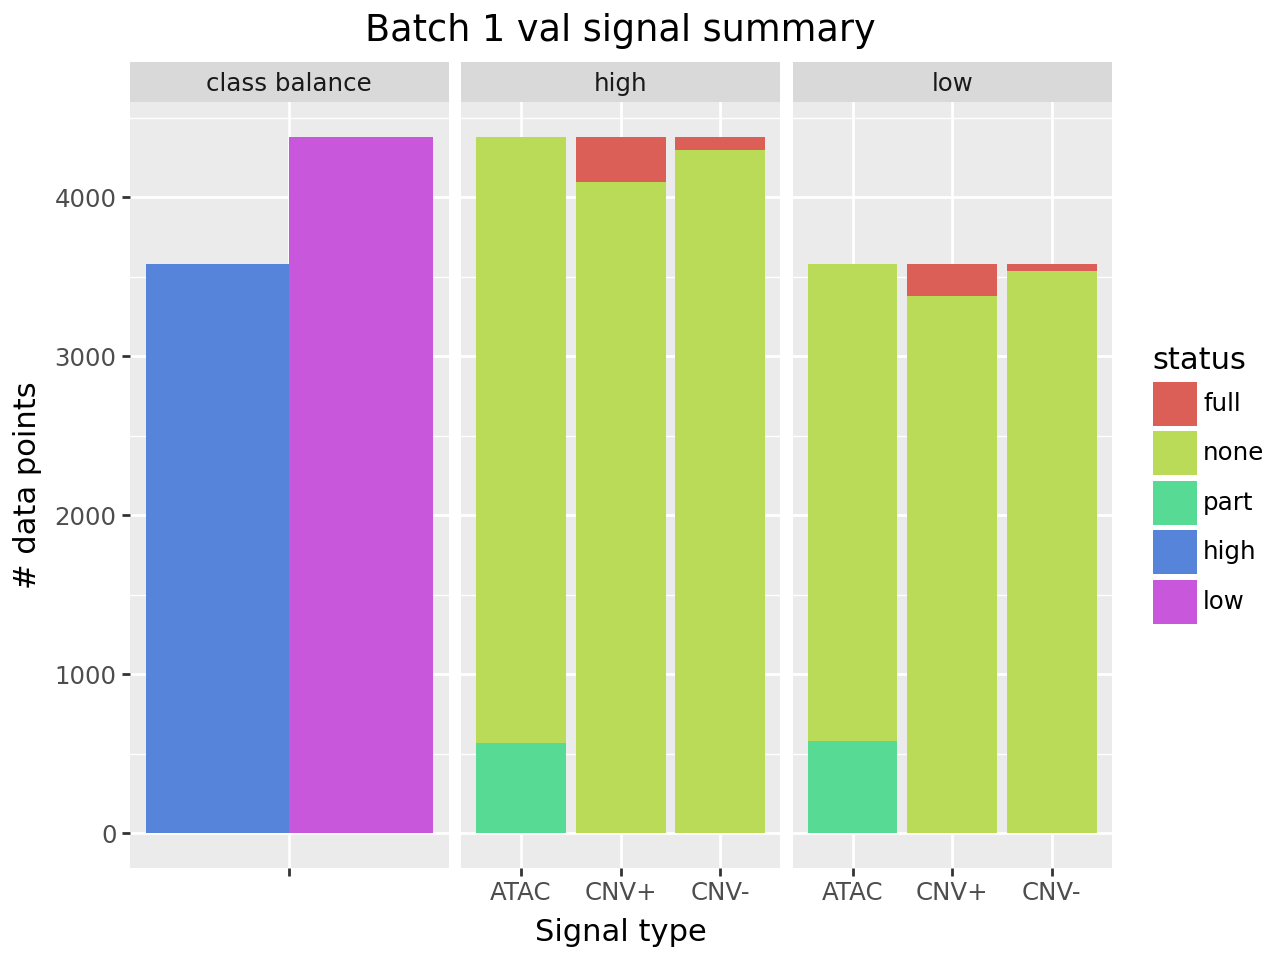

In [38]:
b1_val_dist_t, b1_val_meta_df = plot_signal_strength(b1_val, batch=1, split='val')

In [33]:
b1_test = CnvDataset(
    root=data_root / 'embeddings' / 'batch_1' / 'test',
    data_df=pd.read_csv(b1_test_path, sep='\t')
)
b1_test

Using 102 barcodes
Using 1235 genes
No embedding files for 2149 data points in ../data/embeddings/batch_1/test/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 16486 datapoints

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch1_test_signal_summary.png


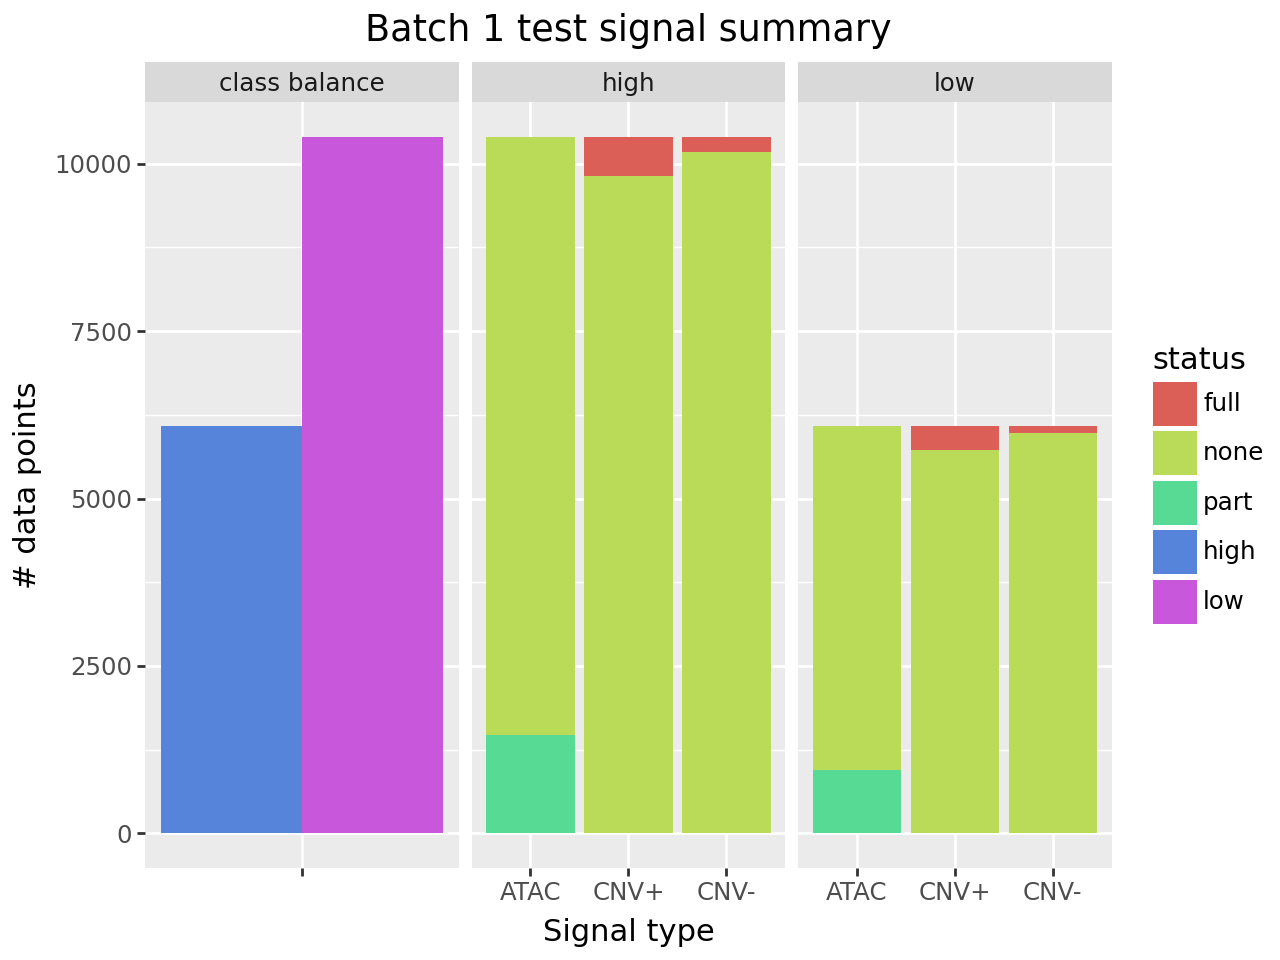

In [34]:
b1_test_dist_t, b1_test_meta_df = plot_signal_strength(b1_test, batch=1, split='test')

### Full distributions
This subsection explores the distribution in the datasets per row in each embedding.
Only the rows 5, 6 and 7 are taken into account here, as they encode scATAC, CNV loss and CNV gain respectively.

In [ ]:
def plot_dataset_dist(dataset: CnvDataset, name: str):
    dist_tensor = torch.vstack([e.sum(axis=1) for e, _ in dataset])
    # dist_tensor.sum(dist_tensor, axis=0)

    p = ggplot(aes(x = dist_tensor[:,4])) + geom_histogram() + \
        labs(
            title=name + ' ATAC openess',
            x='Open positions in embedding',
            y='Count'
        )
    p.show()
    
    p = ggplot(aes(x = dist_tensor[:,5])) + geom_histogram() + \
        labs(
            title=name + ' CNV loss',
            x='# positions with CNV loss in embedding',
            y='Count'
        )
    p.show()
    
    p = ggplot(aes(x = dist_tensor[:,6])) + geom_histogram() + \
        labs(
            title=name + ' CNV gain',
            x='# positions with CNV gain in embedding',
            y='Count'
        )
    p.show()
    
    return dist_tensor
    

#### Batch 1 Distributions
Following, the ATAC signal and CNV loss/gain signal distributions will be plotted for all batch 1 dataset splits.

In [ ]:
b1_train = CnvDataset(
    root=data_root / 'embeddings' / 'batch_1' / 'training',
    data_df=pd.read_csv(b1_train_path, sep='\t'),
    file_format='mtx'
)
b1_train

Using 356 barcodes
Using 1595 genes
No embedding files for 4566 data points in ../data/embeddings/batch_1/training/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 54775 datapoints

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 235'. Pick better value with 'binwidth'.


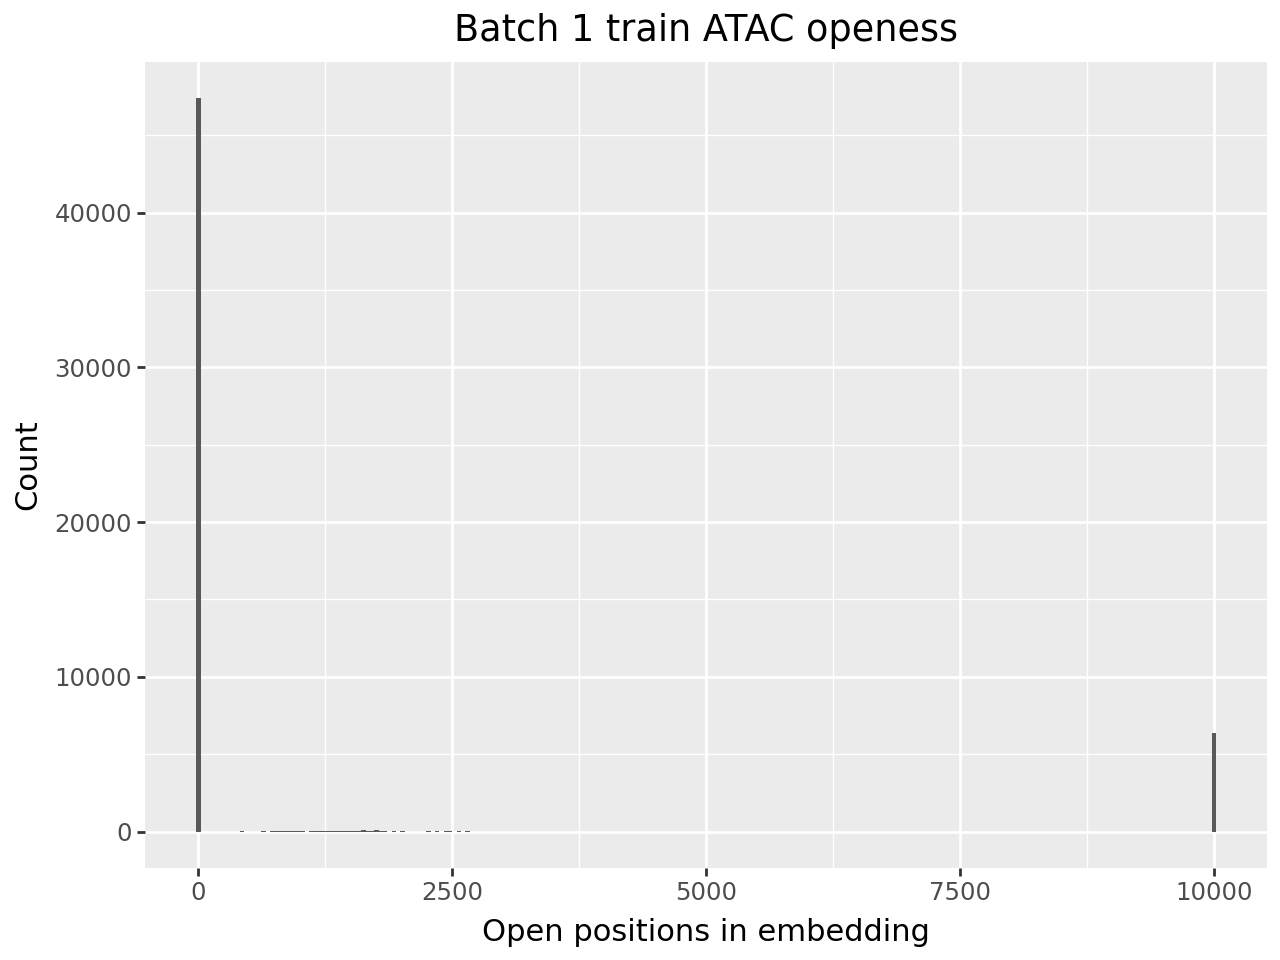

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 235'. Pick better value with 'binwidth'.


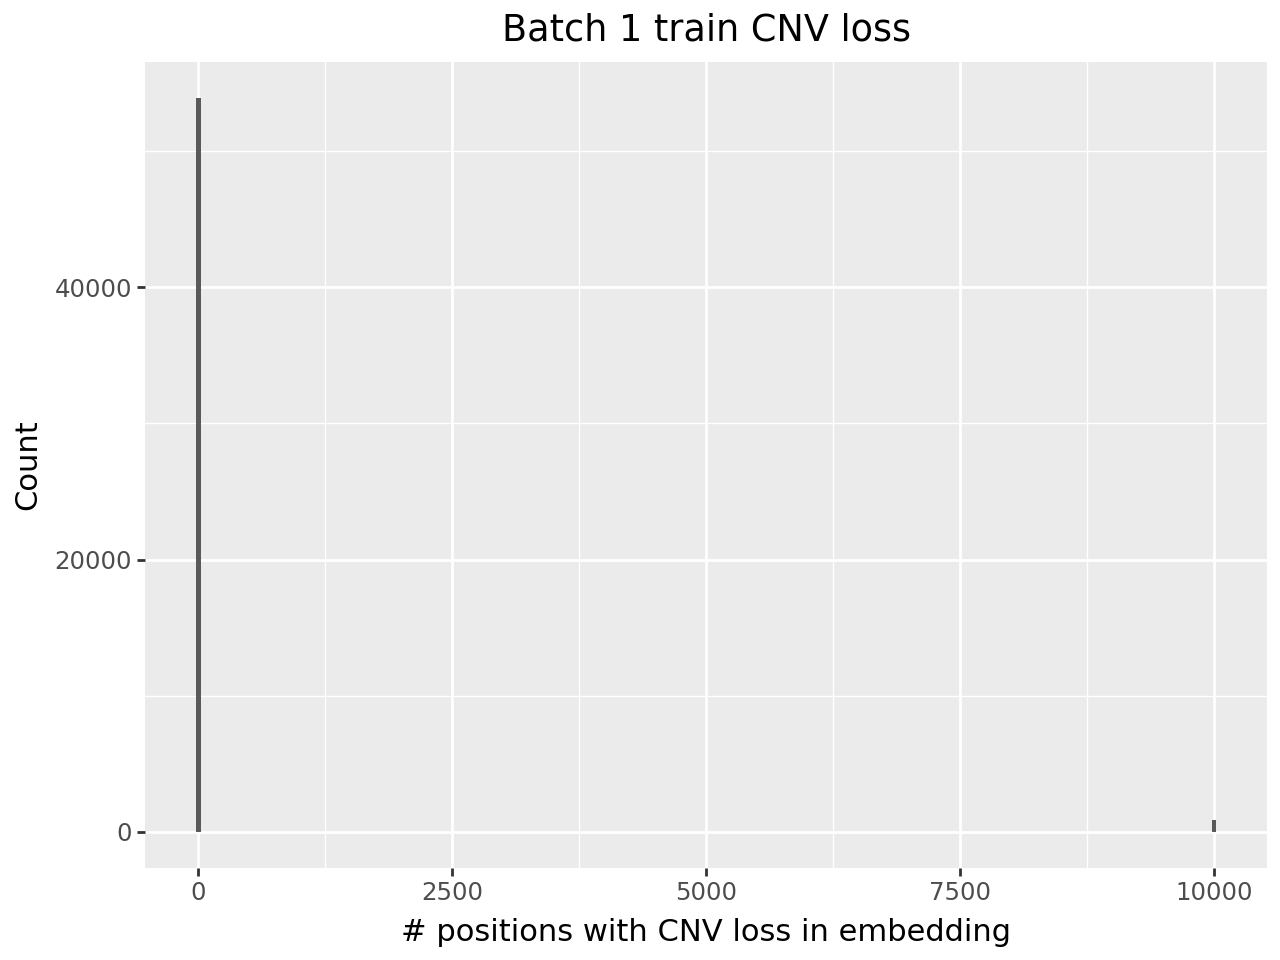

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 235'. Pick better value with 'binwidth'.


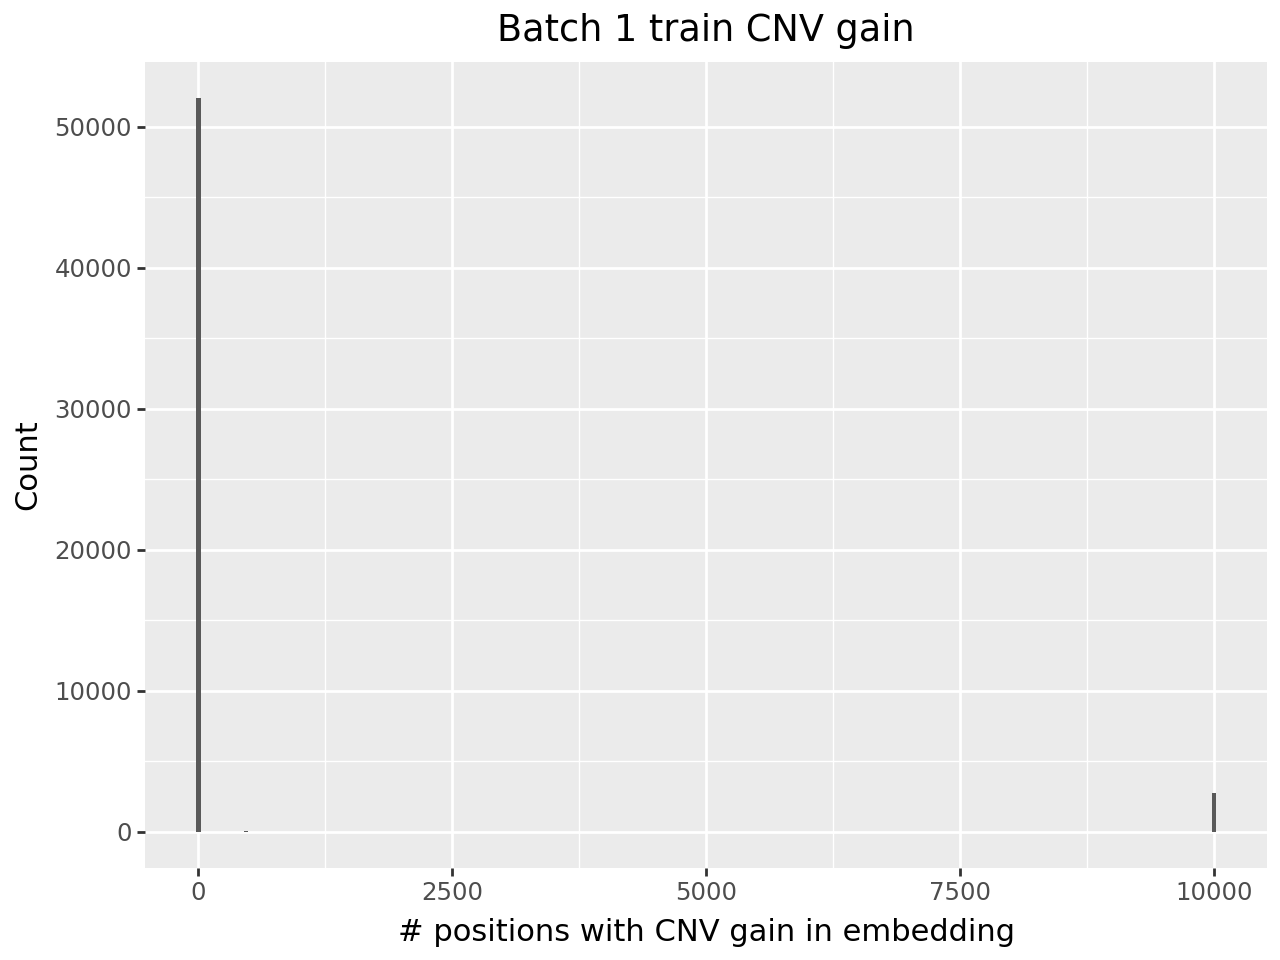

tensor([[2370., 2583., 2751.,  ...,    0.,    0.,    0.],
        [2990., 2003., 1999.,  ...,    0.,    0.,    0.],
        [3491., 1881., 2057.,  ...,    0.,    0.,    0.],
        ...,
        [3128., 1874., 2111.,  ...,    0.,    0.,    0.],
        [2459., 2356., 2635.,  ...,    0.,    0.,    0.],
        [2503., 2226., 2019.,  ...,    0.,    0.,    0.]])

In [ ]:
b1_train_dist_t = plot_dataset_dist(b1_train, name='Batch 1 train')
b1_train_dist_t

In [ ]:
b1_val = CnvDataset(
    root=data_root / 'embeddings' / 'batch_1' / 'val',
    data_df=pd.read_csv(b1_val_path, sep='\t')
)
b1_val

Using 51 barcodes
Using 1093 genes
No embedding files for 988 data points in ../data/embeddings/batch_1/val/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 7966 datapoints

In [ ]:
b1_val_dist_t = plot_dataset_dist(b1_val, name='Batch 1 val')
b1_val_dist_t

NameError: name 'plot_dataset_dist' is not defined

In [ ]:
b1_test = CnvDataset(
    root=data_root / 'embeddings' / 'batch_1' / 'test',
    data_df=pd.read_csv(b1_test_path, sep='\t'),
    file_format='mtx'
)
b1_test

Using 102 barcodes
Using 1235 genes
No embedding files for 3795 data points in ../data/embeddings/batch_1/test/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 14840 datapoints

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 122'. Pick better value with 'binwidth'.


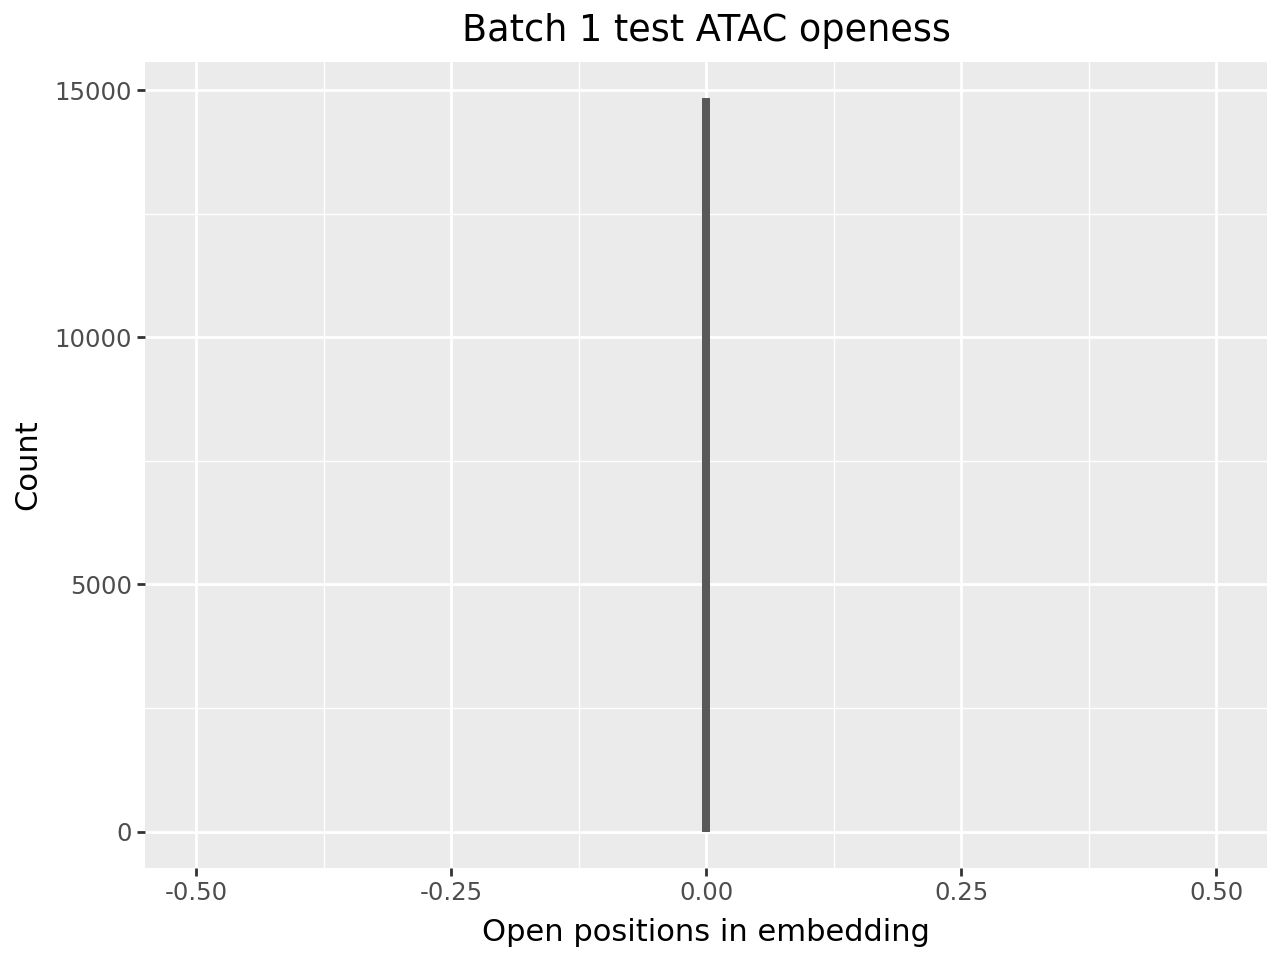

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 122'. Pick better value with 'binwidth'.


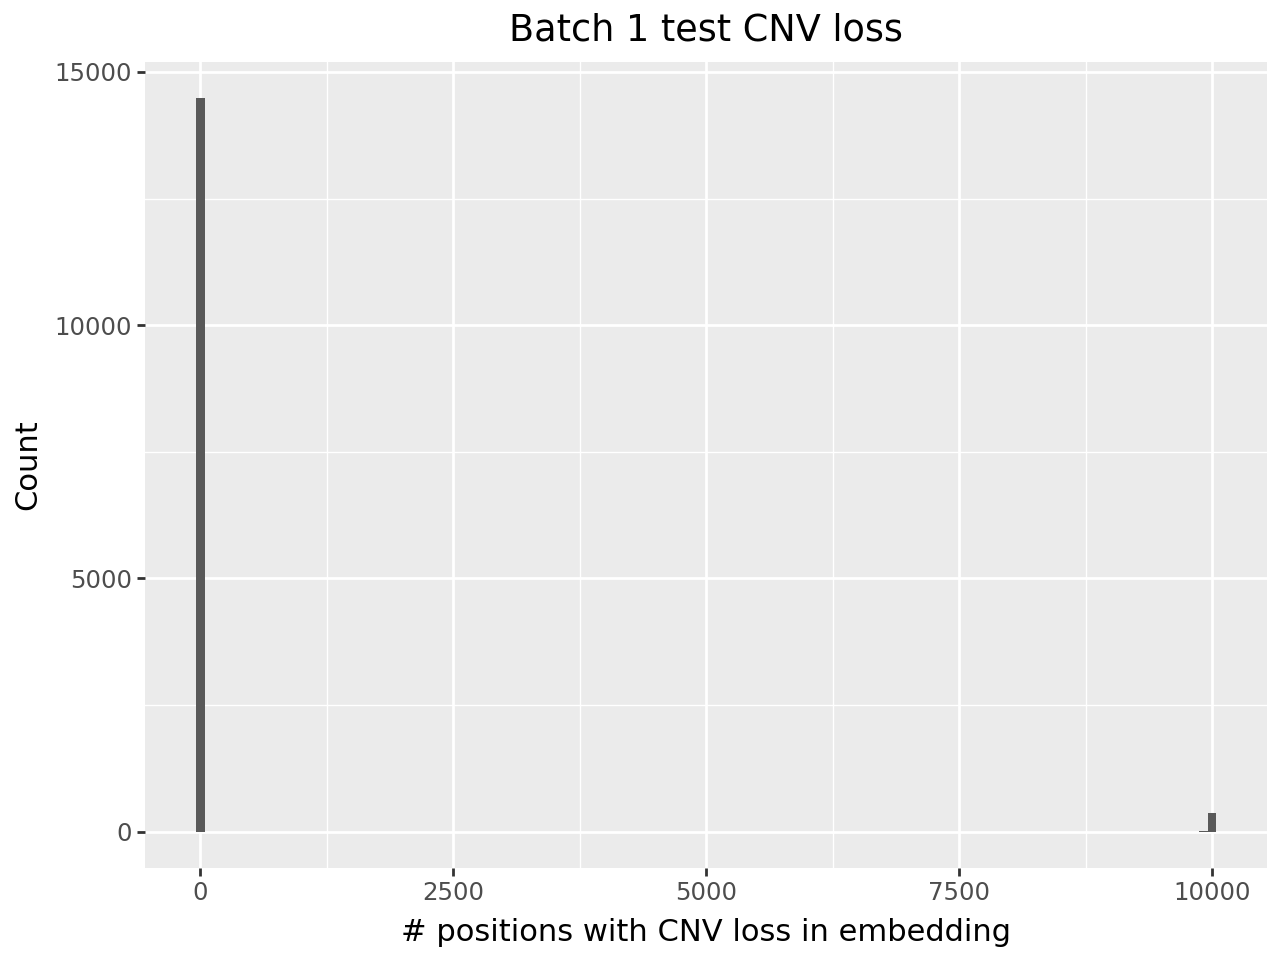

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 122'. Pick better value with 'binwidth'.


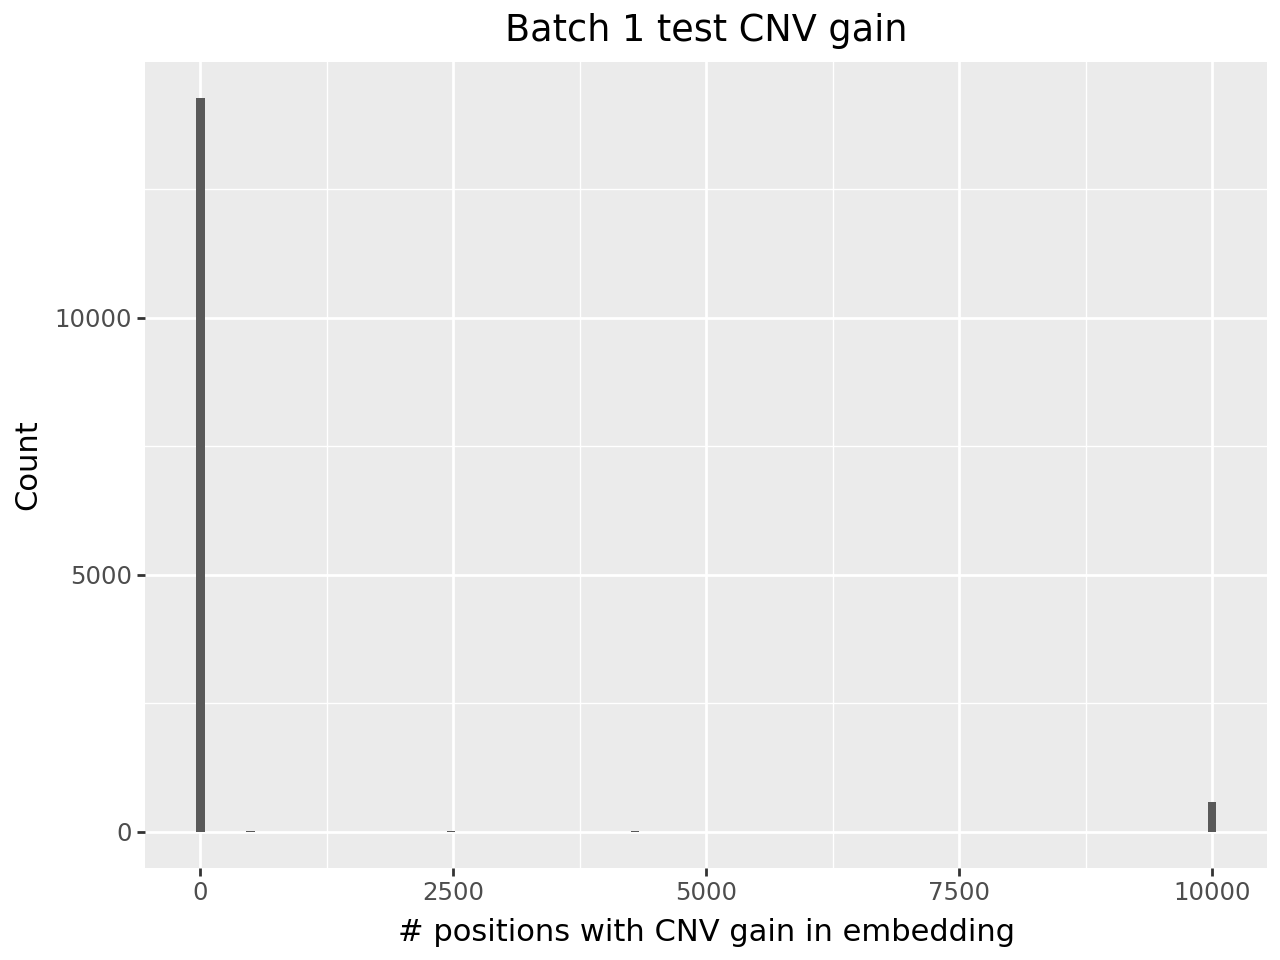

tensor([[2297., 2646., 2628.,  ...,    0.,    0.,    0.],
        [2954., 2096., 1976.,  ...,    0.,    0.,    0.],
        [3187., 1742., 1784.,  ...,    0.,    0.,    0.],
        ...,
        [2079., 2904., 3083.,  ...,    0.,    0.,    0.],
        [2044., 2630., 2919.,  ...,    0.,    0.,    0.],
        [2180., 2850., 2671.,  ...,    0.,    0.,    0.]])

In [ ]:
b1_test_dist_t = plot_dataset_dist(b1_test, name='Batch 1 test')
b1_test_dist_t

This is an old version of the batch 1 test data set, remove all `.mtx` files from the directory.
Use these commands:
```sh
find data/embeddings/batch_1/test/single_gene_barcode/ -type f -name *.mtx | wc -l
```
and
```sh
for f in $(find data/embeddings/batch_1/test/single_gene_barcode/ -type f -name *.mtx); do rm -v $f; done | wc -l
```

In [ ]:
b1_test_pt = CnvDataset(
    root=data_root / 'embeddings' / 'batch_1' / 'test',
    data_df=pd.read_csv(b1_test_path, sep='\t'),
    file_format='pt'
)
b1_test_pt

Using 102 barcodes
Using 1235 genes
No embedding files for 2149 data points in ../data/embeddings/batch_1/test/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 16486 datapoints

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 129'. Pick better value with 'binwidth'.


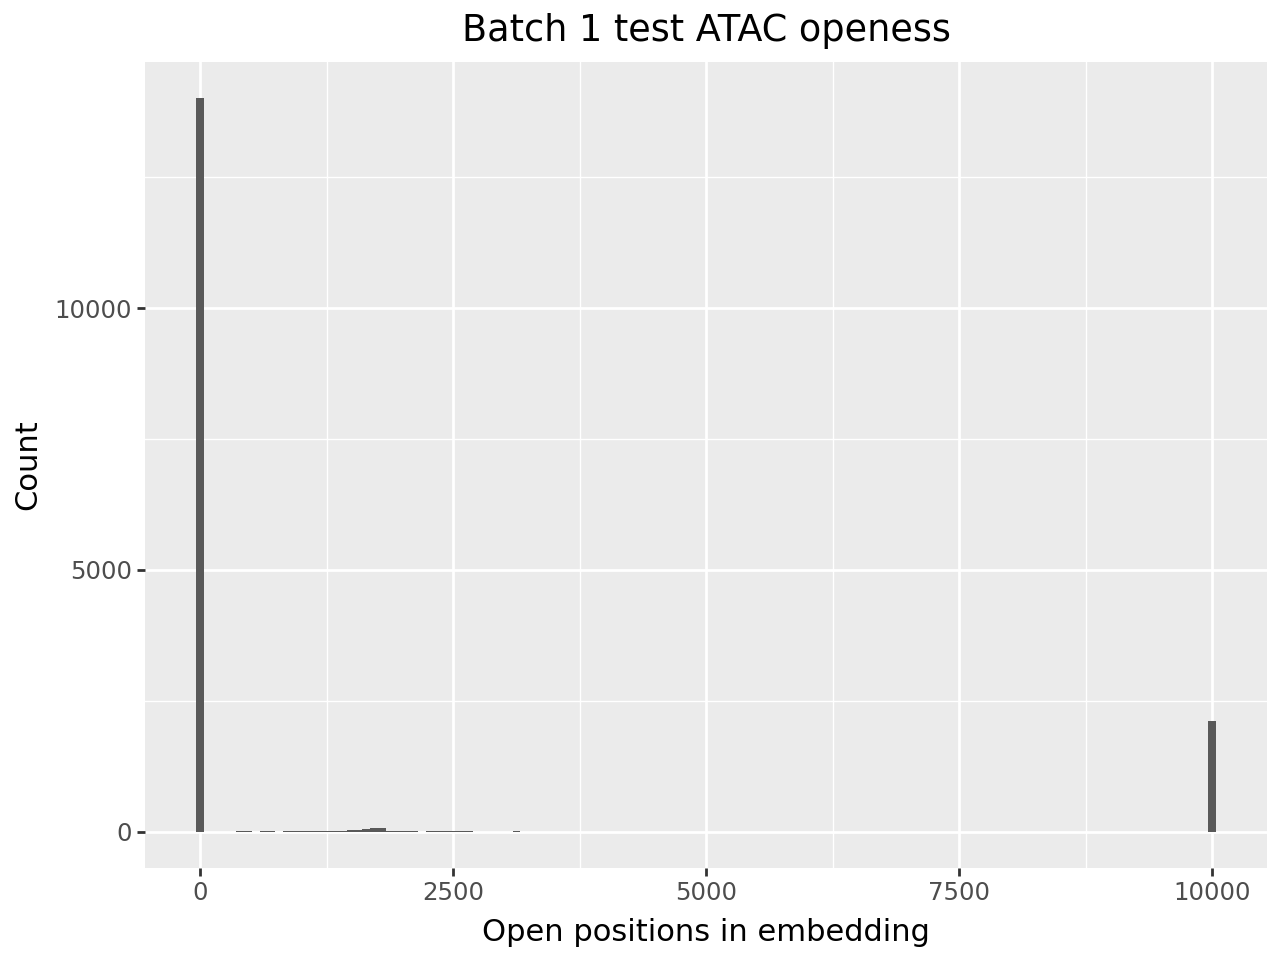

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 129'. Pick better value with 'binwidth'.


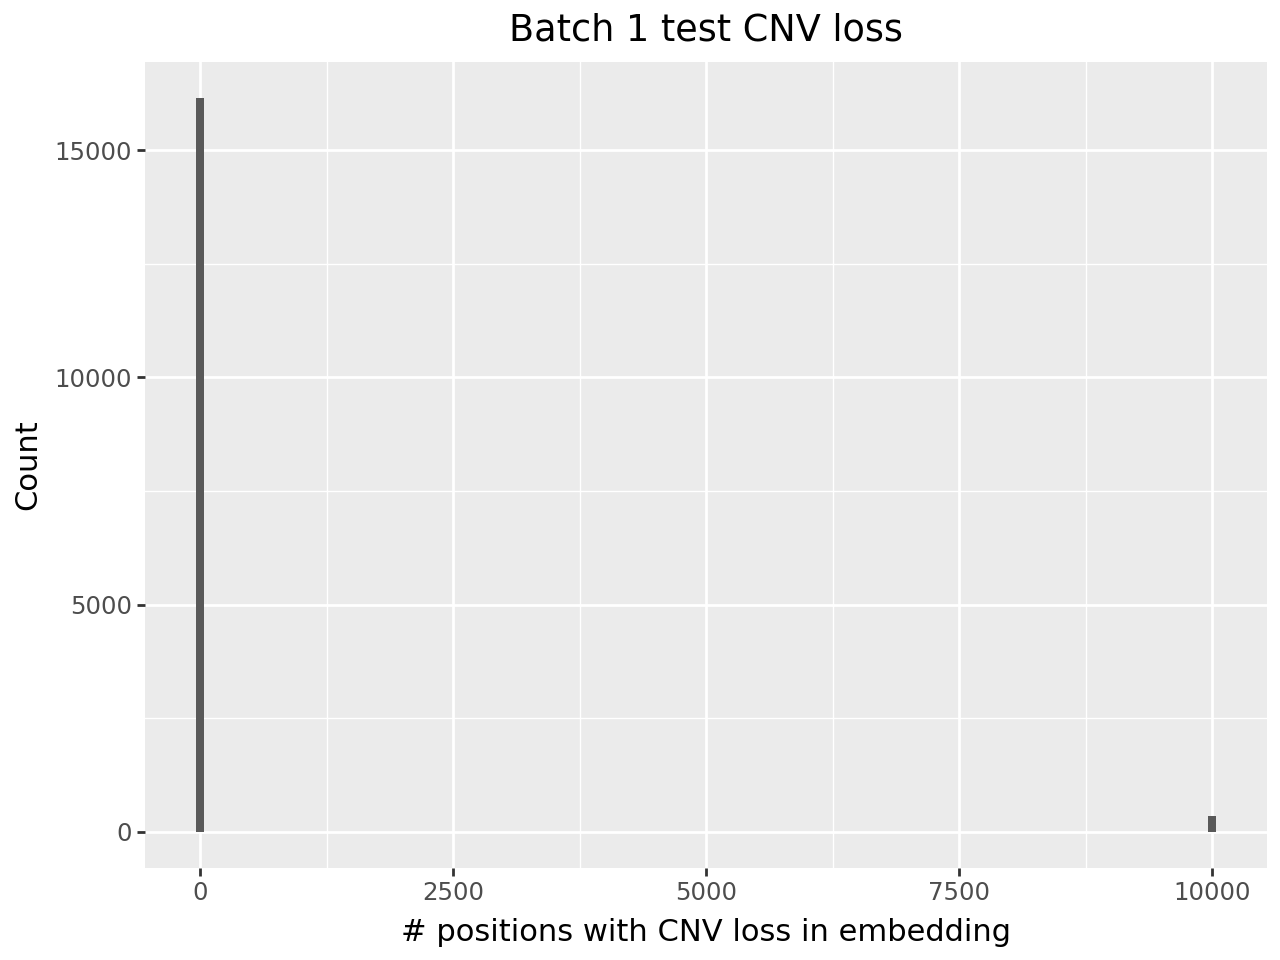

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 129'. Pick better value with 'binwidth'.


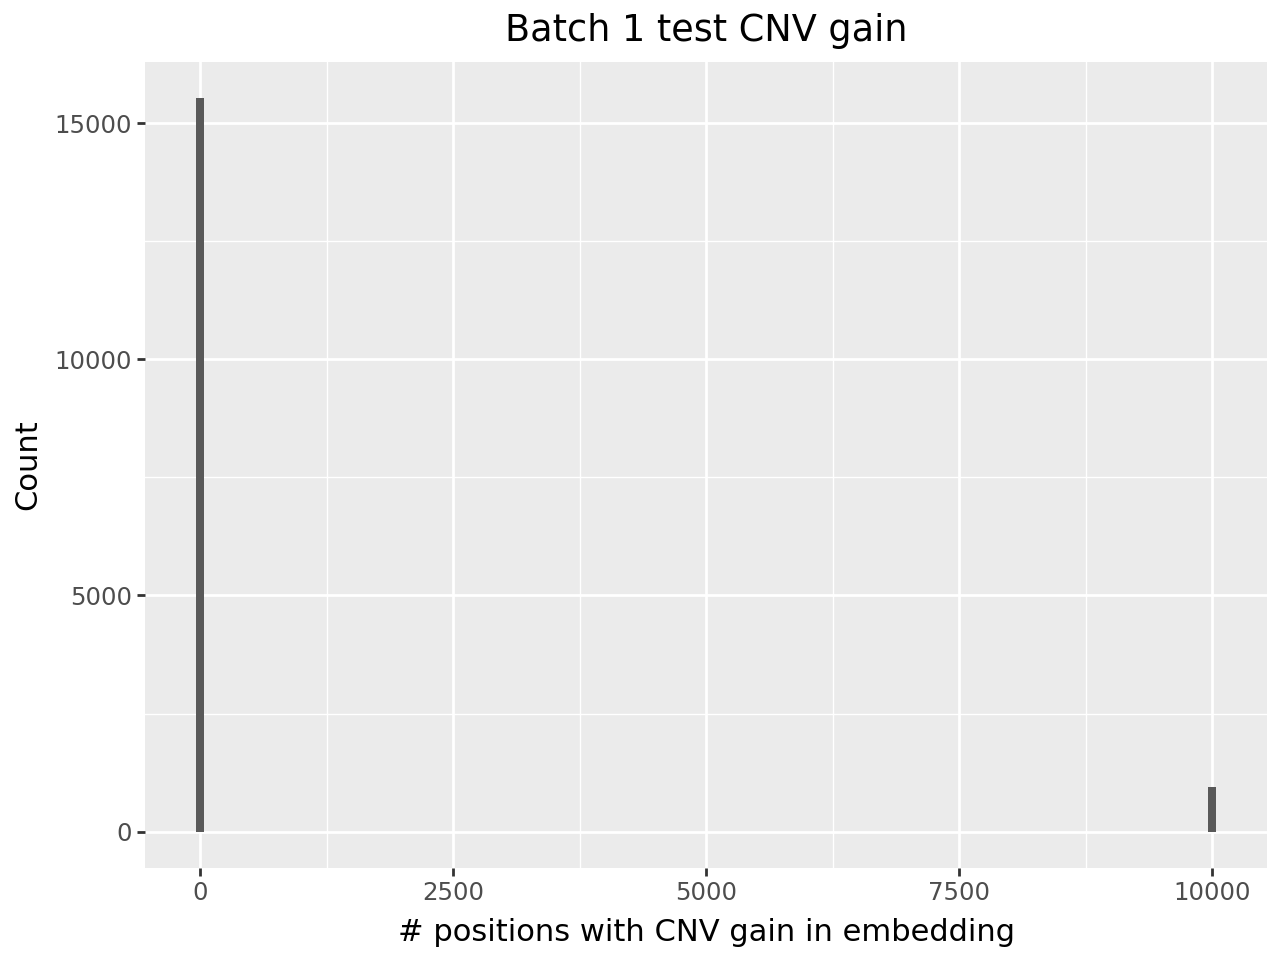

tensor([[ 2370.,  2583.,  2751.,  ...,     0.,     0.,     0.],
        [ 2906.,  2107.,  2009.,  ...,     0.,     0.,     0.],
        [ 3203.,  1747.,  1678.,  ...,     0.,     0.,     0.],
        ...,
        [ 2862.,  2216.,  2271.,  ...,     0.,     0., 10000.],
        [ 2580.,  2086.,  2085.,  ...,     0.,     0.,     0.],
        [ 2544.,  2174.,  2288.,  ...,     0.,     0.,     0.]])

In [ ]:
b1_test_pt_dist_t = plot_dataset_dist(b1_test_pt, name='Batch 1 test')
b1_test_pt_dist_t

#### Batch 2 Distributions
The follwoing analyses the distributions in batch 2 data set splits.

In [ ]:
b2_train = CnvDataset(
    root=data_root / 'embeddings' / 'batch_2' / 'train',
    data_df=pd.read_csv(b2_train_path, sep='\t'),
)
b2_train

Using 239 barcodes
Using 1217 genes
No embedding files for 2835 data points in ../data/embeddings/batch_2/train/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 20661 datapoints

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 144'. Pick better value with 'binwidth'.


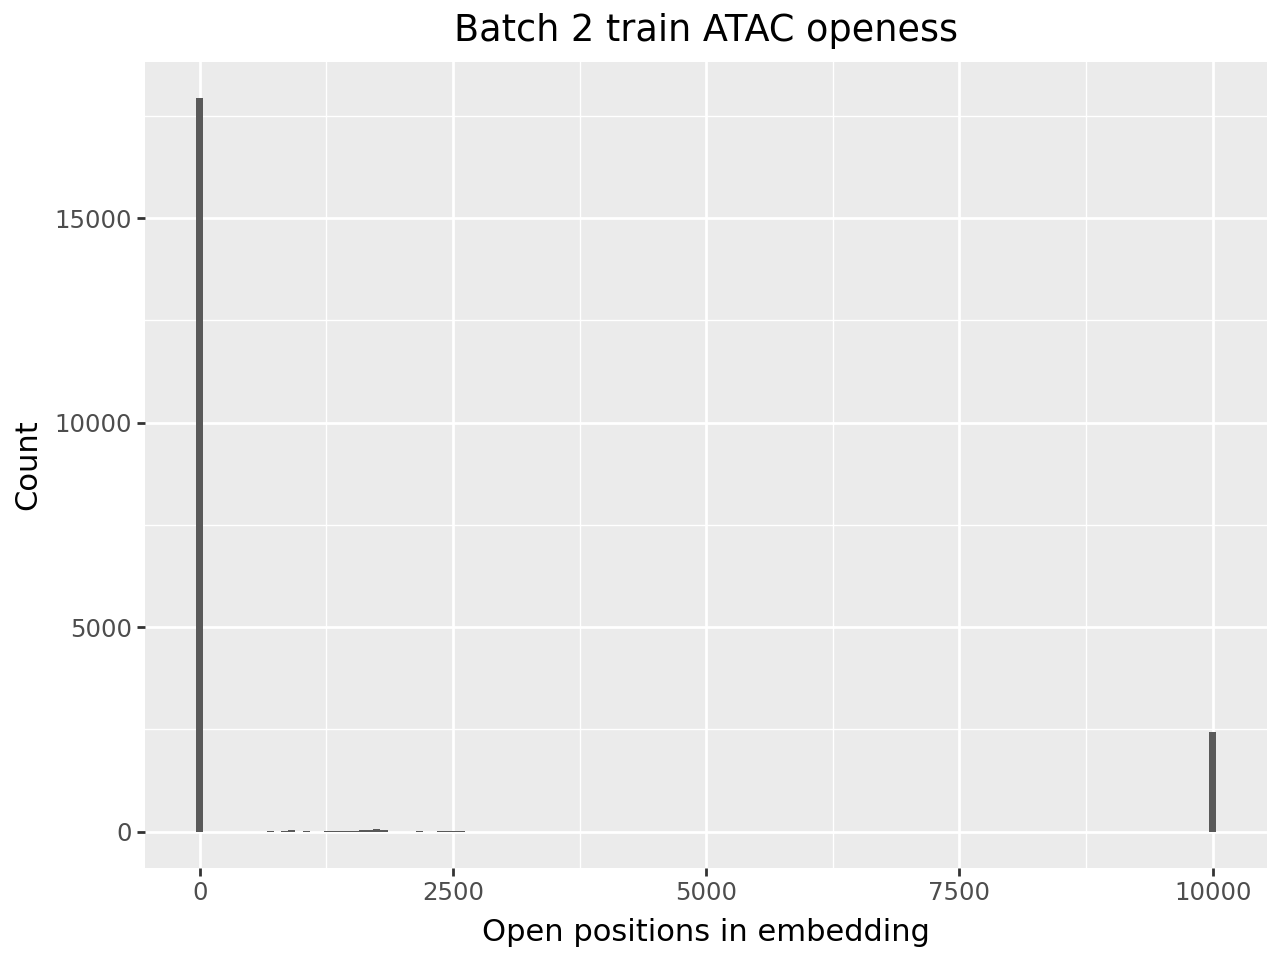

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 144'. Pick better value with 'binwidth'.


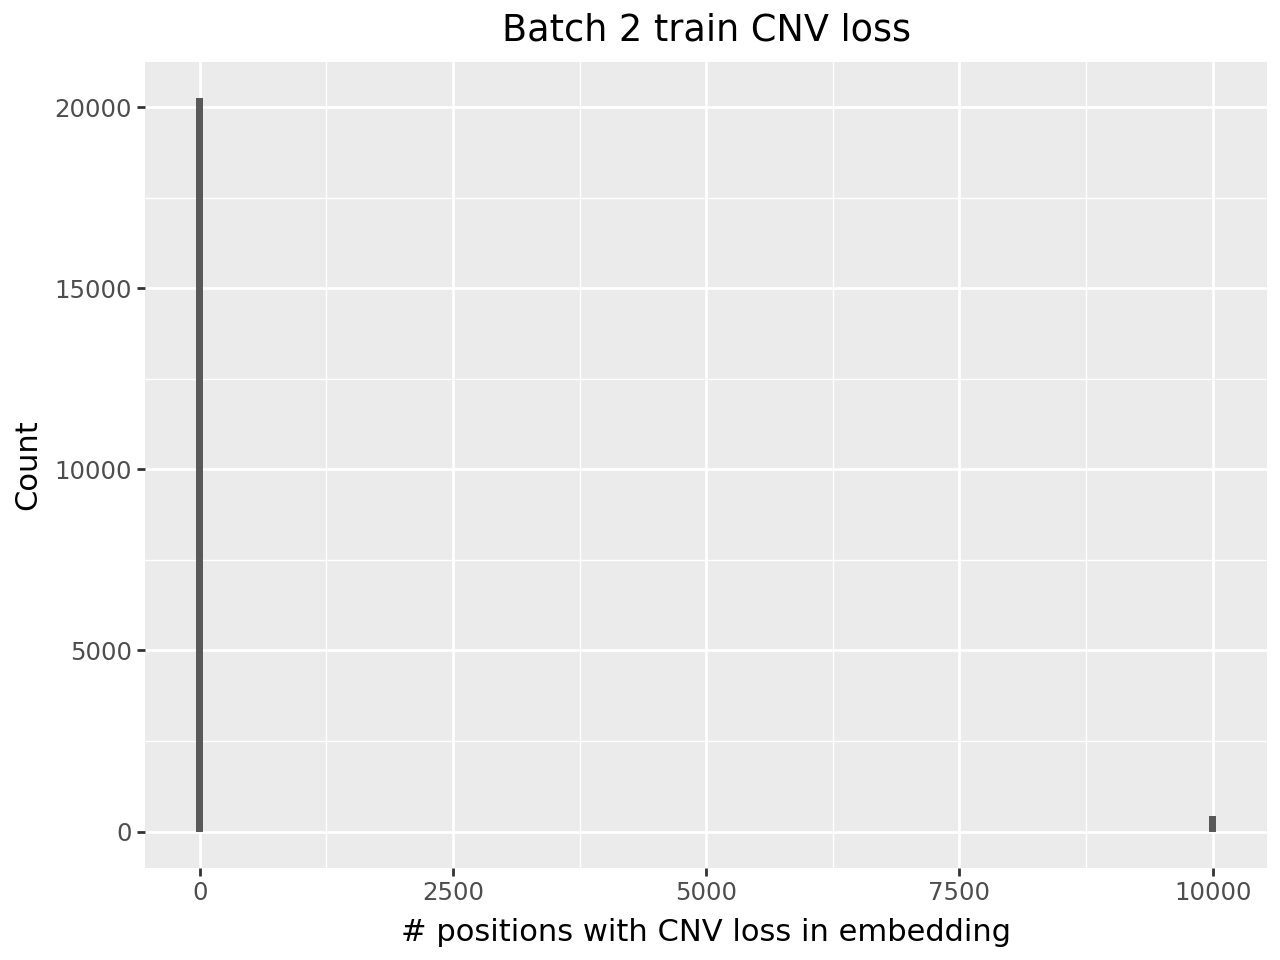

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 144'. Pick better value with 'binwidth'.


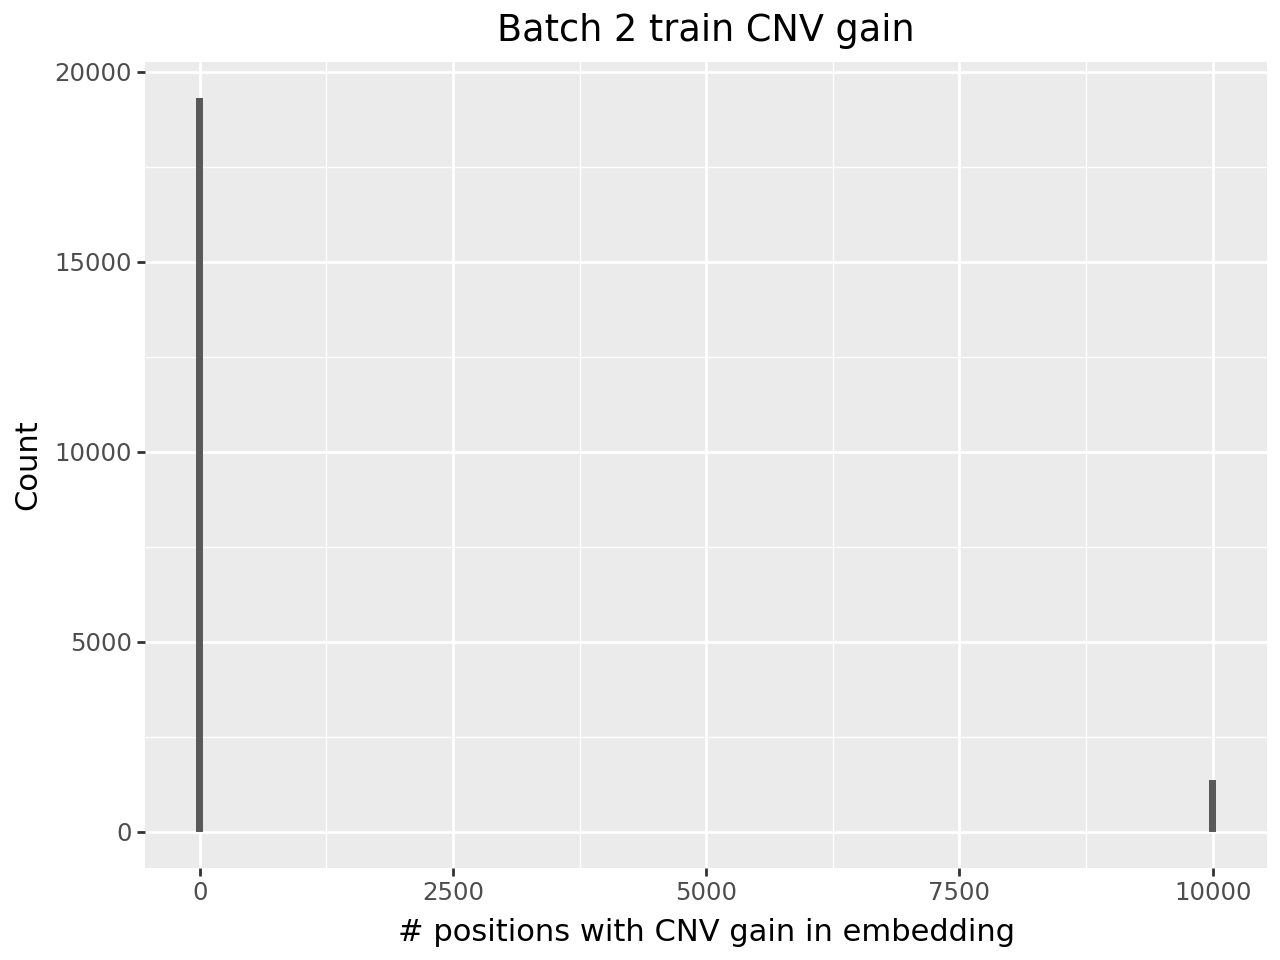

tensor([[1687., 2982., 3379.,  ...,    0.,    0.,    0.],
        [2410., 2315., 2466.,  ...,    0.,    0.,    0.],
        [2370., 2583., 2751.,  ...,    0.,    0.,    0.],
        ...,
        [2207., 3093., 2507.,  ...,    0.,    0.,    0.],
        [2366., 2796., 2674.,  ...,    0.,    0.,    0.],
        [2308., 2223., 2870.,  ...,    0.,    0.,    0.]])

In [ ]:
b2_train_dist_t = plot_dataset_dist(b2_train, name='Batch 2 train')
b2_train_dist_t

In [ ]:
b2_val = CnvDataset(
    root=data_root / 'embeddings' / 'batch_2' / 'val_pt',
    data_df=pd.read_csv(b2_val_path, sep='\t')
)
b2_val

Using 35 barcodes
Using 621 genes
No embedding files for 426 data points in ../data/embeddings/batch_2/val_pt/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 3177 datapoints

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 57'. Pick better value with 'binwidth'.


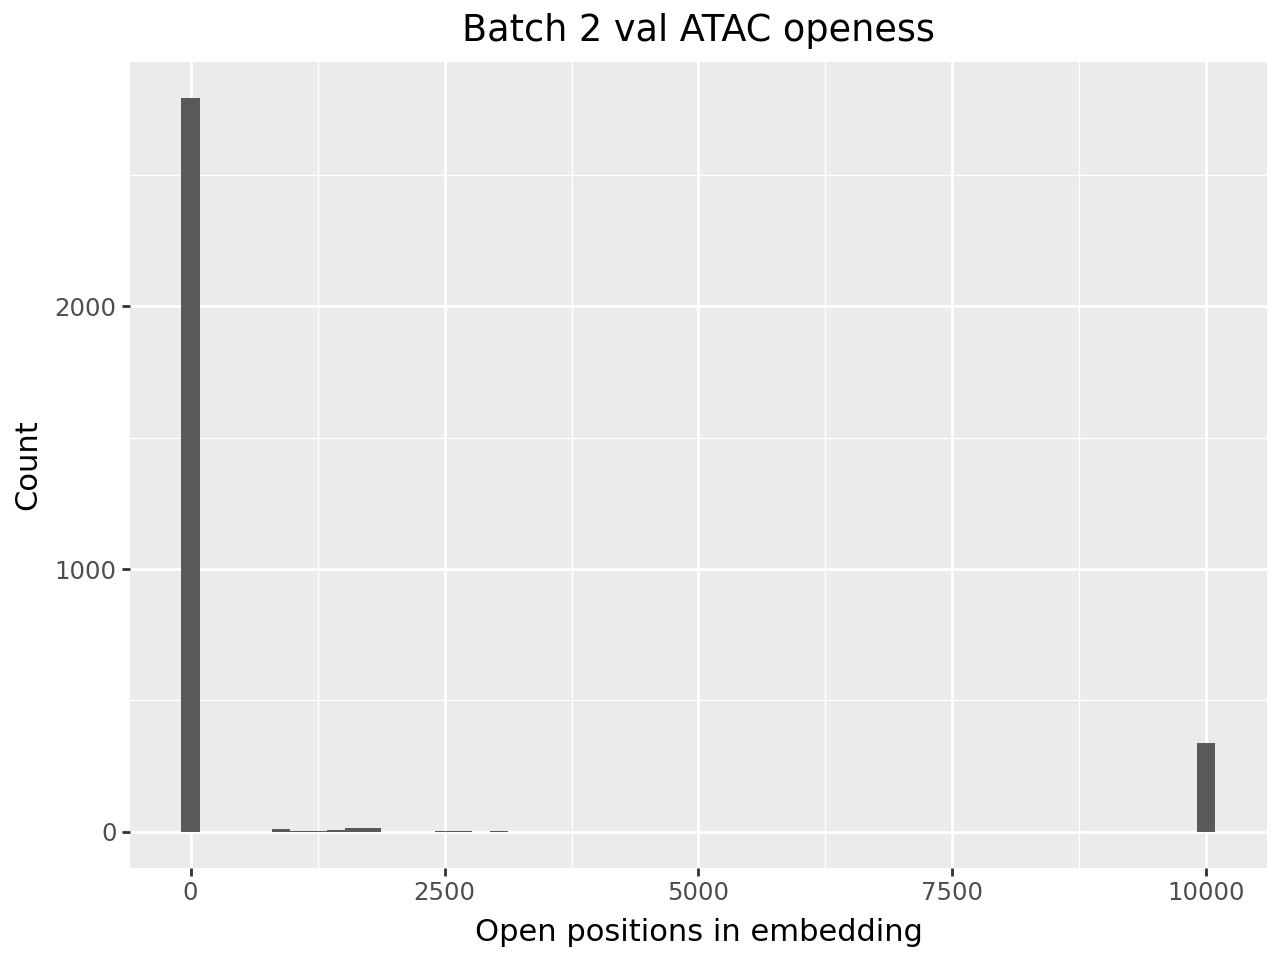

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 57'. Pick better value with 'binwidth'.


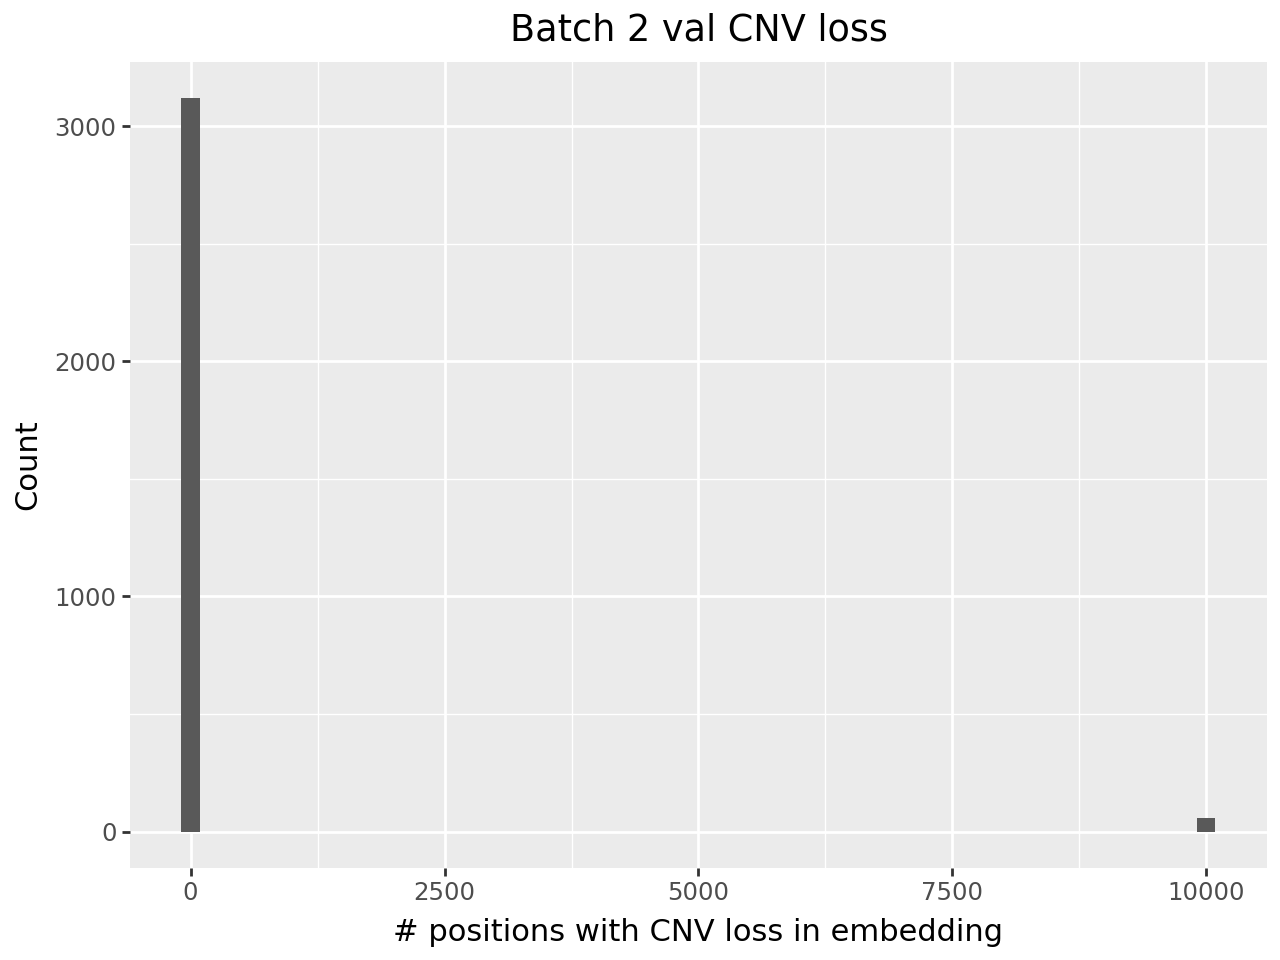

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 57'. Pick better value with 'binwidth'.


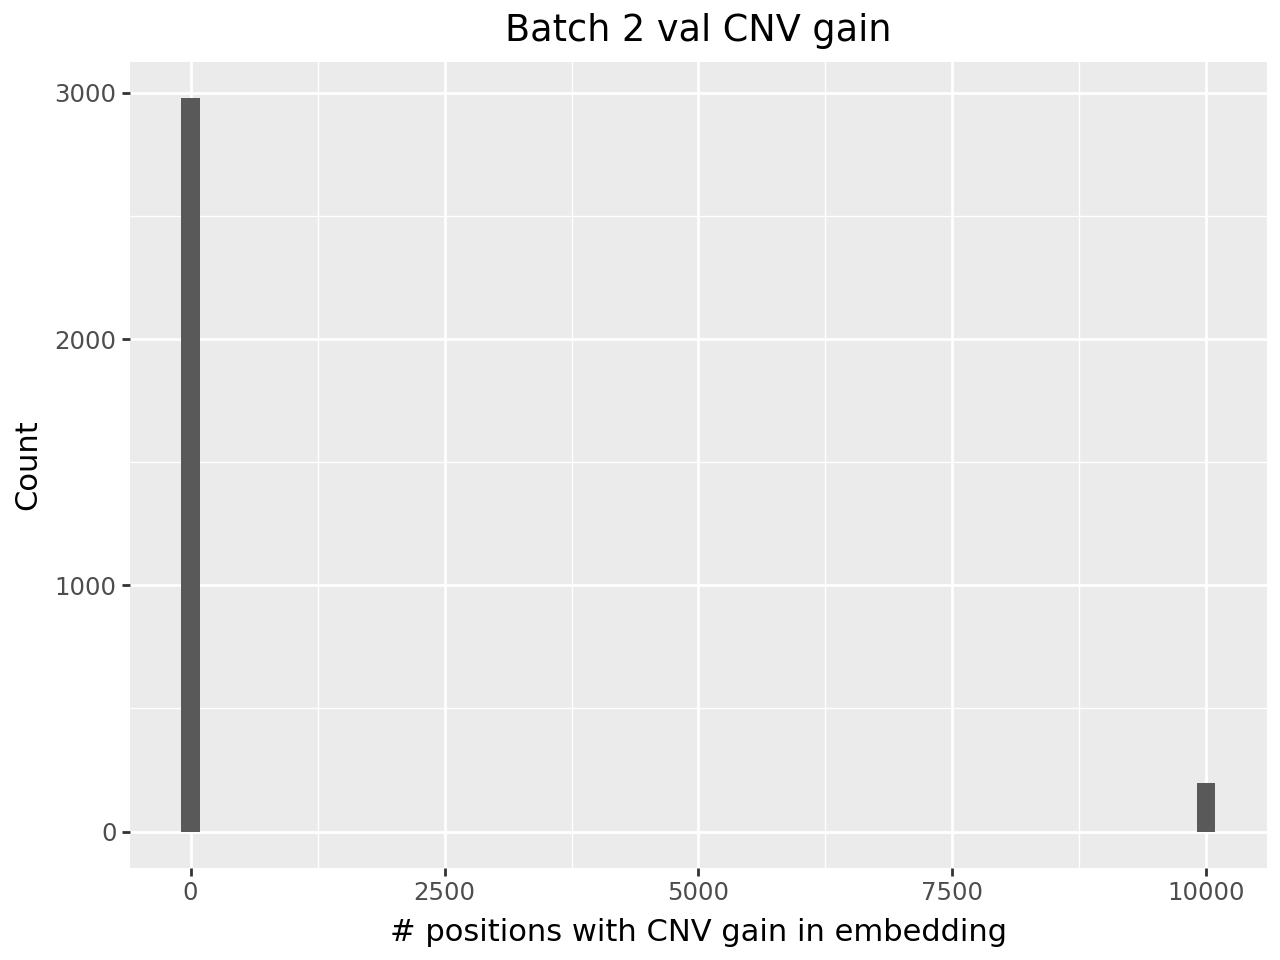

tensor([[2241., 2873., 2807.,  ...,    0.,    0.,    0.],
        [2772., 2269., 2125.,  ...,    0.,    0.,    0.],
        [2906., 2107., 2009.,  ...,    0.,    0.,    0.],
        ...,
        [2488., 2597., 2530.,  ...,    0.,    0.,    0.],
        [2022., 2836., 2857.,  ...,    0.,    0.,    0.],
        [2655., 2459., 2390.,  ...,    0.,    0.,    0.]])

In [ ]:
b2_val_dist_t = plot_dataset_dist(b2_val, name='Batch 2 val')
b2_val_dist_t

In [ ]:
b2_test = CnvDataset(
    root=data_root / 'embeddings' / 'batch_2' / 'test_pt',
    data_df=pd.read_csv(b2_test_path, sep='\t')
)
b2_test

Using 69 barcodes
Using 726 genes
No embedding files for 884 data points in ../data/embeddings/batch_2/test_pt/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 6444 datapoints

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 81'. Pick better value with 'binwidth'.


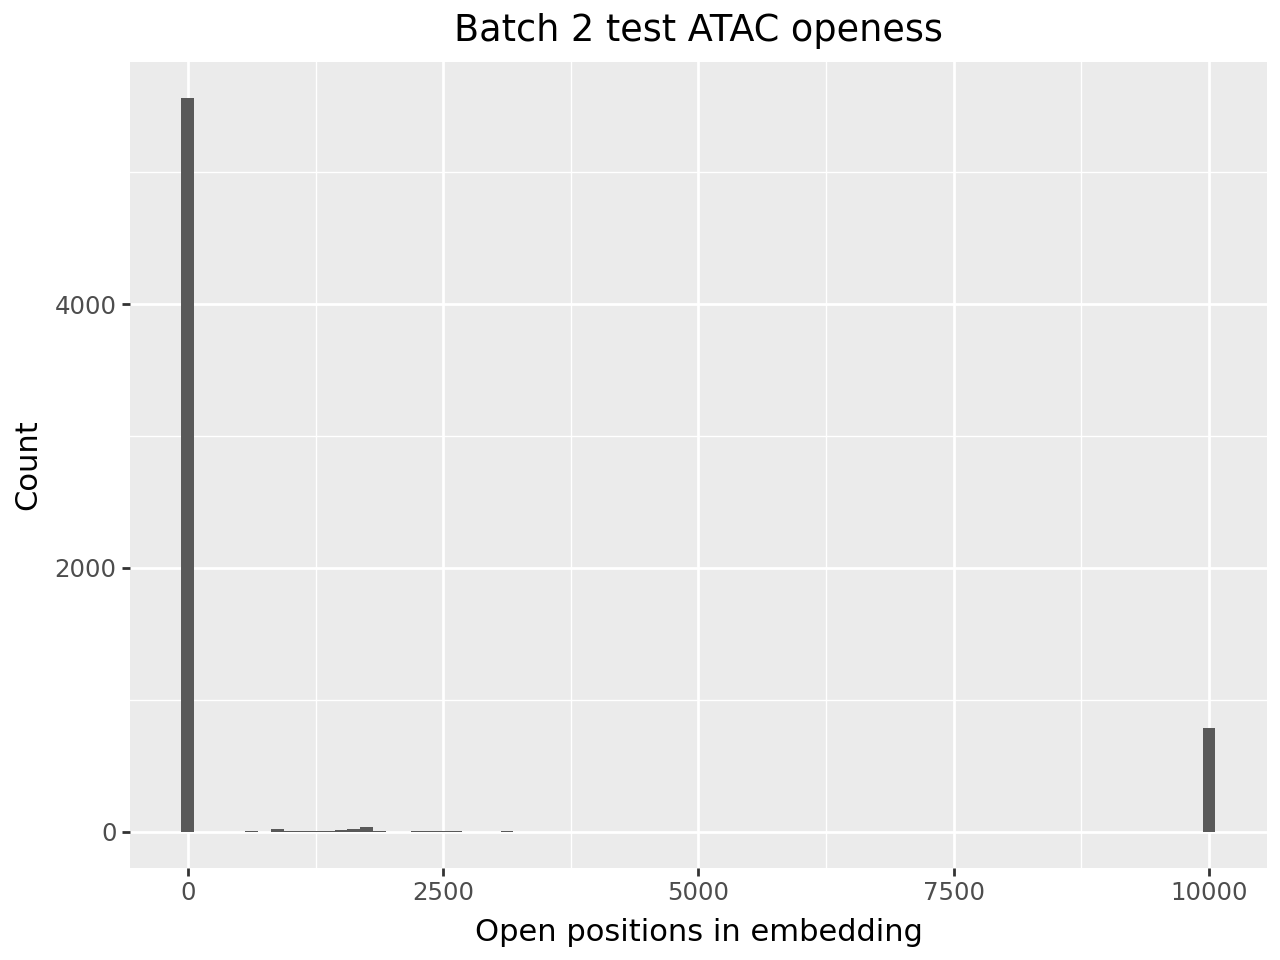

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 81'. Pick better value with 'binwidth'.


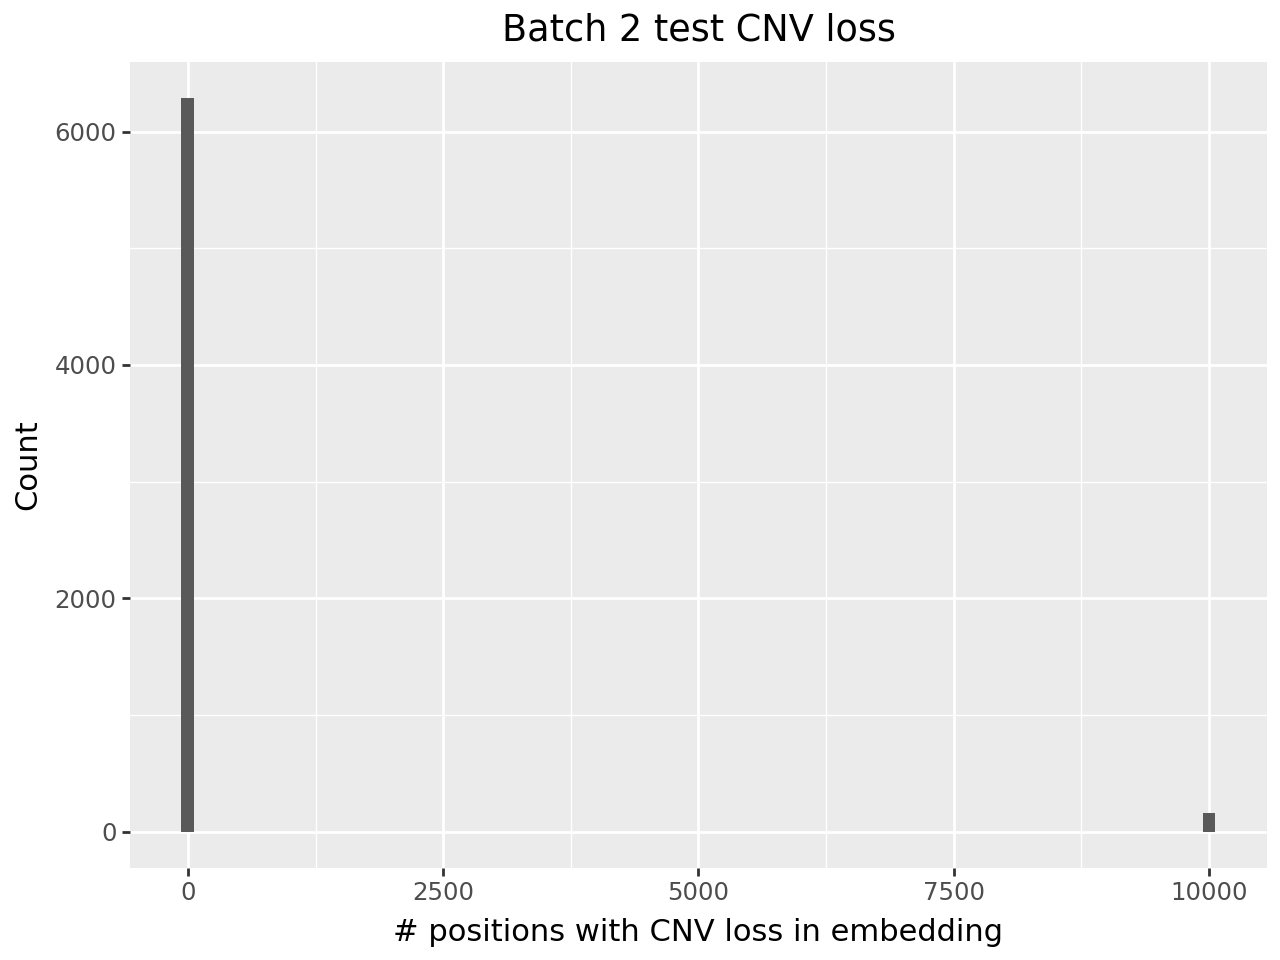

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 81'. Pick better value with 'binwidth'.


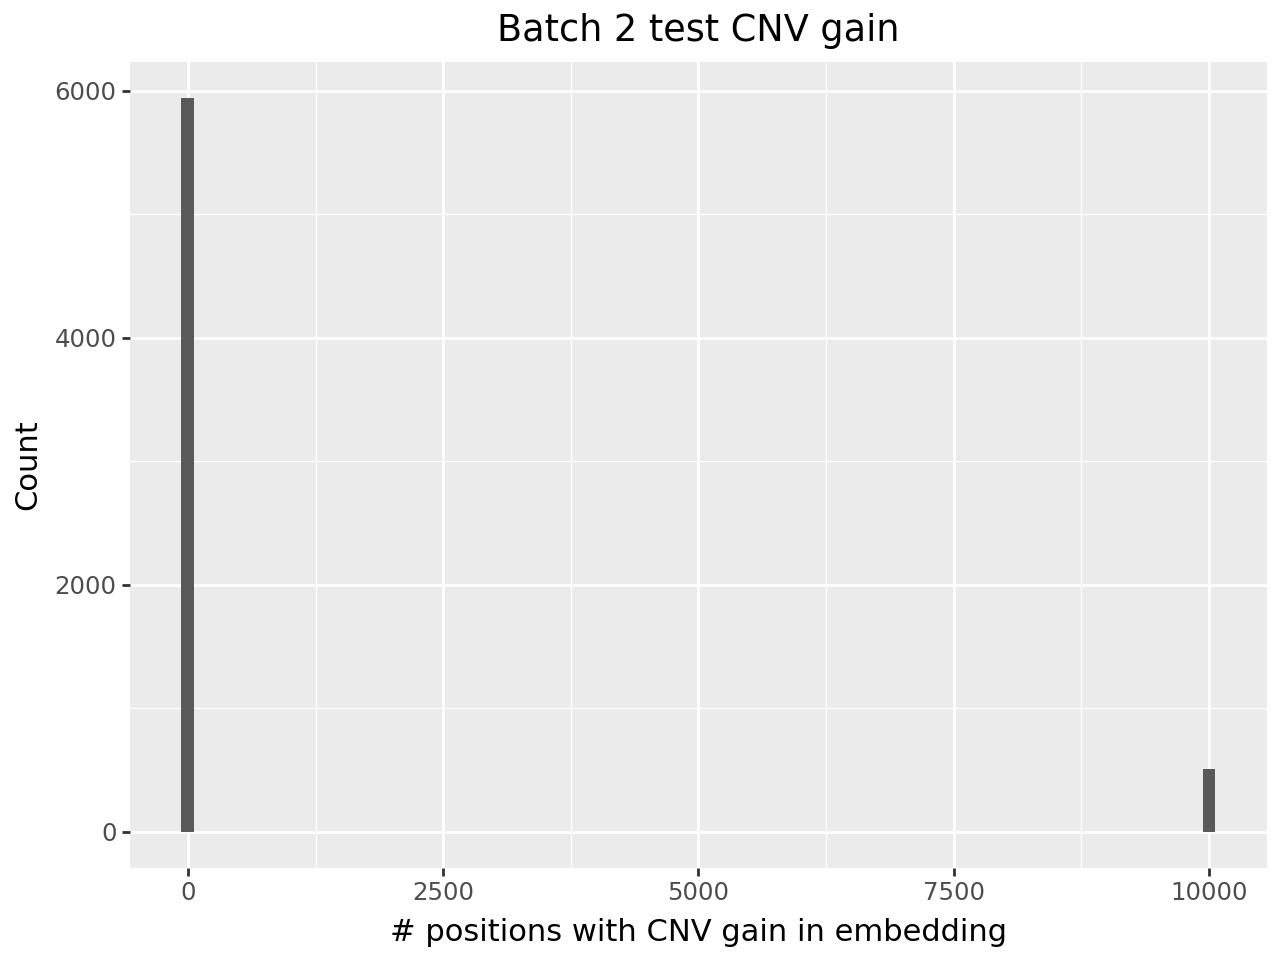

In [ ]:
b2_test_dist_t = plot_dataset_dist(b2_test, name='Batch 2 test')

### Missing data

#### Missing CNV pairs

In [ ]:
grep '/home/marw/cmscb8/preprocessing/../src/data/embedding.py:1160:' log/20250305_batch2_*.err | cut -f 7,9 -d ' ' > log/20250305_batch2_missingCNV.err

SyntaxError: invalid decimal literal (4129314816.py, line 1)

In [ ]:
grep '/home/marw/cmscb8/preprocessing/../src/data/embedding.py:1133:' log/20250304_batch1_*.err | cut -f 7,9 -d ' ' > log/20250304_batch1_missingCNV.err

In [6]:
b1_noCNV_df = pd.read_csv(Path('..') / 'log' / '20250304_batch1_missingCNV.err', names=['barcode', 'gene_id'], sep=' ')
b2_noCNV_df = pd.read_csv(Path('..') / 'log' / '20250305_batch2_missingCNV.err', names=['barcode', 'gene_id'], sep=' ')
b1_noGTF_df = pd.read_csv(data_root / 'preprocessing' / 'batch1_missing_genes.csv')
b2_noGTF_df = pd.read_csv(data_root / 'preprocessing' / 'batch2_missing_genes.csv')

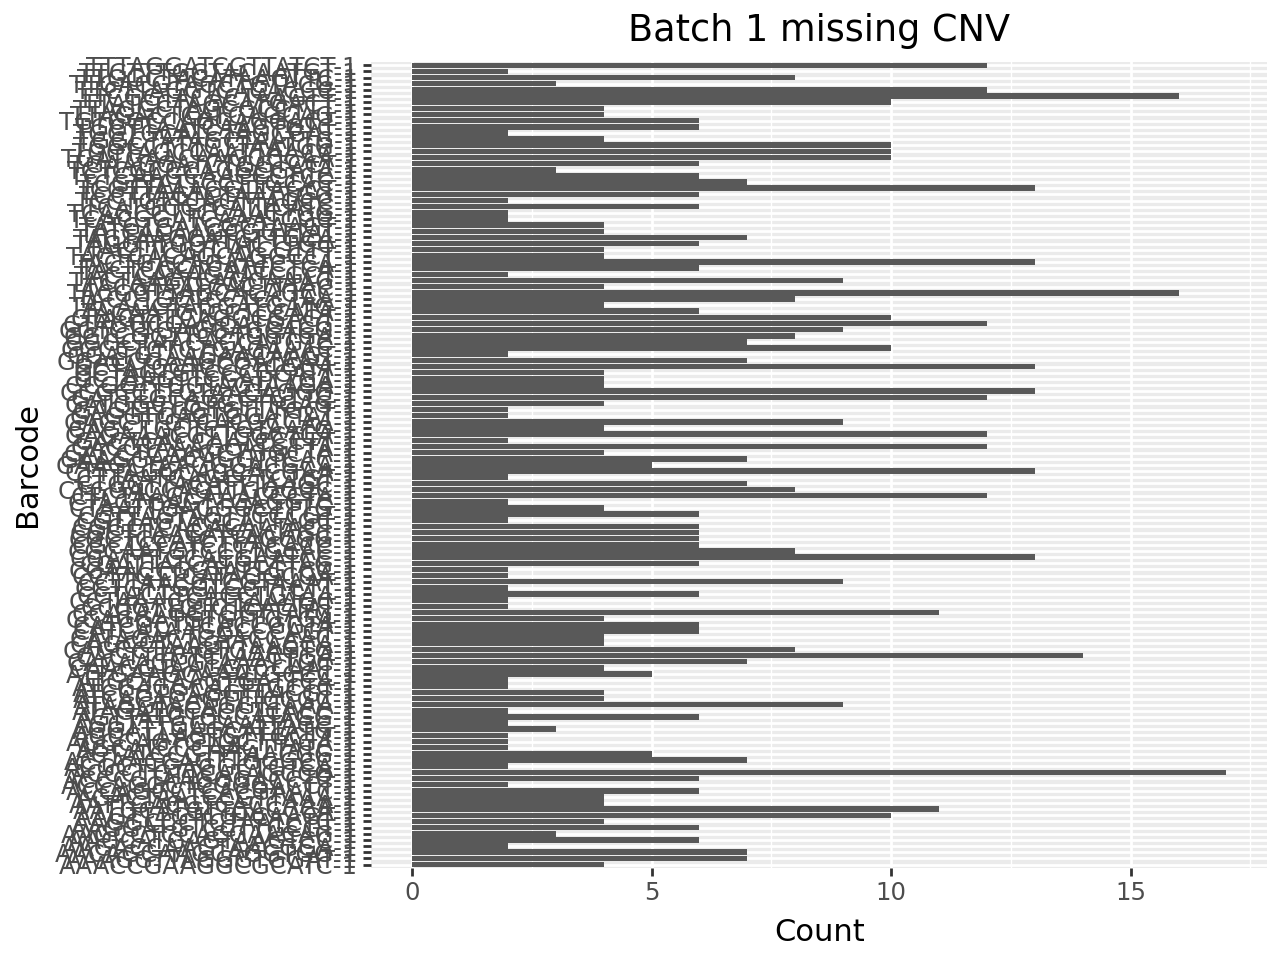

In [ ]:
ggplot(data=b1_noCNV_df) +\
    geom_col(aes(x='barcode'), stat='count') +\
    labs(title='Batch 1 missing CNV', x='Barcode', y='Count') +\
    theme(axis_text_x=element_blank())

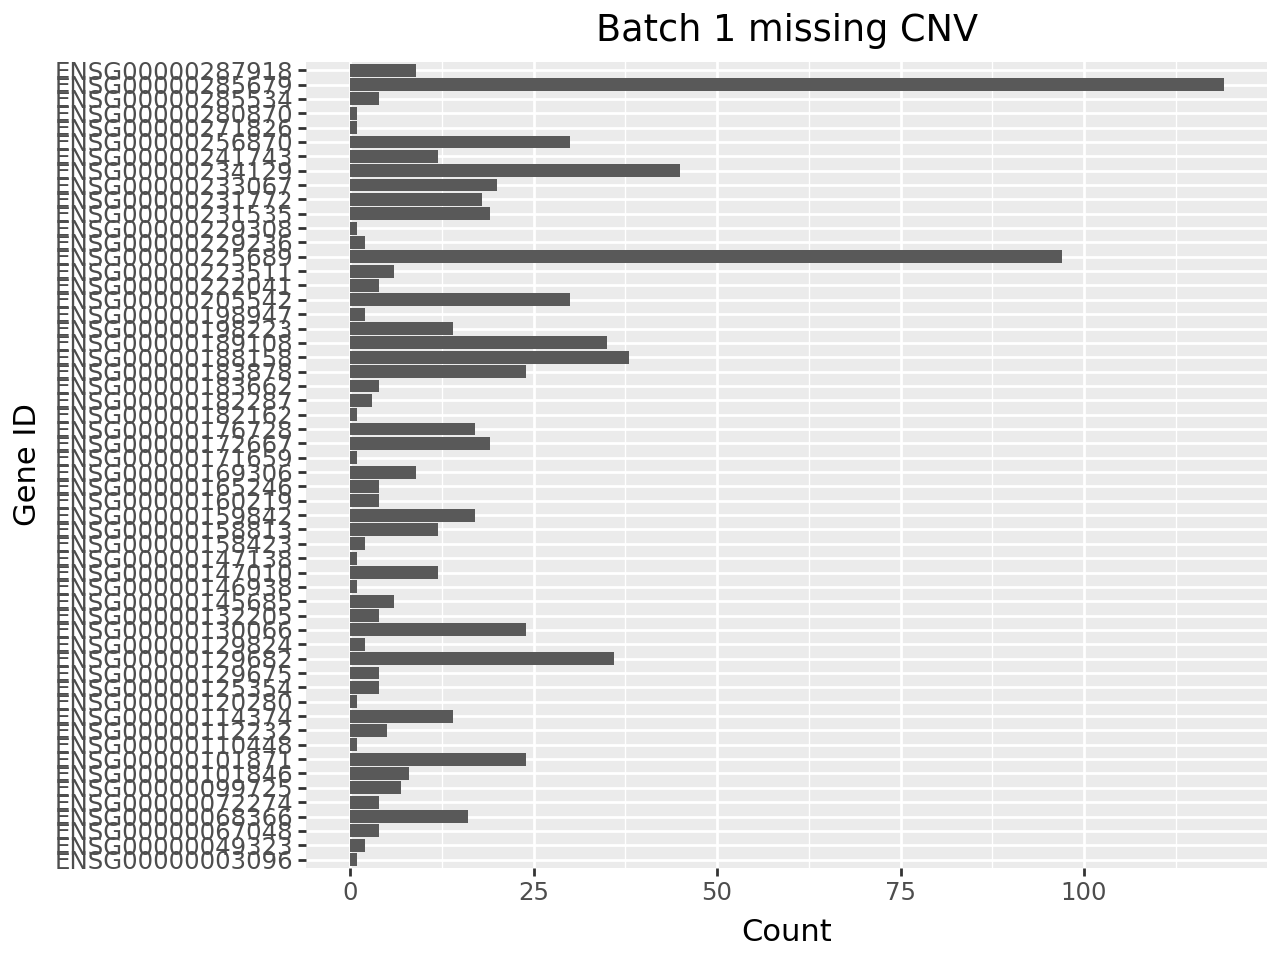

In [47]:
ggplot(data=b1_noCNV_df) +\
    geom_col(aes(x='gene_id'), stat='count') +\
    coord_flip() + labs(title='Batch 1 missing CNV', x='Gene ID', y='Count')

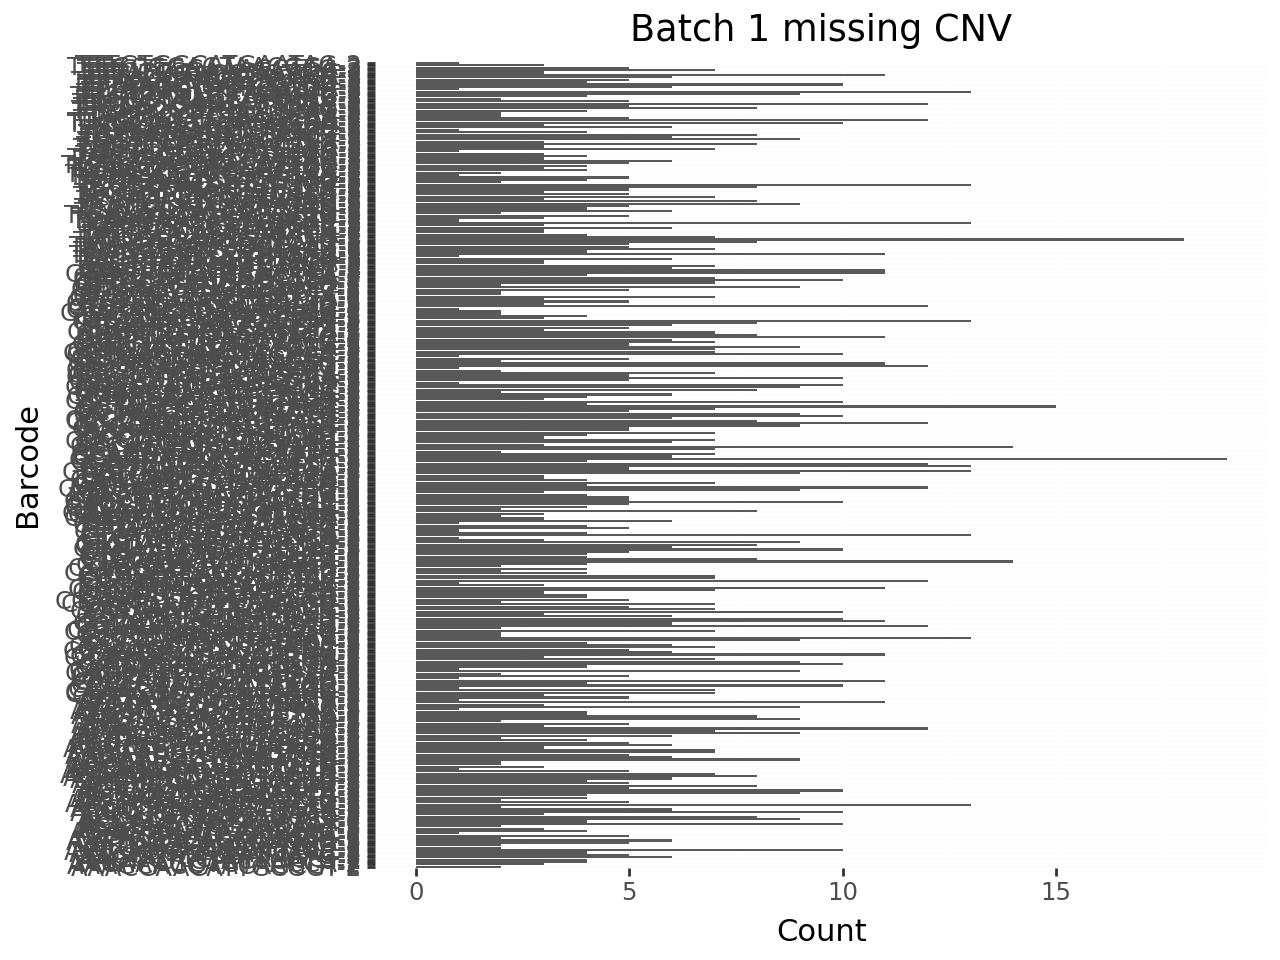

In [ ]:
ggplot(data=b2_noCNV_df) +\
    geom_col(aes(x='barcode'), stat='count') +\
    labs(title='Batch 2 missing CNV', x='Barcode', y='Count') +\
    theme(axis_text_x=element_blank())

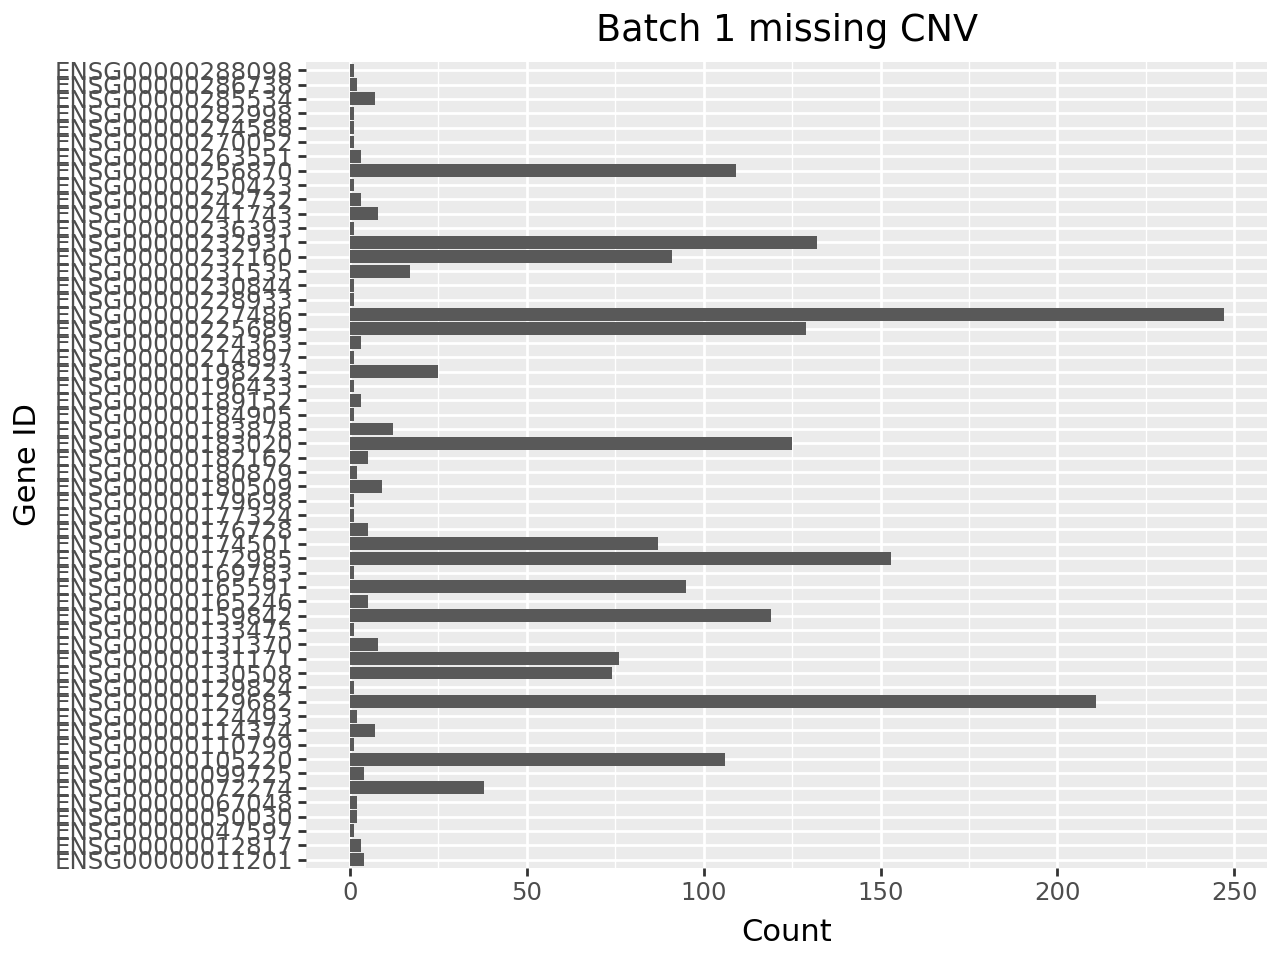

In [ ]:
ggplot(data=b2_noCNV_df) +\
    geom_col(aes(x='gene_id'), stat='count') +\
    coord_flip() + labs(title='Batch 2 missing CNV', x='Gene ID', y='Count')

In [88]:
b1_noGTF_df

gene_id
0    ENSG00000123612
1    ENSG00000204161
2    ENSG00000198727
3    ENSG00000248816
4    ENSG00000180509
..               ...
632  ENSG00000182866
633  ENSG00000132514
634  ENSG00000178562
635  ENSG00000287920
636  ENSG00000280007

[637 rows x 1 columns]

#### Batch 1
Missing data analysis for batch 1.

In [7]:
b1_train_df = pd.read_csv(b1_train_path, sep='\t')
b1_train_df['split'] = 'train'
b1_train = CnvDataset(data_root / 'embeddings' / 'batch_1' / 'train', b1_train_df)
b1_train_df['data status'] = 'missing'
b1_train_df.loc[
    (b1_train_df['barcode'].isin(b1_train.data_df['barcode'])) &
    (b1_train_df['gene_id'].isin(b1_train.data_df['gene_id']))
    ,'data status'] = 'available'
b1_train_df.loc[
    (b1_train_df['gene_id'].isin(b1_noGTF_df['gene_id']))
    ,'data status'] = 'GTF missing'
b1_train_df.loc[
    (b1_train_df['barcode'].isin(b1_noCNV_df['barcode'])) &
    (b1_train_df['gene_id'].isin(b1_noCNV_df['gene_id']))
    ,'data status'] = 'CNV missing'

Using 356 barcodes
Using 1595 genes
No embedding files for 4335 data points in ../data/embeddings/batch_1/train/single_gene_barcode!


In [8]:
b1_train_old_df = pd.read_csv(data_root / 'splits' / 'old_splits' / 'batch1_training.tsv', sep='\t')
b1_train_old_df['split'] = 'train_old'
b1_train_old = CnvDataset(data_root / 'embeddings' / 'batch_1' / 'train', b1_train_old_df)
b1_train_old_df['data status'] = 'missing'
b1_train_old_df.loc[
    (b1_train_old_df['barcode'].isin(b1_train_old.data_df['barcode'])) &
    (b1_train_old_df['gene_id'].isin(b1_train_old.data_df['gene_id']))
    ,'data status'] = 'available'
b1_train_old_df.loc[
    (b1_train_old_df['gene_id'].isin(b1_noGTF_df['gene_id']))
    ,'data status'] = 'GTF missing'
b1_train_old_df.loc[
    (b1_train_old_df['barcode'].isin(b1_noCNV_df['barcode'])) &
    (b1_train_old_df['gene_id'].isin(b1_noCNV_df['gene_id']))
    ,'data status'] = 'CNV missing'

Using 2576 barcodes
Using 1935 genes
No embedding files for 310765 data points in ../data/embeddings/batch_1/train/single_gene_barcode!


In [15]:
def data_to_text(dataset: CnvDataset, data_type: str, emb_length=10_000):
    assert data_type in ('ATAC', 'CNV-', 'CNV+')
    idx = {'ATAC': 4, 'CNV-': 5, 'CNV+': 6}[data_type]
    for e, _ in dataset:
        emb_sum = e.sum(axis=1)[idx]
        if emb_sum == 0:
            yield 'none'
        elif emb_sum == emb_length:
            yield 'part'
        else:
            yield 'full'

In [10]:
b1_val_df = pd.read_csv(b1_val_path, sep='\t')
b1_val_df['split'] = 'val'
b1_val = CnvDataset(data_root / 'embeddings' / 'batch_1' / 'val', b1_val_df)
b1_val_df['data status'] = 'missing'
b1_val_df.loc[
    (b1_val_df['barcode'].isin(b1_val.data_df['barcode'])) &
    (b1_val_df['gene_id'].isin(b1_val.data_df['gene_id']))
    ,'data status'] = 'available'
b1_val_df.loc[
    (b1_val_df['gene_id'].isin(b1_noGTF_df['gene_id']))
    ,'data status'] = 'GTF missing'
b1_val_df.loc[
    (b1_val_df['barcode'].isin(b1_noCNV_df['barcode'])) &
    (b1_val_df['gene_id'].isin(b1_noCNV_df['gene_id']))
    ,'data status'] = 'CNV missing'

# b1_val.data_df['ATAC_status'] = list(data_to_text(b1_val, data_type='ATAC'))
# b1_val.data_df['CNVl_status'] = list(data_to_text(b1_val, data_type='CNV-'))
# b1_val.data_df['CNVg_status'] = list(data_to_text(b1_val, data_type='CNV+'))

# b1_val_df['ATAC_status'] = 'missing'
# b1_val_df['CNVl_status'] = 'missing'
# b1_val_df['CNVg_status'] = 'missing'

# b1_val_df.loc[
#     (b1_val_df['barcode'].isin(b1_val.data_df['barcode'])) &
#     (b1_val_df['gene_id'].isin(b1_val.data_df['gene_id']))
#     ,'ATAC_status'] = 'CNV missing'

Using 51 barcodes
Using 1093 genes
No embedding files for 988 data points in ../data/embeddings/batch_1/val/single_gene_barcode!


In [11]:
b1_val_old_df = pd.read_csv(data_root / 'splits' / 'old_splits' / 'batch1_val.tsv', sep='\t')
b1_val_old_df['split'] = 'val_old'
b1_val_old = CnvDataset(data_root / 'embeddings' / 'batch_1' / 'val', b1_val_old_df)
b1_val_old_df['data status'] = 'missing'
b1_val_old_df.loc[
    (b1_val_old_df['barcode'].isin(b1_val_old.data_df['barcode'])) &
    (b1_val_old_df['gene_id'].isin(b1_val_old.data_df['gene_id']))
    ,'data status'] = 'available'
b1_val_old_df.loc[
    (b1_val_old_df['gene_id'].isin(b1_noGTF_df['gene_id']))
    ,'data status'] = 'GTF missing'
b1_val_old_df.loc[
    (b1_val_old_df['barcode'].isin(b1_noCNV_df['barcode'])) &
    (b1_val_old_df['gene_id'].isin(b1_noCNV_df['gene_id']))
    ,'data status'] = 'CNV missing'

Using 368 barcodes
Using 1451 genes
No embedding files for 48309 data points in ../data/embeddings/batch_1/val/single_gene_barcode!


In [12]:
b1_test_df = pd.read_csv(b1_test_path, sep='\t')
b1_test_df['split'] = 'test'
b1_test = CnvDataset(data_root / 'embeddings' / 'batch_1' / 'test', b1_test_df)
b1_test_df['data status'] = 'missing'
b1_test_df.loc[
    (b1_test_df['barcode'].isin(b1_test.data_df['barcode'])) &
    (b1_test_df['gene_id'].isin(b1_test.data_df['gene_id']))
    ,'data status'] = 'available'
b1_test_df.loc[
    (b1_test_df['gene_id'].isin(b1_noGTF_df['gene_id']))
    ,'data status'] = 'GTF missing'
b1_test_df.loc[
    (b1_test_df['barcode'].isin(b1_noCNV_df['barcode'])) &
    (b1_test_df['gene_id'].isin(b1_noCNV_df['gene_id']))
    ,'data status'] = 'CNV missing'

Using 102 barcodes
Using 1235 genes
No embedding files for 2149 data points in ../data/embeddings/batch_1/test/single_gene_barcode!


In [14]:
b1_test_old_df = pd.read_csv(data_root / 'splits' / 'old_splits' / 'batch1_test.tsv', sep='\t')
b1_test_old_df['split'] = 'test_old'
b1_test_old = CnvDataset(data_root / 'embeddings' / 'batch_1' / 'test', b1_test_old_df)
b1_test_old_df['data status'] = 'missing'
b1_test_old_df.loc[
    (b1_test_old_df['barcode'].isin(b1_test_old.data_df['barcode'])) &
    (b1_test_old_df['gene_id'].isin(b1_test_old.data_df['gene_id']))
    ,'data status'] = 'available'
b1_test_old_df.loc[
    (b1_test_old_df['gene_id'].isin(b1_noGTF_df['gene_id']))
    ,'data status'] = 'GTF missing'
b1_test_old_df.loc[
    (b1_test_old_df['barcode'].isin(b1_noCNV_df['barcode'])) &
    (b1_test_old_df['gene_id'].isin(b1_noCNV_df['gene_id']))
    ,'data status'] = 'CNV missing'
b1_test_ol_df = b1_test_old_df[b1_test_old_df['classification'] != 'zero']

Using 737 barcodes
Using 2000 genes
No embedding files for 1469405 data points in ../data/embeddings/batch_1/test/single_gene_barcode!


In [15]:
b1_df = pd.concat([b1_train_df, b1_val_df, b1_test_df, b1_train_old_df, b1_val_old_df, b1_test_ol_df])
b1_df

barcode          gene_id  expression_count classification  \
0        AAACCAACATGTCAGC-1  ENSG00000269113          0.749940            low   
1        AAACCAACATGTCAGC-1  ENSG00000229956          1.173642           high   
2        AAACCAACATGTCAGC-1  ENSG00000237505          0.749940            low   
3        AAACCAACATGTCAGC-1  ENSG00000188641          0.749940            low   
4        AAACCAACATGTCAGC-1  ENSG00000162636          0.749940            low   
...                     ...              ...               ...            ...   
1473994  TTTGTCTAGTCACTAA-1  ENSG00000198899          1.426412           high   
1473995  TTTGTCTAGTCACTAA-1  ENSG00000198938          1.426412           high   
1473996  TTTGTCTAGTCACTAA-1  ENSG00000198840          1.134351           high   
1473997  TTTGTCTAGTCACTAA-1  ENSG00000198886          0.720070            low   
1473999  TTTGTCTAGTCACTAA-1  ENSG00000198727          0.720070            low   

            split                                     embedding_path  \
0           train  ../data/embeddings/batch_1/train/single_gene_b...   
1           train  ../data/embeddings/batch_1/train/single_gene_b...   
2           train  ../data/embeddings/batch_1/train/single_gene_b...   
3           train  ../data/embeddings/batch_1/train/single_gene_b...   
4           train  ../data/embeddings/batch_1/train/single_gene_b...   
...           ...                                                ...   
1473994  test_old  ../data/embeddings/batch_1/test/single_gene_ba...   
1473995  test_old  ../data/embeddings/batch_1/test/single_gene_ba...   
1473996  test_old  ../data/embeddings/batch_1/test/single_gene_ba...   
1473997  test_old  ../data/embeddings/batch_1/test/single_gene_ba...   
1473999  test_old  ../data/embeddings/batch_1/test/single_gene_ba...   

         data status  
0          available  
1          available  
2          available  
3          available  
4          available  
...              ...  
1473994  GTF missing  
1473995  GTF missing  
1473996  GTF missing  
1473997  GTF missing  
1473999  GTF missing  

[585472 rows x 7 columns]

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch1_data_status_old_new_overview.png


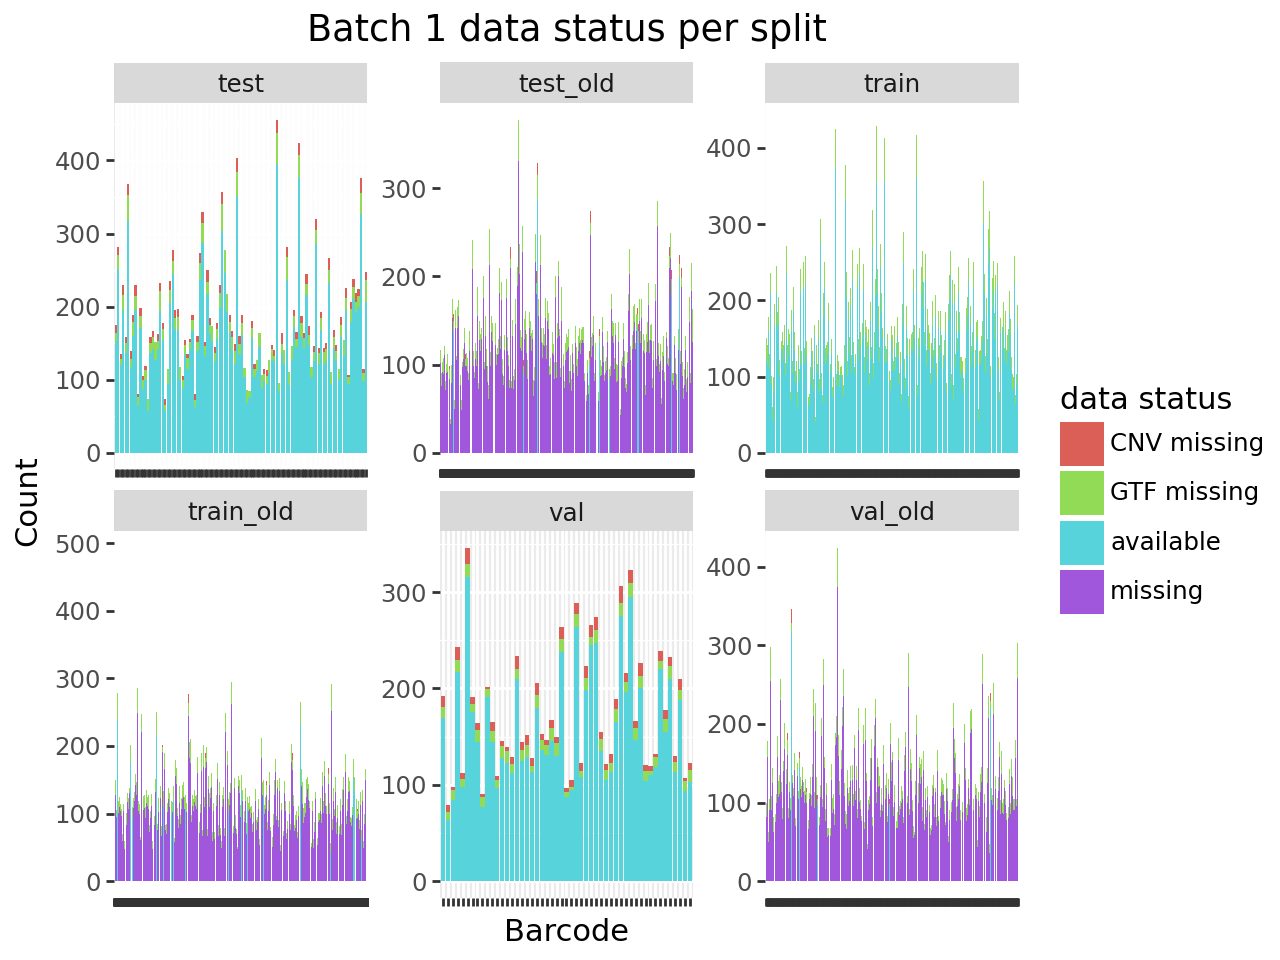

In [16]:
p = ggplot(data=b1_df, mapping=aes(x='barcode',fill='data status')) +\
    geom_col(stat='count') +\
    facet_wrap('~split', scales='free') +\
    labs(title='Batch 1 data status per split', x='Barcode', y='Count') +\
    theme(axis_text_x=element_blank())
ggsave(p, plot_root / 'dataset' / 'batch1_data_status_old_new_overview.png')
p.show()

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch1_class_balance_old_new_overview.png


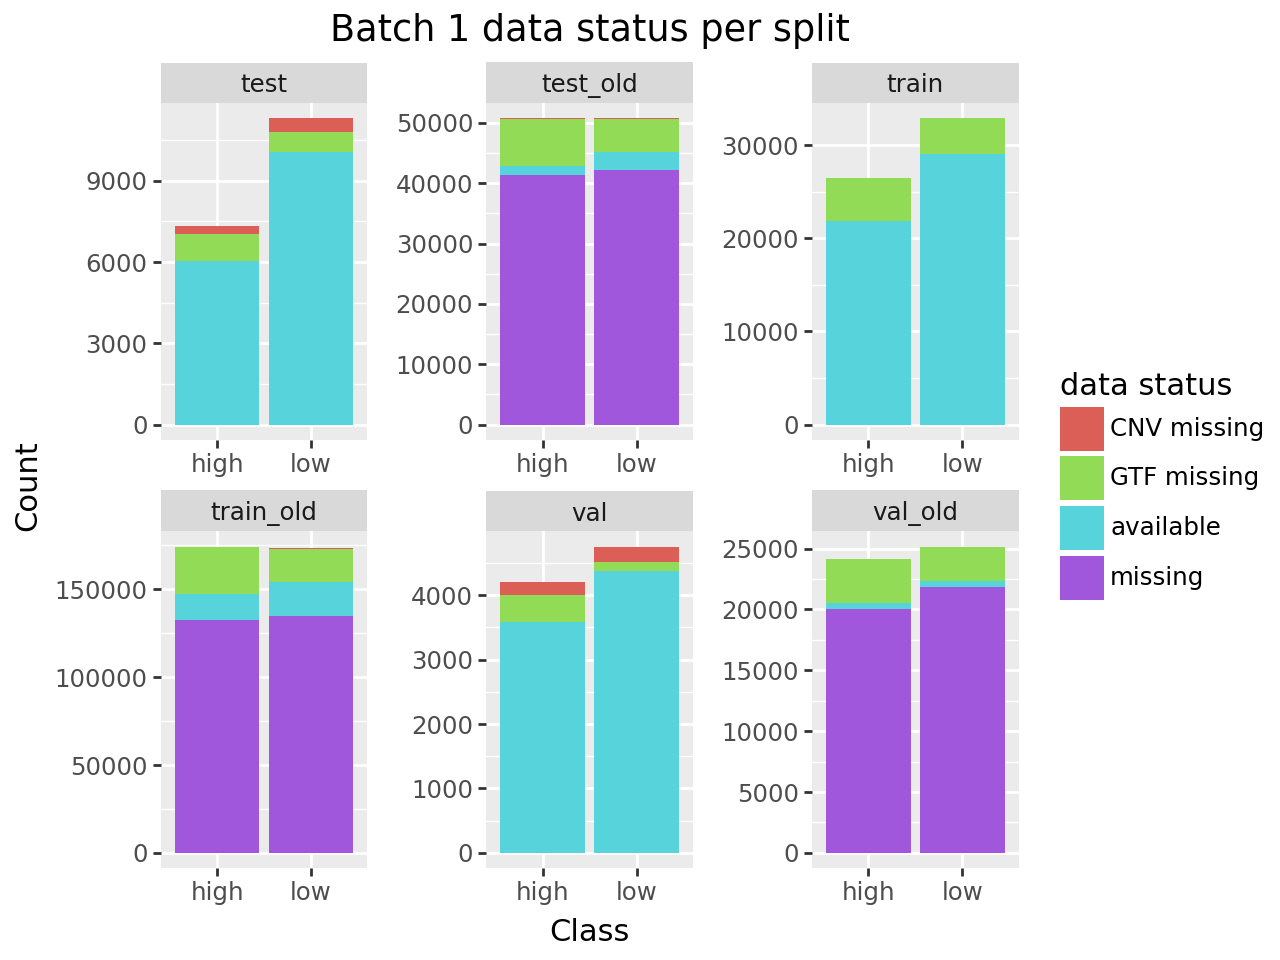

In [17]:
p = ggplot(data=b1_df, mapping=aes(x='classification',fill='data status')) +\
    geom_col(stat='count') +\
    facet_wrap('~split', scales='free') +\
    labs(title='Batch 1 data status per split', x='Class', y='Count')
ggsave(p, plot_root / 'dataset' / 'batch1_class_balance_old_new_overview.png')
p.show()

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch1_train_data_status.png


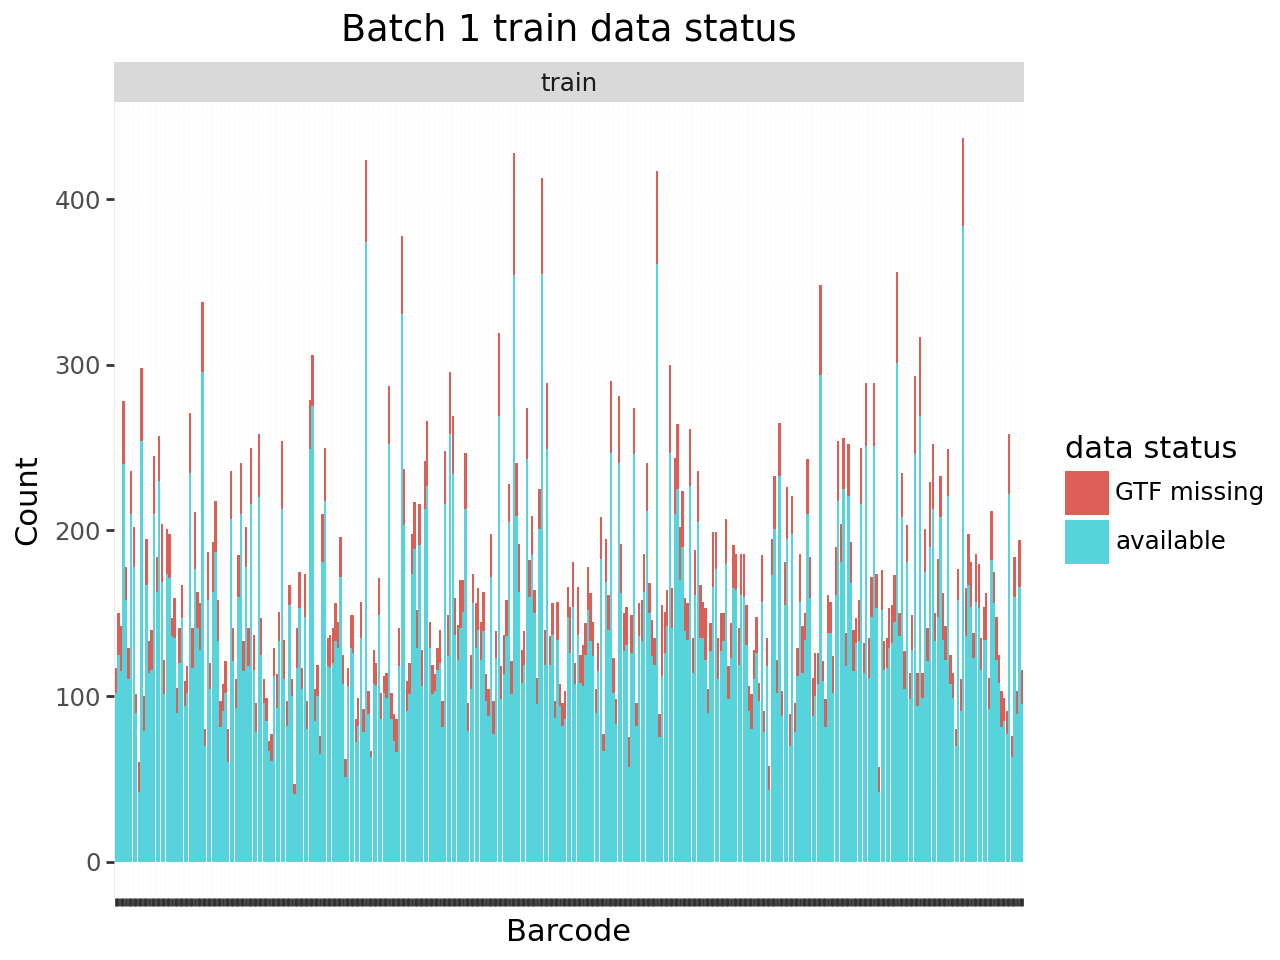

In [18]:
p = ggplot(data=b1_df[b1_df['split'] == 'train'], mapping=aes(x='barcode',fill='data status')) +\
    geom_col(stat='count') +\
    facet_wrap('~split') +\
    labs(title='Batch 1 train data status', x='Barcode', y='Count') +\
    theme(axis_text_x=element_blank())
ggsave(p, plot_root / 'dataset' / 'batch1_train_data_status.png')
p.show()

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch1_val_data_status.png


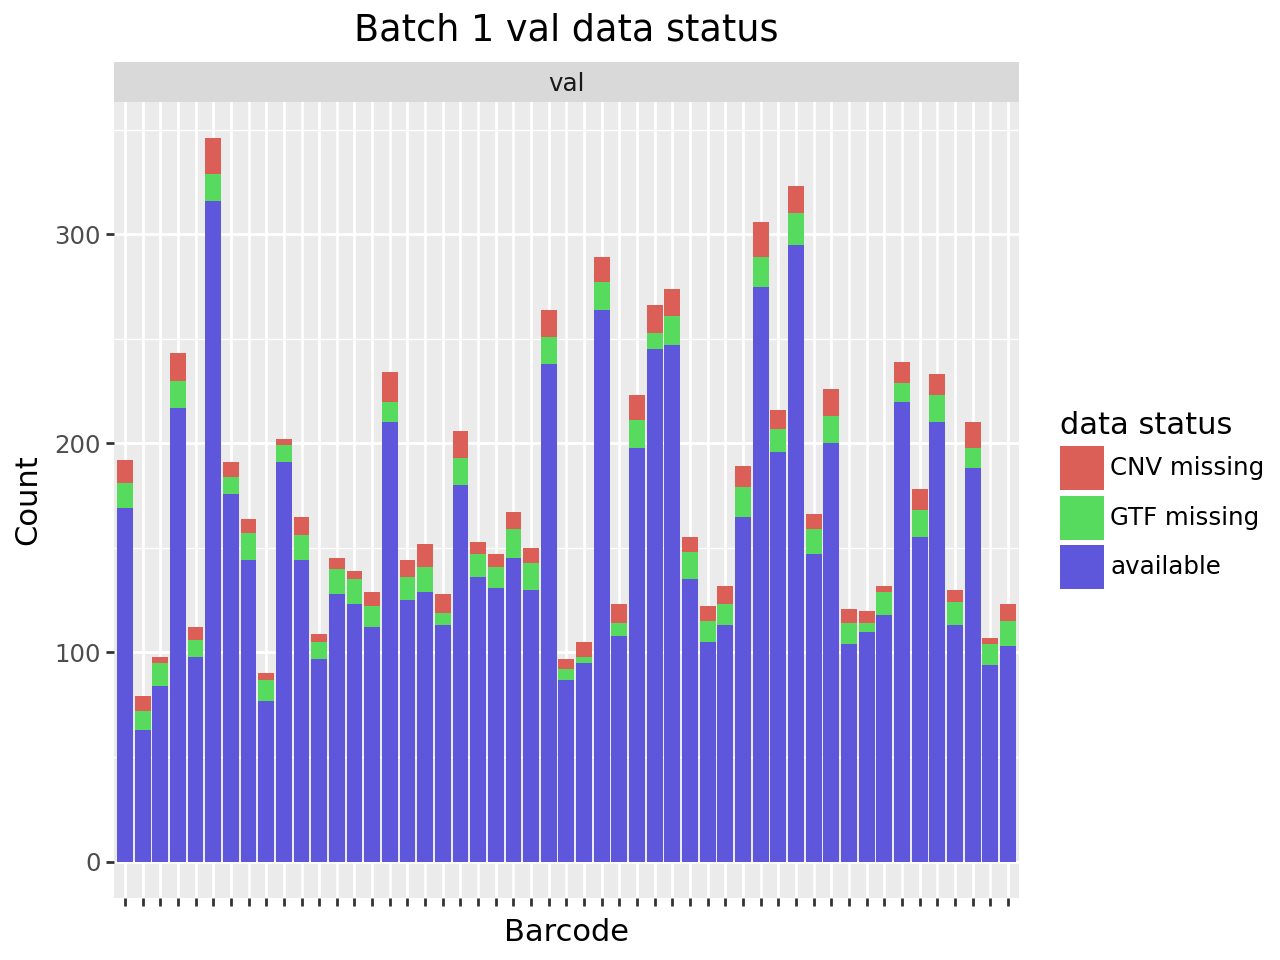

In [19]:
p = ggplot(data=b1_df[b1_df['split'] == 'val'], mapping=aes(x='barcode',fill='data status')) +\
    geom_col(stat='count') +\
    facet_wrap('~split') +\
    labs(title='Batch 1 val data status', x='Barcode', y='Count') +\
    theme(axis_text_x=element_blank())
ggsave(p, plot_root / 'dataset' / 'batch1_val_data_status.png')
p.show()

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch1_test_data_status.png


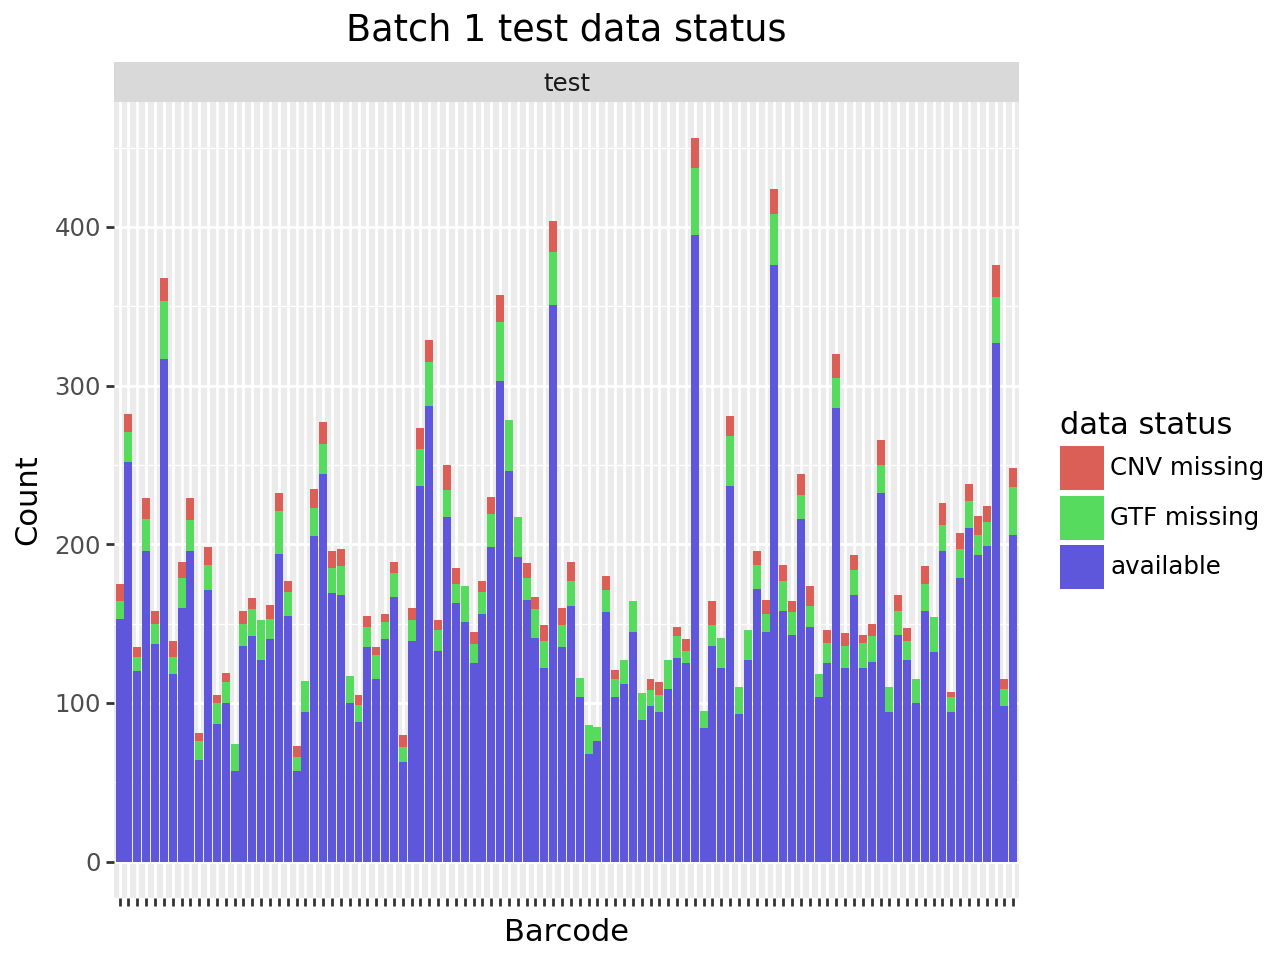

In [20]:
p = ggplot(data=b1_df[b1_df['split'] == 'test'], mapping=aes(x='barcode',fill='data status')) +\
    geom_col(stat='count') +\
    facet_wrap('~split') +\
    labs(title='Batch 1 test data status', x='Barcode', y='Count') +\
    theme(axis_text_x=element_blank())
ggsave(p, plot_root / 'dataset' / 'batch1_test_data_status.png')
p.show()

#### Batch 2
Missing data analysis for batch 2.

In [26]:
b2_train_df = pd.read_csv(b2_train_path, sep='\t')
b2_train_df['split'] = 'train'
b2_train = CnvDataset(data_root / 'embeddings' / 'batch_2' / 'train', b2_train_df)
b2_train_df['data status'] = 'missing'
b2_train_df.loc[
    (b2_train_df['barcode'].isin(b2_train.data_df['barcode'])) &
    (b2_train_df['gene_id'].isin(b2_train.data_df['gene_id']))
    ,'data status'] = 'available'
b2_train_df.loc[
    (b2_train_df['gene_id'].isin(b2_noGTF_df['gene_id']))
    ,'data status'] = 'GTF missing'
b2_train_df.loc[
    (b2_train_df['barcode'].isin(b2_noCNV_df['barcode'])) &
    (b2_train_df['gene_id'].isin(b2_noCNV_df['gene_id']))
    ,'data status'] = 'CNV missing'

Using 239 barcodes
Using 1217 genes
No embedding files for 2835 data points in ../data/embeddings/batch_2/train/single_gene_barcode!


In [38]:
b2_train_old_df = pd.read_csv(data_root / 'splits' / 'old_splits' / 'batch2_training.tsv', sep='\t')
b2_train_old_df['split'] = 'train_old'
b2_train_old = CnvDataset(data_root / 'embeddings' / 'batch_2' / 'train', b2_train_old_df)
b2_train_old_df['data status'] = 'missing'
b2_train_old_df.loc[
    (b2_train_old_df['barcode'].isin(b2_train_old.data_df['barcode'])) &
    (b2_train_old_df['gene_id'].isin(b2_train_old.data_df['gene_id']))
    ,'data status'] = 'available'
b2_train_old_df.loc[
    (b2_train_old_df['gene_id'].isin(b2_noGTF_df['gene_id']))
    ,'data status'] = 'GTF missing'
b2_train_old_df.loc[
    (b2_train_old_df['barcode'].isin(b2_noCNV_df['barcode'])) &
    (b2_train_old_df['gene_id'].isin(b2_noCNV_df['gene_id']))
    ,'data status'] = 'CNV missing'

Using 4005 barcodes
Using 1896 genes
No embedding files for 405132 data points in ../data/embeddings/batch_2/train/single_gene_barcode!


In [27]:
b2_val_df = pd.read_csv(b2_val_path, sep='\t')
b2_val_df['split'] = 'val'
b2_val = CnvDataset(data_root / 'embeddings' / 'batch_2' / 'val', b2_val_df)
b2_val_df['data status'] = 'missing'
b2_val_df.loc[
    (b2_val_df['barcode'].isin(b2_val.data_df['barcode'])) &
    (b2_val_df['gene_id'].isin(b2_val.data_df['gene_id']))
    ,'data status'] = 'available'
b2_val_df.loc[
    (b2_val_df['gene_id'].isin(b2_noGTF_df['gene_id']))
    ,'data status'] = 'GTF missing'
b2_val_df.loc[
    (b2_val_df['barcode'].isin(b2_noCNV_df['barcode'])) &
    (b2_val_df['gene_id'].isin(b2_noCNV_df['gene_id']))
    ,'data status'] = 'CNV missing'

Using 35 barcodes
Using 621 genes
No embedding files for 426 data points in ../data/embeddings/batch_2/val/single_gene_barcode!


In [46]:
b2_val_old_df = pd.read_csv(data_root / 'splits' / 'old_splits' / 'batch2_val.tsv', sep='\t')
b2_val_old_df['split'] = 'val_old'
b2_val_old = CnvDataset(data_root / 'embeddings' / 'batch_2' / 'val', b2_val_old_df)
b2_val_old_df['data status'] = 'missing'
b2_val_old_df.loc[
    (b2_val_old_df['barcode'].isin(b2_val_old.data_df['barcode'])) &
    (b2_val_old_df['gene_id'].isin(b2_val_old.data_df['gene_id']))
    ,'data status'] = 'available'
b2_val_old_df.loc[
    (b2_val_old_df['gene_id'].isin(b2_noGTF_df['gene_id']))
    ,'data status'] = 'GTF missing'
b2_val_old_df.loc[
    (b2_val_old_df['barcode'].isin(b2_noCNV_df['barcode'])) &
    (b2_val_old_df['gene_id'].isin(b2_noCNV_df['gene_id']))
    ,'data status'] = 'CNV missing'

Using 573 barcodes
Using 1237 genes
No embedding files for 59337 data points in ../data/embeddings/batch_2/val/single_gene_barcode!


In [28]:
b2_test_df = pd.read_csv(b2_test_path, sep='\t')
b2_test_df['split'] = 'test'
b2_test = CnvDataset(data_root / 'embeddings' / 'batch_2' / 'test', b2_test_df)
b2_test_df['data status'] = 'missing'
b2_test_df.loc[
    (b2_test_df['barcode'].isin(b2_test.data_df['barcode'])) &
    (b2_test_df['gene_id'].isin(b2_test.data_df['gene_id']))
    ,'data status'] = 'available'
b2_test_df.loc[
    (b2_test_df['gene_id'].isin(b2_noGTF_df['gene_id']))
    ,'data status'] = 'GTF missing'
b2_test_df.loc[
    (b2_test_df['barcode'].isin(b2_noCNV_df['barcode'])) &
    (b2_test_df['gene_id'].isin(b2_noCNV_df['gene_id']))
    ,'data status'] = 'CNV missing'

Using 69 barcodes
Using 726 genes
No embedding files for 884 data points in ../data/embeddings/batch_2/test/single_gene_barcode!


In [52]:
b2_test_old_df = pd.read_csv(data_root / 'splits' / 'old_splits' / 'batch2_test.tsv', sep='\t')
b2_test_old_df['split'] = 'test_old'
b2_test_old = CnvDataset(data_root / 'embeddings' / 'batch_2' / 'test', b2_test_old_df)
b2_test_old_df['data status'] = 'missing'
b2_test_old_df.loc[
    (b2_test_old_df['barcode'].isin(b2_test_old.data_df['barcode'])) &
    (b2_test_old_df['gene_id'].isin(b2_test_old.data_df['gene_id']))
    ,'data status'] = 'available'
b2_test_old_df.loc[
    (b2_test_old_df['gene_id'].isin(b2_noGTF_df['gene_id']))
    ,'data status'] = 'GTF missing'
b2_test_old_df.loc[
    (b2_test_old_df['barcode'].isin(b2_noCNV_df['barcode'])) &
    (b2_test_old_df['gene_id'].isin(b2_noCNV_df['gene_id']))
    ,'data status'] = 'CNV missing'
b2_test_ol_df = b2_test_old_df[b2_test_old_df['classification'] != 'zero']

Using 1145 barcodes
Using 2000 genes
No embedding files for 2288777 data points in ../data/embeddings/batch_2/test/single_gene_barcode!


In [57]:
b2_df = pd.concat(
    [b2_train_df, b2_val_df, b2_test_df,
     b2_train_old_df, b2_val_old_df, b2_test_old_df
    ])

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch2_data_status_split.png


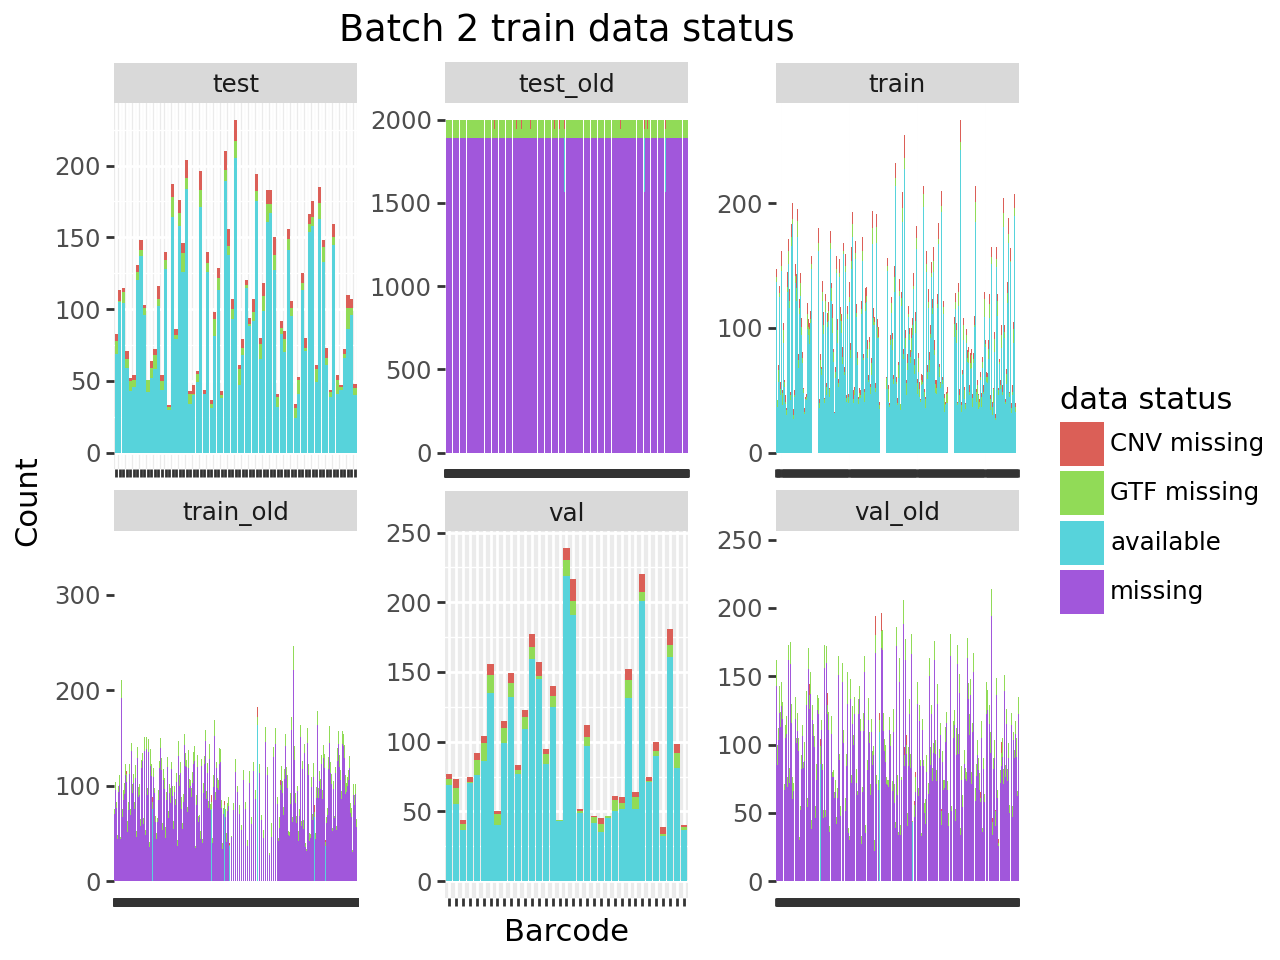

In [50]:
p = ggplot(data=b2_df, mapping=aes(x='barcode',fill='data status')) +\
    geom_col(stat='count') +\
    facet_wrap('~split', scales='free') +\
    labs(title='Batch 2 train data status', x='Barcode', y='Count') +\
    theme(axis_text_x=element_blank())
ggsave(p, plot_root / 'dataset' / 'batch2_data_status_split.png')
p.show()

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch2_class_balance_old_new_with_zero.png


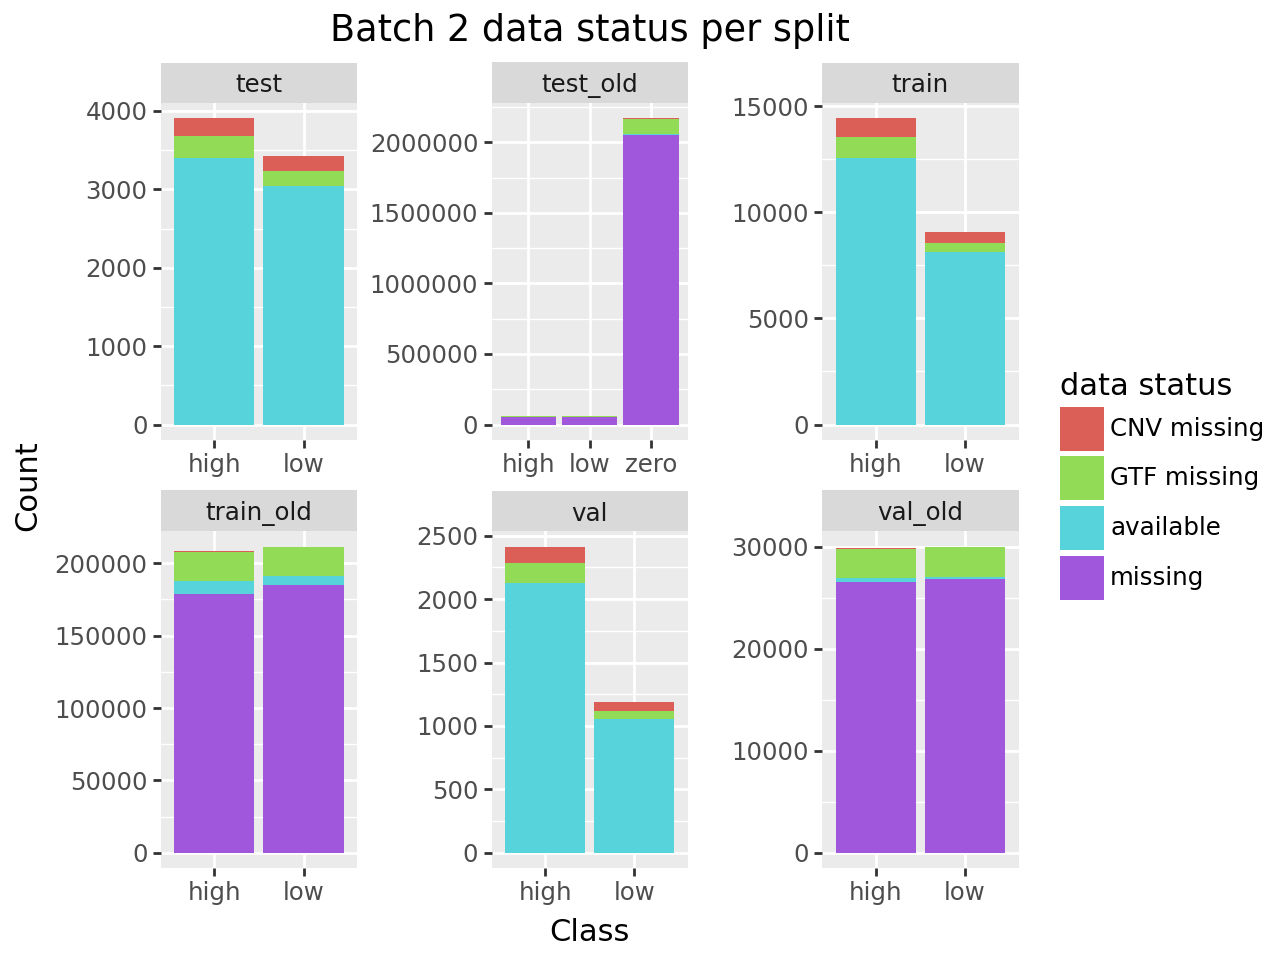

In [58]:
p = ggplot(data=b2_df, mapping=aes(x='classification',fill='data status')) +\
    geom_col(stat='count') +\
    facet_wrap('~split', scales='free') +\
    labs(title='Batch 2 data status per split', x='Class', y='Count')
ggsave(p, plot_root / 'dataset' / 'batch2_class_balance_old_new_with_zero.png')
p.show()

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch2_train_data_status.png


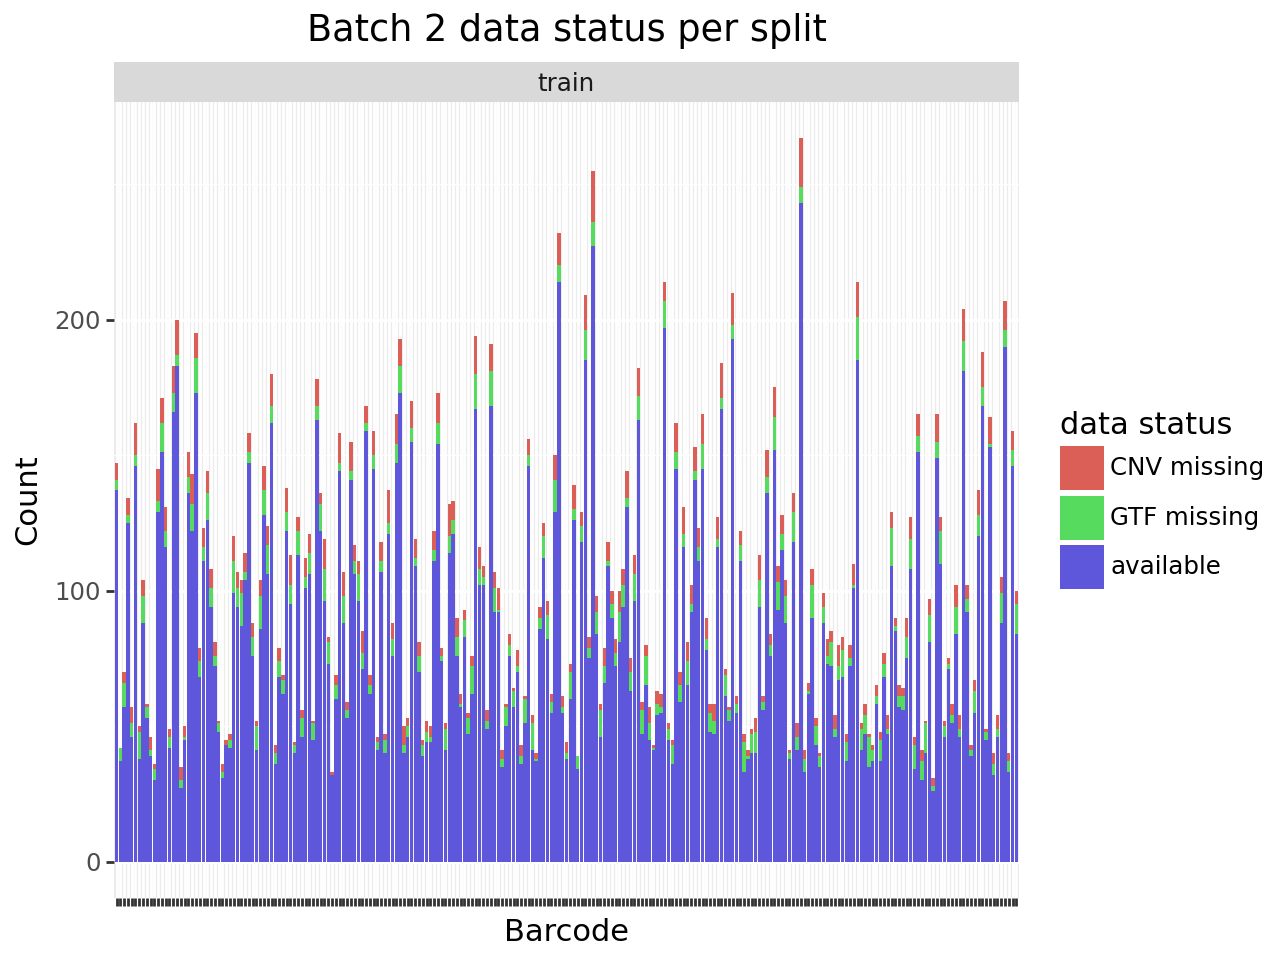

In [60]:
p = ggplot(data=b2_df[b2_df['split'] == 'train'], mapping=aes(x='barcode',fill='data status')) +\
    geom_col(stat='count') +\
    facet_wrap('~split') +\
    labs(title='Batch 2 data status per split', x='Barcode', y='Count') +\
    theme(axis_text_x=element_blank())
ggsave(p, plot_root / 'dataset' / 'batch2_train_data_status.png')
p.show()

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch2_val_data_status.png


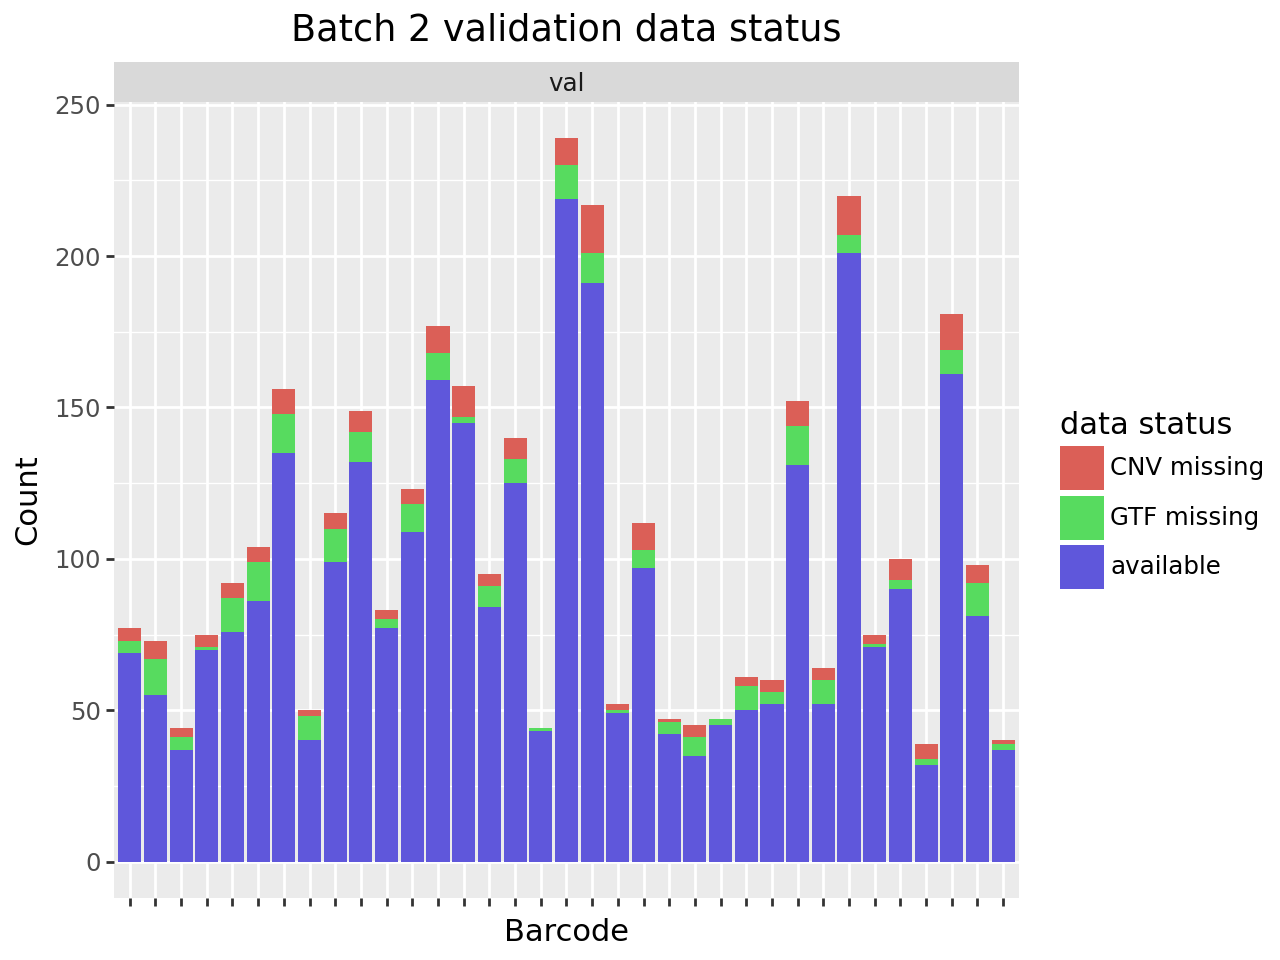

In [61]:
p = ggplot(data=b2_df[b2_df['split'] == 'val'], mapping=aes(x='barcode',fill='data status')) +\
    geom_col(stat='count') +\
    facet_wrap('~split') +\
    labs(title='Batch 2 validation data status', x='Barcode', y='Count') +\
    theme(axis_text_x=element_blank())
ggsave(p, plot_root / 'dataset' / 'batch2_val_data_status.png')
p.show()

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch2_test_data_status.png


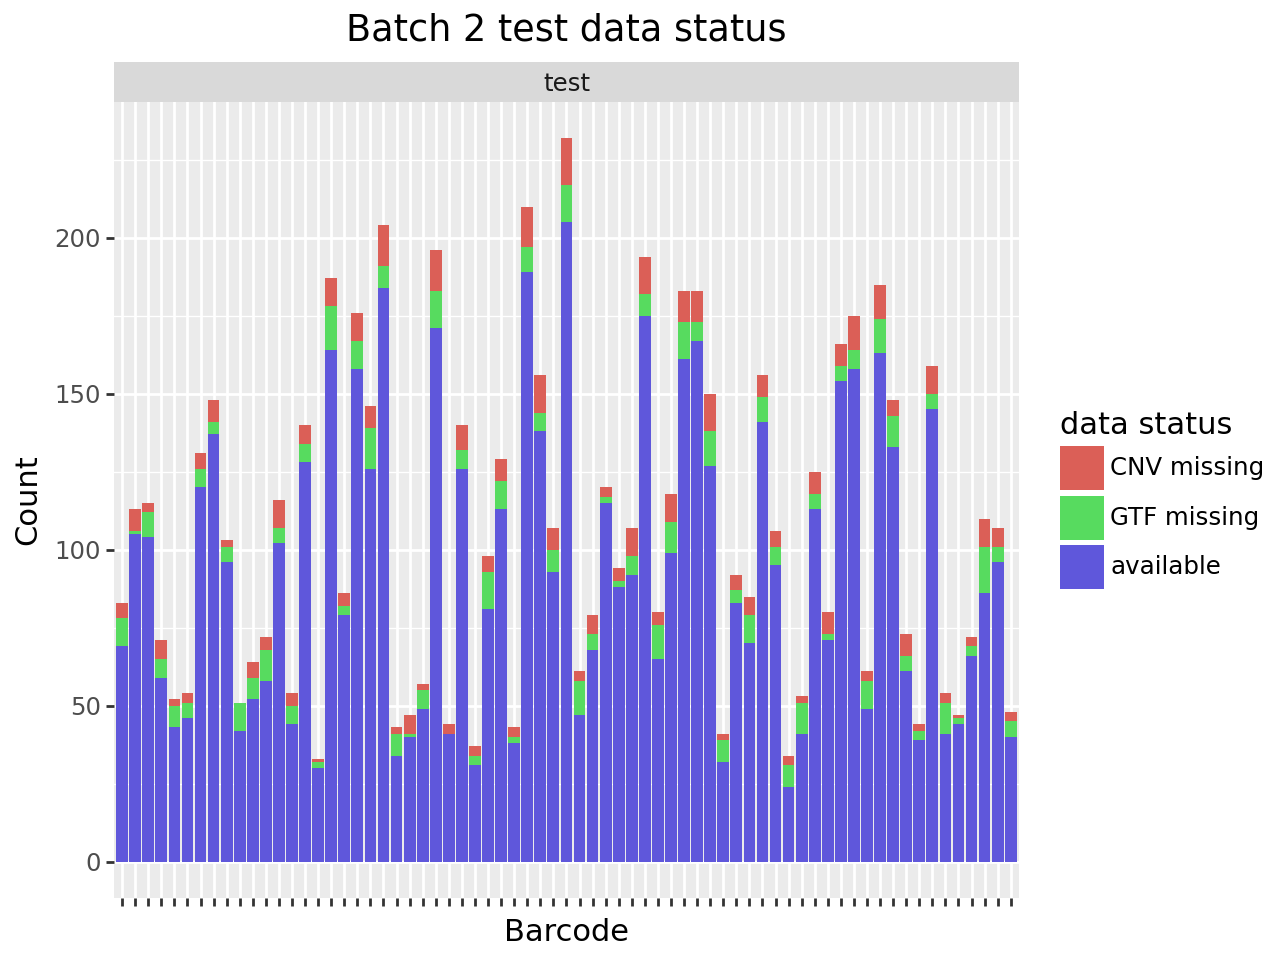

In [62]:
p = ggplot(data=b2_df[b2_df['split'] == 'test'], mapping=aes(x='barcode',fill='data status')) +\
    geom_col(stat='count') +\
    facet_wrap('~split') +\
    labs(title='Batch 2 test data status', x='Barcode', y='Count') +\
    theme(axis_text_x=element_blank())
ggsave(p, plot_root / 'dataset' / 'batch2_test_data_status.png')
p.show()

### Downsampled train splits
For better training, Isi downsampled the training splits for both batches.
Here, we compare the class balance for the train splits with the downsampled verison. 

#### Batch 1

In [21]:
b1_train_down_path = data_root / 'splits' / 'batch1_train_subsampled'
b1_train_down_df = pd.read_csv(b1_train_down_path, sep='\t')

In [22]:
b1_train_down = CnvDataset(
    root=data_root / 'embeddings' / 'batch_1' / 'train',
    data_df=b1_train_down_df
)

Using 356 barcodes
Using 1549 genes
No embedding files for 4092 data points in ../data/embeddings/batch_1/train/single_gene_barcode!


In [23]:
b1_train_down_df['split'] = 'train_down_samp'
b1_train_down_df['data status'] = 'missing'
b1_train_down_df.loc[
    (b1_train_down_df['barcode'].isin(b1_train_down.data_df['barcode'])) &
    (b1_train_down_df['gene_id'].isin(b1_train_down.data_df['gene_id']))
    ,'data status'] = 'available'
b1_train_down_df.loc[
    (b1_train_down_df['gene_id'].isin(b1_noGTF_df['gene_id']))
    ,'data status'] = 'GTF missing'
b1_train_down_df.loc[
    (b1_train_down_df['barcode'].isin(b1_noCNV_df['barcode'])) &
    (b1_train_down_df['gene_id'].isin(b1_noCNV_df['gene_id']))
    ,'data status'] = 'CNV missing'

In [24]:
b1_df = pd.concat([b1_train_df, b1_train_old_df, b1_train_down_df])

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch1_train_downsample_effect.png


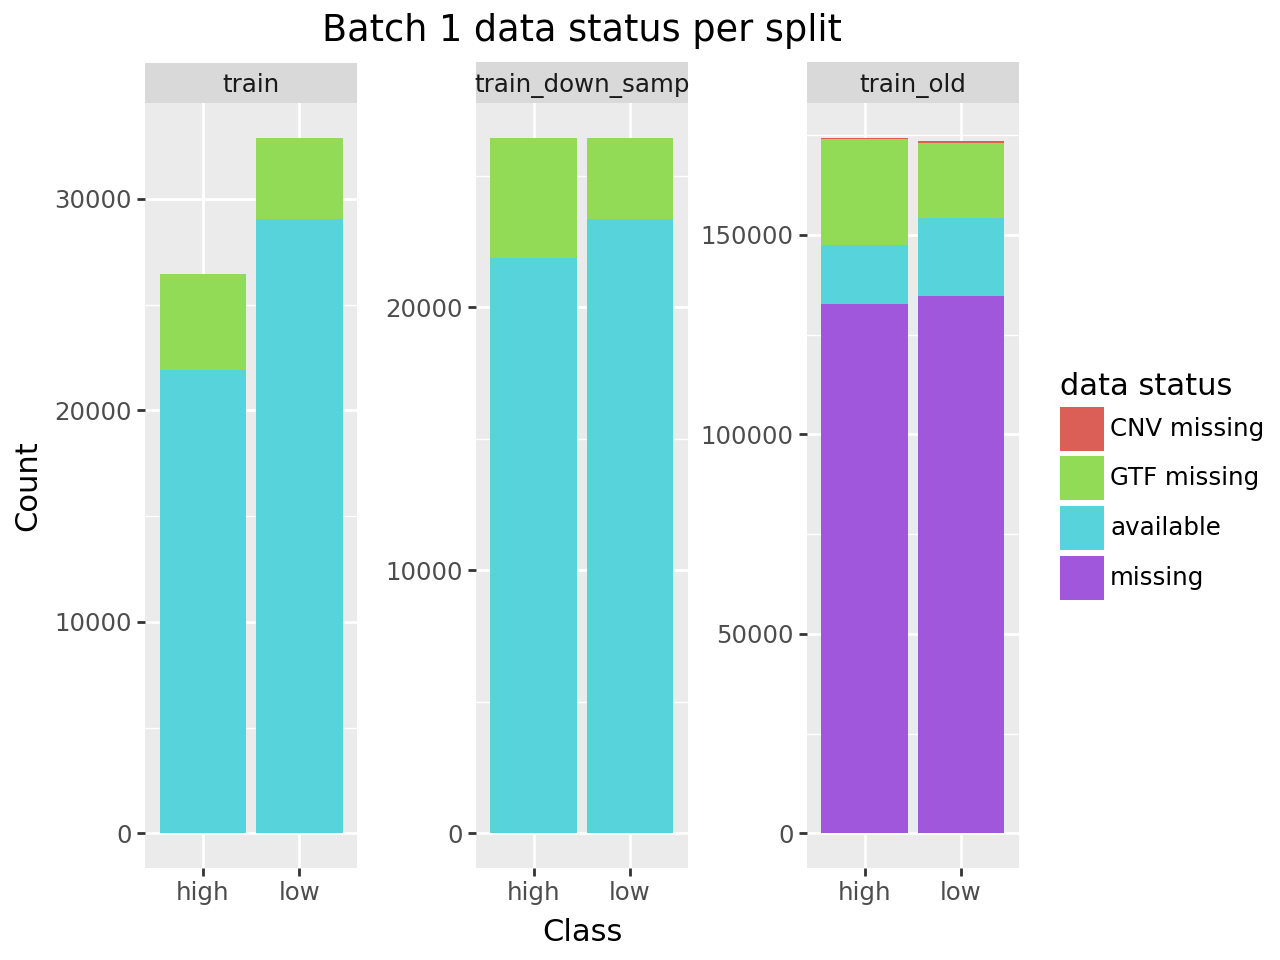

In [25]:
p = ggplot(data=b1_df, mapping=aes(x='classification',fill='data status')) +\
    geom_col(stat='count') +\
    facet_wrap('~split', scales='free') +\
    labs(title='Batch 1 data status per split', x='Class', y='Count')
ggsave(p, plot_root / 'dataset' / 'batch1_train_downsample_effect.png')
p.show()

#### Batch 2

In [31]:
b2_train_down_path = data_root / 'splits' / 'batch2_train_subsampled.tsv'
b2_train_down_df = pd.read_csv(b2_train_down_path, sep='\t')

In [41]:
b2_train_down = CnvDataset(
    root=data_root / 'embeddings' / 'batch_2' / 'train',
    data_df=b2_train_down_df
)

Using 239 barcodes
Using 1098 genes
No embedding files for 2147 data points in ../data/embeddings/batch_2/train/single_gene_barcode!


In [42]:
b2_train_down_df['split'] = 'train_down_samp'
b2_train_down_df['data status'] = 'missing'
b2_train_down_df.loc[
    (b2_train_down_df['barcode'].isin(b2_train_down.data_df['barcode'])) &
    (b2_train_down_df['gene_id'].isin(b2_train_down.data_df['gene_id']))
    ,'data status'] = 'available'
b2_train_down_df.loc[
    (b2_train_down_df['gene_id'].isin(b2_noGTF_df['gene_id']))
    ,'data status'] = 'GTF missing'
b2_train_down_df.loc[
    (b2_train_down_df['barcode'].isin(b2_noCNV_df['barcode'])) &
    (b2_train_down_df['gene_id'].isin(b2_noCNV_df['gene_id']))
    ,'data status'] = 'CNV missing'

In [44]:
b2_df = pd.concat([b2_train_df, b2_train_old_df, b2_train_down_df])

/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vol/storage/shared/miniforge3/envs/ssb/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../out/plots/dataset/batch2_train_downsample_effect.png


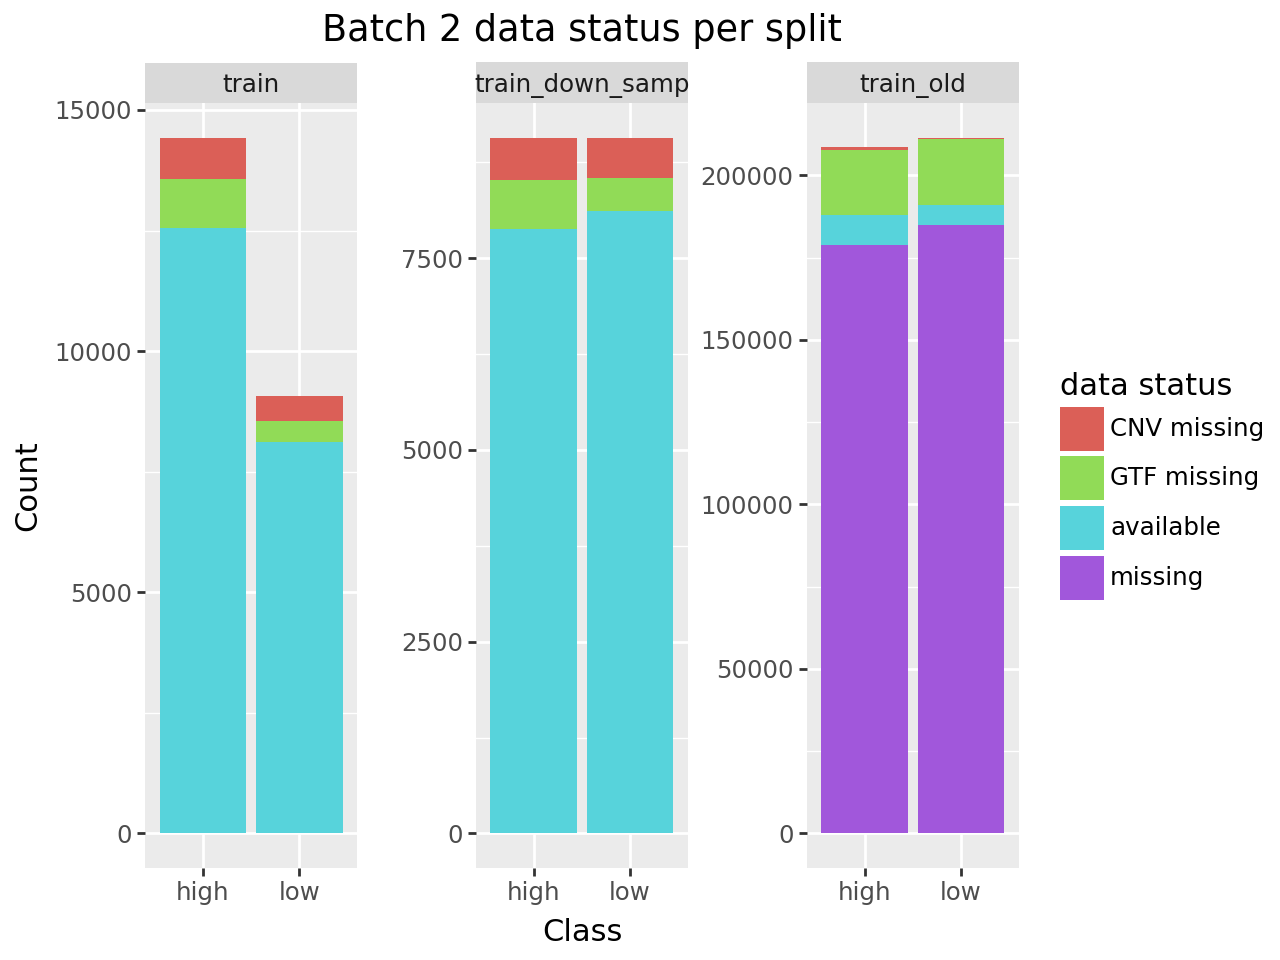

In [45]:
p = ggplot(data=b2_df, mapping=aes(x='classification',fill='data status')) +\
    geom_col(stat='count') +\
    facet_wrap('~split', scales='free') +\
    labs(title='Batch 2 data status per split', x='Class', y='Count')
ggsave(p, plot_root / 'dataset' / 'batch2_train_downsample_effect.png')
p.show()

### Genes with missing GTF annotation

In [ ]:
print('Batch1 uniq genes with missing GTF annotation')
b1_train_missing_genes = set(b1_train_df['gene_id'].unique()).difference(set(b1_train.data_df['gene_id'].unique()))
print(len(b1_train_missing_genes), 'train')
b1_val_missing_genes = set(b1_val_df['gene_id'].unique()).difference(set(b1_val.data_df['gene_id'].unique()))
print(len(b1_val_missing_genes), 'val')
b1_test_missing_genes = set(b1_test_df['gene_id'].unique()).difference(set(b1_test.data_df['gene_id'].unique()))
print(len(b1_test_missing_genes), 'test')
b1_missing_genes = b1_train_missing_genes.union(b1_val_missing_genes).union(b1_test_missing_genes)
print(len(b1_missing_genes), 'b1 total')

Batch1 uniq genes with missing GTF annotation
632 train
88 val
96 test
637 b1 total


In [ ]:
print('Batch 2 uniq genes with missing GTF annotation')
b2_train_missing_genes = set(b2_train_df['gene_id'].unique()).difference(set(b2_train.data_df['gene_id'].unique()))
print(len(b2_train_missing_genes), 'train')
b2_val_missing_genes = set(b2_val_df['gene_id'].unique()).difference(set(b2_val.data_df['gene_id'].unique()))
print(len(b2_val_missing_genes), 'val')
b2_test_missing_genes = set(b2_test_df['gene_id'].unique()).difference(set(b2_test.data_df['gene_id'].unique()))
print(len(b2_test_missing_genes), 'test')
b2_missing_genes = b2_train_missing_genes.union(b2_val_missing_genes).union(b2_test_missing_genes)
print(len(b2_missing_genes), 'b2 total')

Batch 2 uniq genes with missing GTF annotation
94 train
58 val
62 test
108 b2 total


In [85]:
b1_missing_gene_df = pd.DataFrame({'gene_id': list(b1_missing_genes)})
b1_missing_gene_df.to_csv(data_root / 'preprocessing' / 'batch1_missing_genes.csv', index=False)

In [86]:
b2_missing_gene_df = pd.DataFrame({'gene_id': list(b2_missing_genes)})
b2_missing_gene_df.to_csv(data_root / 'preprocessing' / 'batch2_missing_genes.csv', index=False)

## Barcode - gene pairs
Previously, we noticed during embedding calculation, that not all barcodes have targets/labels all genes, which is required for supervised learning. 
Thus, we analyse the barcode - gene pairs in the data here.
In particular, we want to identify the minimal gene set, that is shared among all barcodes of a batch.

In [ ]:
# algoritm idea make iterative intersections.
# 1. start will a set of all uniq genes
# 2. for each uniq barcode intersect the uniq gene ids associated to this barcode
# 3. return the result of all intersections

In [13]:
def find_minimal_gene_set(df: pd.DataFrame):
    uniq_gene_ids = set(df['gene_id'])
    uniq_barodes = set(df['barcode'])
    minimal_gene_set = uniq_gene_ids
    for barcode in uniq_barodes:
        minimal_gene_set = minimal_gene_set.intersection(
            set(df[df['barcode'] == barcode]['gene_id'])
        )
    return minimal_gene_set

In [8]:
uniq_gene_ids = set(b1_df['gene_id'])
len(uniq_gene_ids)
list(uniq_gene_ids)[:10]

['ENSG00000186047',
 'ENSG00000188001',
 'ENSG00000233008',
 'ENSG00000154485',
 'ENSG00000196787',
 'ENSG00000287200',
 'ENSG00000224982',
 'ENSG00000130844',
 'ENSG00000152583',
 'ENSG00000053254']

In [9]:
uniq_barodes = set(b1_df['barcode'])
len(uniq_barodes)
list(uniq_barodes)[:10]

['ACCCTGTTCCAGGAAA-1',
 'TATATCCTCCTGGTCT-1',
 'TTCGGTACAAATTGCT-1',
 'GTACTGGTCATGTGGT-1',
 'CTTGCGCGTTTATGGG-1',
 'GCACTAAGTTTACGTC-1',
 'GCCTTAACATTGACAT-1',
 'TGAAGGATCATTTGCT-1',
 'CTCCTGAGTTGTGACA-1',
 'TTAAGTGTCAGGTCCA-1']

In [10]:
minimal_gene_overlap = uniq_gene_ids
for barcode in uniq_barodes:
    minimal_gene_overlap = minimal_gene_overlap.intersection(
        set(b1_df[b1_df['barcode'] == barcode]['gene_id'])
    )
len(minimal_gene_overlap)

2000

In [ ]:
b1_min_gene_set = find_minimal_gene_set(
    b1_df = pd.read_csv(b1_full_data, sep='\t')
)
len(b1_min_gene_set)

In vestigate minimal gene set for batch 2.

In [12]:
b2_df = pd.read_csv(b2_full_data, sep='\t')

In [14]:
b2_min_gene_set = find_minimal_gene_set(b2_df)
len(b2_min_gene_set)

2000

### Minimal gene set of splits
As we see, the minimal gene overlap contains all 2000 genes we selected for our analysis.
Thus, check if the error arrises from the split data.

#### Batch 1 train
Minimal gene overlap set for training split of batch 1.

In [15]:
b1_train_min_gene_set = find_minimal_gene_set(
    pd.read_csv(b1_train_path, sep='\t')
)
len(b1_train_min_gene_set)

0

#### Batch 1 validation
Minimal gene overlap set for training split of batch 1.

In [16]:
b1_val_min_gene_set = find_minimal_gene_set(
    pd.read_csv(b1_val_path, sep='\t')
)
len(b1_val_min_gene_set)

0

#### Batch 1 test
Minimal gene overlap set for training split of batch 1.

In [17]:
b1_test_min_gene_set = find_minimal_gene_set(
    pd.read_csv(b1_test_path, sep='\t')
)
len(b1_test_min_gene_set)

0

#### Batch 2 train

In [18]:
b2_train_min_gene_set = find_minimal_gene_set(
    pd.read_csv(b2_train_path, sep='\t')
)
len(b2_train_min_gene_set)

0

#### Batch 2 validation

In [19]:
b2_val_min_gene_set = find_minimal_gene_set(
    pd.read_csv(b2_val_path, sep='\t')
)
len(b2_val_min_gene_set)

0

#### Batch 2 test

In [20]:
b2_test_min_gene_set = find_minimal_gene_set(
    pd.read_csv(b2_test_path, sep='\t')
)
len(b2_test_min_gene_set)

0

In [116]:
all(data_set.data_df['embedding_path'].apply(lambda p: str(p).endswith('mtx')))

True

In [131]:
dist_list = list()
for i in range(len(data_set)):
    dist_list.append(torch.sum(data_set[i]['embedding'], axis=1))
len(dist_list)

6444

In [133]:
torch.sum(dist_tensor, axis=0)

tensor([17221102, 15241252, 15535574, 17700908,        0,  1580000,  5040000])

In [37]:
data_set.data_df

barcode          gene_id  expression_count classification  \
2     AAAGGTTAGGGTGGAT-1  ENSG00000231252          1.257665           high   
3     AAAGGTTAGGGTGGAT-1  ENSG00000229956          0.696581            low   
4     AAAGGTTAGGGTGGAT-1  ENSG00000188641          0.407756            low   
5     AAAGGTTAGGGTGGAT-1  ENSG00000197956          0.696581            low   
6     AAAGGTTAGGGTGGAT-1  ENSG00000162687          0.920410           high   
...                  ...              ...               ...            ...   
8939  TTGGCTACATAAGTTC-1  ENSG00000205542          1.192522           high   
8940  TTGGCTACATAAGTTC-1  ENSG00000188158          1.192522           high   
8941  TTGGCTACATAAGTTC-1  ENSG00000147010          0.764393            low   
8942  TTGGCTACATAAGTTC-1  ENSG00000158813          1.192522           high   
8943  TTGGCTACATAAGTTC-1  ENSG00000129682          1.192522           high   

                                         embedding_path  
2     ../data/embeddings/batch_1/val/single_gene_bar...  
3     ../data/embeddings/batch_1/val/single_gene_bar...  
4     ../data/embeddings/batch_1/val/single_gene_bar...  
5     ../data/embeddings/batch_1/val/single_gene_bar...  
6     ../data/embeddings/batch_1/val/single_gene_bar...  
...                                                 ...  
8939  ../data/embeddings/batch_1/val/single_gene_bar...  
8940  ../data/embeddings/batch_1/val/single_gene_bar...  
8941  ../data/embeddings/batch_1/val/single_gene_bar...  
8942  ../data/embeddings/batch_1/val/single_gene_bar...  
8943  ../data/embeddings/batch_1/val/single_gene_bar...  

[8022 rows x 5 columns]

In [40]:
b1_overlaps_dt = pd.read_csv(data_root / 'gene_positions_and_overlaps' / 'overlaps_batch1.tsv', sep='\t')

In [60]:
b1_val_df = data_set.data_df[['barcode', 'gene_id']]
b1_ovp_df = b1_overlaps_dt[['barcode', 'gene_id']]

In [61]:
b1_ovp_df.merge(b1_val_df, on=['barcode', 'gene_id'])

barcode          gene_id
0     AAAGGTTAGGGTGGAT-1  ENSG00000197956
1     AAAGGTTAGGGTGGAT-1  ENSG00000162687
2     AAAGGTTAGGGTGGAT-1  ENSG00000092969
3     AAAGGTTAGGGTGGAT-1  ENSG00000143702
4     AACAGCAAGCAGGTGG-1  ENSG00000127124
...                  ...              ...
5778  TGGCCTTTCTTAATGG-1  ENSG00000188158
5779  TTCTTAGGTCACACCC-1  ENSG00000147010
5780  TTCTTAGGTCACACCC-1  ENSG00000147010
5781  TTGGCTACATAAGTTC-1  ENSG00000101871
5782  TTGGCTACATAAGTTC-1  ENSG00000188158

[5783 rows x 2 columns]

In [62]:
b1_ovp_df.merge(b1_val_df, on=['barcode', 'gene_id']).iloc[42]

barcode    ATAGATGCACCTCACC-1
gene_id       ENSG00000118473
Name: 42, dtype: object

In [63]:
b1_val_df[
    (b1_val_df['barcode'] == 'ATAGATGCACCTCACC-1') & 
    (b1_val_df['gene_id'] == 'ENSG00000118473')
]

barcode          gene_id
1519  ATAGATGCACCTCACC-1  ENSG00000118473

In [64]:
from scipy.io import mmread

In [139]:
# test for batch 1 training split if the ATAC peak signal and the CNV loss are present
for d in Path('../data/embeddings/batch_1/training/single_gene_barcode/').iterdir():
    for f in d.iterdir():
        if f.name.endswith('mtx'):
            t_sum = torch.sum(torch.from_numpy(mmread(f)).to(torch.uint8), axis=1)
            if any(t_sum[4:] > 0):
                print(t_sum)
# mmread('/ENSG00000003096.mtx')

tensor([ 3031,  2155,  2170,  2644,     0,     0, 10000])
tensor([ 3168,  1809,  1963,  3060,     0, 10000,     0])
tensor([ 2703,  2168,  2433,  2696, 10000,     0,     0])
tensor([ 2921,  2110,  1967,  3002,     0,     0, 10000])
tensor([ 2697,  2231,  2191,  2881,     0,     0, 10000])
tensor([ 2377,  2375,  2639,  2609, 10000,     0,     0])
tensor([ 2658,  2107,  2161,  3074,     0,     0, 10000])
tensor([ 3065,  1831,  1915,  3189,     0, 10000,     0])
tensor([2832, 1966, 2083, 3119, 1512,    0,    0])
tensor([ 2940,  1883,  2193,  2984,     0,     0, 10000])
tensor([ 3125,  1951,  2028,  2896,     0, 10000,     0])
tensor([ 2620,  2302,  2129,  2949,     0, 10000,     0])
tensor([2976, 1935, 1996, 3093,    0,    0, 9999])
tensor([ 2855,  2108,  2002,  3035,     0,     0, 10000])
tensor([ 2813,  2191,  2057,  2939,     0,     0, 10000])
tensor([ 2872,  1921,  2158,  3049,     0,     0, 10000])
tensor([ 2721,  2119,  2216,  2944, 10000,     0,     0])
tensor([ 2972,  1710,  1830,

KeyboardInterrupt: 

In [71]:
tensor_from_file = torch.from_numpy(mmread(data_set.data_df['embedding_path'].iloc[1519])).to(torch.uint8)
tensor_from_file

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 1, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [73]:
tensor_from_dataset = data_set[1519]['embedding']
tensor_from_dataset

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 1, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [74]:
assert torch.equal(tensor_from_dataset, tensor_from_file)

In [77]:
test_region_dt = b1_overlaps_dt[
    (b1_overlaps_dt['barcode'] == 'ATAGATGCACCTCACC-1') & 
    (b1_overlaps_dt['gene_id'] == 'ENSG00000118473')
]
test_region_dt['Start_emb'] = test_region_dt['Start_gene'] - 2000
test_region_dt['End_emb'] = test_region_dt['Start_gene'] + 8000
test_region_dt

/tmp/ipykernel_2734438/699973521.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2734438/699973521.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


barcode Chromosome  Start_peak  End_peak          gene_id  \
394  ATAGATGCACCTCACC-1          1    66533617  66534405  ENSG00000118473   

     Start_gene  End_gene  Start_emb   End_emb  
394    66531267  66753139   66529267  66539267

In [79]:
test_region_dt['Start_emb'] < test_region_dt['Start_peak']

394    True
dtype: bool

In [80]:
test_region_dt['End_emb'] > test_region_dt['Start_peak']

394    True
dtype: bool

In [84]:
from src.data.embedding import Embedder

In [88]:
embedder = Embedder(
    fasta_path=genome_fasta,
    gtf_path=gtf_path,
    atac_path=overlap_path,
    cnv_path=epiAneufinder_path,
    barcode_set={'ATAGATGCACCTCACC-1'},
    gene_set={'ENSG00000118473'}
    )

[Embedder]: Iterating over all possible barcode-gene pairs
[Embedder]: Computing 1 Embeddings with mode: "single_gene_barcode"
[Embedder]: Using 1 barcodes
[Embedder]: Using 1 genes


In [89]:
b, g, e = next(embedder)
print(b, g)
print(e)

ATAGATGCACCTCACC-1 ENSG00000118473
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [94]:
e.sum(axis=1)

array([ 2891,  1966,  2007,  3136, 10000,     0,     0], dtype=uint64)

In [95]:
tensor_from_file.sum(axis=1)

tensor([2811, 2189, 2128, 2872,    0,    0,    0])

This means something is wrong with the dataset class.
The ATAC-seq signal shows up in the newly computed embeddings, but not in dataset or the embedding files. 

## Dataset class
This section tests the dataset class `CnvDataset` from `src/data/dataset.py`.

In [3]:
import sys
sys.path.append('..') # add the parent directory to system path
from src.data.dataset import CnvDataset

In [87]:
# directories we will need
out_root = git_root / 'out'

# files we will need
genome_fasta = data_root / 'reference' / 'GRCh38.d1.vd1.fa'
assert genome_fasta.exists()
gtf_path=data_root / 'gene_positions_and_overlaps' / 'gene_positions.csv'
assert gtf_path.is_file()
overlap_path = data_root / 'gene_positions_and_overlaps' / 'overlaps_batch1.tsv'
assert overlap_path.exists()
epiAneufinder_path = out_root / 'epiAneufinder' / 'epiAneuFinder_results.tsv'
assert epiAneufinder_path.exists()

### File format benchmark
We discussed multiple file formats to use in the backend for storing computed embeddings on the disk. Suggestions were the vanilla pytorch format `.pt`, pickle files `.pkl` and the scipy matrix format `.mtx`.
Since pytorch is using pickle in the backend for creating `.pt` files, we decided to only use the `.pt` and `.mtx` formats.
In the following we benchmark reading from these file types, as this could be a bottleneck during training. 

In [7]:
b1_val_path = data_root / 'splits' / 'batch1_val_filtered.tsv'
b1_val_dataset = CnvDataset(
    root=data_root / 'embeddings' / 'batch_1' / 'val',
    data_df=pd.read_csv(b1_val_path, sep='\t'),
    embedding_mode='single_gene_barcode',
    file_format='mtx',
    verbose=2
)

Using 51 barcodes
Using 1093 genes
No embedding files for 932 data points in ../data/embeddings/batch_1/val/single_gene_barcode!
../data/embeddings/batch_1/val/single_gene_barcode/AAAGGTTAGGGTGGAT-1/ENSG00000173372.mtx


In [67]:
b1_val_redo = CnvDataset(
    root=data_root / 'embeddings' / 'batch_1' / 'val_redo_2',
    data_df=pd.read_csv(b1_val_path, sep='\t'),
    fasta_path=genome_fasta,
    atac_path=overlap_path,
    cnv_path=epiAneufinder_path,
    verbose=2,
    force_recompute=True
)

Using 51 barcodes
Using 1093 genes
Recomputing embeddings:  True
[embed]: Iterating over custom barcode to genes mapping
[embed]: Computing 8954 Embeddings with mode: "single_gene_barcode"
[embed]: Using 51 barcodes
[embed]: Using 1093 genes


[embed]: Computing embeddings (# genes done):   0%|                                            | 0/1093 [00:00<?, ?it/s]

emb_df
 Empty DataFrame
Columns: [barcode, gene_id, embedding_path]
Index: []


RuntimeError: No embedding files found!

In [16]:
b1_val_df = pd.read_csv(b1_val_path, sep='\t')

In [21]:
b1_val_df.shape

(8954, 5)

In [20]:
b1_val_df['embedding_path'] = [
    b1_val_redo.ids_to_emb_path(b, g) for b, g in 
    b1_val_df[['barcode', 'gene_id']].itertuples(index=False)
]

In [23]:
missing_df = b1_val_df[~b1_val_df['embedding_path'].isin(b1_val_redo.data_df['embedding_path'])]

In [35]:
missing_df['barcode'].value_counts()

barcode
AATGCATGTTCACCCA-1    39
CTTTAGGCAGCACGAA-1    39
GCGCCTTGTAACAGGG-1    38
ACCCTGTTCATAGCCG-1    37
GACGTAAAGCATGTTA-1    37
TACGGTTAGCACAGCC-1    36
TACTGACAGAATCTCA-1    33
TTCTTAGGTCACACCC-1    30
TGATGAACAAGGCCAA-1    30
TGGCCTTTCTTAATGG-1    27
GATTTGCAGCCTGTTC-1    20
CGCTTAACATCACAGC-1    19
CTGGACCAGTTGGGCC-1    19
CGATTTGCACGAATCC-1    19
CTGGTTACATTTAAGC-1    19
GTAGTTTCAGGCGAGT-1    19
TGCTAGCCAATTAACC-1    19
GCTATCCTCCCTCGCA-1    19
CACTTTGTCTAACTGA-1    19
TACTAAGTCAGCAAAG-1    18
CAAGGTAAGGTCCAAT-1    18
TCGTTAAAGGTTAGCT-1    17
TCTCGCCCAGGCGATA-1    17
CCATAAGGTGGTTATG-1    17
AAAGGTTAGGGTGGAT-1    17
ATTGAAGCAAATGCCC-1    17
ACTATCCGTTTAACGG-1    17
GGGCTAACAGCATGTC-1    16
TAGTAAGCATGTTGCA-1    16
ATAGGTACAGGTTAAA-1    15
GGACCGAAGCGATAAG-1    15
TGTGGCCAGGAGGACT-1    15
TTGGCTACATAAGTTC-1    14
AAGCCTCCACGAACAG-1    13
CAGCCTAAGTGAAGTG-1    13
TCGTTATTCCTTGCAC-1    13
ATAGATGCACCTCACC-1    13
CACAAGCGTAAATTGC-1    13
ACTAACCAGTTGGGCC-1    13
ACCCGTAAGGGACCTC-

In [29]:
b1_val_redo.data_df

barcode          gene_id  expression_count classification  \
0     GACGTAAAGCATGTTA-1  ENSG00000069424          0.606885            low   
1     CCTTAACGTCGTAAAT-1  ENSG00000215788          0.638693            low   
2     GCTATCCTCCCTCGCA-1  ENSG00000215788          0.216336            low   
3     TACGGTTAGCACAGCC-1  ENSG00000215788          0.569907            low   
4     GATTTGCAGCCTGTTC-1  ENSG00000171621          0.346812            low   
...                  ...              ...               ...            ...   
8017  AAGCCTCCACGAACAG-1  ENSG00000287918          0.744612            low   
8018  ACCCTGTTCATAGCCG-1  ENSG00000160219          0.267540            low   
8019  GACGTAAAGCATGTTA-1  ENSG00000160219          0.981858           high   
8020  GGTCTTGAGGAGCACG-1  ENSG00000160219          0.728388            low   
8021  TGGCCTTTCTTAATGG-1  ENSG00000160219          0.558048            low   

                                         embedding_path  
0     ../data/embeddings/batch_1/val_redo/single_gen...  
1     ../data/embeddings/batch_1/val_redo/single_gen...  
2     ../data/embeddings/batch_1/val_redo/single_gen...  
3     ../data/embeddings/batch_1/val_redo/single_gen...  
4     ../data/embeddings/batch_1/val_redo/single_gen...  
...                                                 ...  
8017  ../data/embeddings/batch_1/val_redo/single_gen...  
8018  ../data/embeddings/batch_1/val_redo/single_gen...  
8019  ../data/embeddings/batch_1/val_redo/single_gen...  
8020  ../data/embeddings/batch_1/val_redo/single_gen...  
8021  ../data/embeddings/batch_1/val_redo/single_gen...  

[8022 rows x 5 columns]

Check if there are duplicate barcode - gene pairs in the val data frame.

In [30]:
b1_val_df[['barcode', 'gene_id']].drop_duplicates().shape

(8954, 2)

In [31]:
b1_val_df.shape

(8954, 5)

In [32]:
b1_val_df[b1_val_df['barcode'] == 'AAAGGTTAGGGTGGAT-1'].shape

(192, 5)

In [41]:
barcode_to_genes = {
    barcode: list(set(b1_val_df[b1_val_df['barcode'] == barcode]['gene_id']))
    for barcode in set(b1_val_df['barcode'])
}

In [42]:
n_embeddings = sum(map(len, barcode_to_genes.values()))
n_embeddings

8954

In [48]:
cnv_df = pd.read_csv(out_root / 'epiAneufinder/epiAneuFinder_results.tsv', sep=' ')

In [49]:
cnv_df

idx    seq     start       end  GCGCAATGTTGCGGAT-3  \
0          1   chr1    800001    900000                   1   
1          2   chr1    900001   1000000                   1   
2          3   chr1   1000001   1100000                   1   
3          4   chr1   1100001   1200000                   1   
4          5   chr1   1200001   1300000                   1   
...      ...    ...       ...       ...                 ...   
26009  26010  chr22  50100001  50200000                   1   
26010  26011  chr22  50200001  50300000                   1   
26011  26012  chr22  50300001  50400000                   1   
26012  26013  chr22  50400001  50500000                   1   
26013  26014  chr22  50500001  50600000                   1   

       CTAGTGAGTCACCTAT-3  AATCATGTCGATCAGT-1  TCCTTAGTCGGGACTC-4  \
0                       1                   1                   1   
1                       1                   1                   1   
2                       1                   1                   1   
3                       1                   1                   1   
4                       1                   1                   1   
...                   ...                 ...                 ...   
26009                   0                   0                   1   
26010                   0                   0                   1   
26011                   0                   0                   1   
26012                   0                   0                   1   
26013                   0                   0                   1   

       ACTATCCGTCTAACCT-1  GTGCACGGTCACAAAT-3  ...  AGTGTGGCAATTATGC-1  \
0                       1                   1  ...                   1   
1                       1                   1  ...                   1   
2                       1                   1  ...                   1   
3                       1                   1  ...                   1   
4                       1                   1  ...                   1   
...                   ...                 ...  ...                 ...   
26009                   1                   1  ...                   1   
26010                   1                   1  ...                   1   
26011                   1                   1  ...                   1   
26012                   1                   1  ...                   1   
26013                   1                   1  ...                   1   

       AGAGAGGAGCAGGCCT-2  ATCCACCTCAACAAGG-1  GGTTGAGCATAGGCGA-1  \
0                       1                   1                   0   
1                       1                   1                   0   
2                       1                   1                   0   
3                       1                   1                   0   
4                       1                   1                   0   
...                   ...                 ...                 ...   
26009                   1                   1                   0   
26010                   1                   1                   0   
26011                   1                   1                   0   
26012                   1                   1                   0   
26013                   1                   1                   0   

       GTACTTAAGACACCGC-1  CGTAGCGGTAGGTTGC-1  TGCTATGCAAGGACCA-1  \
0                       1                   1                   1   
1                       1                   1                   1   
2                       1                   1                   1   
3                       1                   1                   1   
4                       1                   1                   1   
...                   ...                 ...                 ...   
26009                   1                   1                   2   
26010                   1                   1                   2   
26011                   1                   1                   2   
26012          

Debug stepwise the mapping dict reshaping code:

1. check barcodes

In [50]:
uniq_barcodes = set(cnv_df.columns[4:])
len(uniq_barcodes)

5778

In [54]:
b1_val_uniq_barcodes = set(b1_val_df['barcode'])
print(len(b1_val_uniq_barcodes))
len(b1_val_uniq_barcodes.intersection(uniq_barcodes))

51


51

In [55]:
iter_barcode_set = set(barcode_to_genes.keys())
uniq_barcodes = uniq_barcodes.intersection(iter_barcode_set)
len(uniq_barcodes)

51

2. check genes

In [57]:
atac_df = pd.read_csv(data_root / 'overlap_genes_peaks.tsv', sep='\t')
atac_df

Chromosome  Start_peak  End_peak  Start_gene  End_gene          gene_id
0              1        9855     10676        9121     26894  ENSG00000290825
1              1        9855     10676       10010     15670  ENSG00000223972
2              1      181027    181582       87295    183719  ENSG00000241860
3              1      181027    181582      144386    201861  ENSG00000310528
4              1      181027    181582      178931    186937  ENSG00000308415
...          ...         ...       ...         ...       ...              ...
92630          Y    11332807  11333567    11330329  11335595  ENSG00000258991
92631          Y    11333695  11334440    11330329  11335595  ENSG00000258991
92632          Y    11333695  11334440    11333627  11339693  ENSG00000270455
92633          Y    56855391  56856232    56853244  56857488  ENSG00000235857
92634          Y    56879609  56880338    56879849  56884115  ENSG00000305394

[92635 rows x 6 columns]

In [58]:
uniq_gene_ids = set(atac_df['gene_id'].unique())
len(uniq_gene_ids)

36749

In [59]:
iter_gene_set = {
    gene for vals in barcode_to_genes.values() for gene in vals
}
uniq_gene_overlap = uniq_gene_ids.intersection(iter_gene_set)
len(uniq_gene_overlap)

910

In [60]:
b1_val_uniq_gene_ids = set(b1_val_df['gene_id'])
print(len(b1_val_uniq_gene_ids))
print(len(b1_val_uniq_gene_ids.intersection(uniq_gene_ids)))

1093
910


This means, we filter genes based on the atac peaks file.

In [61]:
len([gid for gid in uniq_gene_ids if gid not in uniq_gene_overlap])

35839

In [62]:
new_uniq_gene_ids = uniq_gene_overlap

# sort uniq barcodes for alphabetical iteration order
uniq_barcodes = sorted(list(uniq_barcodes))

# create a mapping from gene to barcode to serve for iteration later
gene_to_barcodes = {gene: list() for gene in new_uniq_gene_ids}
# TODO: use boolean map to encode barcodes per gene for saving memory
for cnv_barcode in uniq_barcodes:
    for gene in barcode_to_genes[cnv_barcode]:
        if gene in new_uniq_gene_ids:
            gene_to_barcodes[gene].append(cnv_barcode)

In [65]:
new_n_embeddings = sum(map(len, gene_to_barcodes.values()))
assert new_n_embeddings == n_embeddings, 'Not some # embeddings: {} != {}'.format(
    new_n_embeddings, n_embeddings
)

AssertionError: Not some # embeddings: 8049 != 8954

In [6]:
b1_val_dataset

<class 'src.data.dataset.CnvDataset'> with 8022 datapoints

In [7]:
b2_val_path = data_root / 'splits' / 'batch2_val_filtered.tsv'
b2_val_dataset = CnvDataset(
    root=data_root / 'embeddings' / 'batch_2',
    data_df=pd.read_csv(b2_val_path, sep='\t'),
    embedding_mode='single_gene_barcode',
    file_format='pt'
)

Using 35 barcodes
Using 621 genes
No embedding files for 3603 data points in ../data/embeddings/batch_2/single_gene_barcode!


In [8]:
b2_val_dataset

<class 'src.data.dataset.CnvDataset'> with 0 datapoints

In [ ]:
b1_test_path = b1_val_dataset.data_df['embedding_path'].iloc[42]
b2_test_path = b2_val_dataset.data_df['embedding_path'].iloc[42]
print(b1_test_path)
print(b2_test_path)

../data/embeddings/batch_1/val/single_gene_barcode/AAAGGTTAGGGTGGAT-1/ENSG00000117984.mtx
../data/embeddings/batch_2/single_gene_barcode/AAACCAACATTGCGGT-2/ENSG00000172985.pt


In [ ]:
from torch import load as pyt_load
from scipy.io import mmread

In [ ]:
%%timeit
t = mmread(b1_test_path)

3.93 ms ± 40.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
t = pyt_load(b2_test_path)

257 μs ± 646 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%%timeit
t = b1_val_dataset[42]

5.16 ms ± 204 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
t = b2_val_dataset[42]

511 μs ± 25.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


This means, using the `mtx` format is `# samples * # iterations * 1000 μs` longer

Now, let's gauge the disk space required for only the embedding of specific 
barcode, gene pairs described in the dataset splits.
One embedding has roughly a size of 550Kb:
```sh
(ssb) marw@goodmosquito-0dcaa:~/cmscb8$ ll -h data/embeddings/file_type_test/
-rw-rw-r-- 1 marw student 549K Feb 27 08:03 ENSG00000090104.pt
```

With this, we can extrapolate the required space from the number of embeddings 
per split as an upper bound.
```sh
(ssb) marw@goodmosquito-0dcaa:~/cmscb8$ wc -l data/splits/*
  18636 data/splits/batch1_test_filtered.tsv
  59342 data/splits/batch1_training_filtered.tsv
   8955 data/splits/batch1_val_filtered.tsv
   7329 data/splits/batch2_test_filtered.tsv
  23497 data/splits/batch2_training_filtered.tsv
   3604 data/splits/batch2_val_filtered.tsv
wc: data/splits/old_splits: Is a directory
      0 data/splits/old_splits
 121363 total
```
For each of these files, we need to subtract 1 for the header.
After that we can calculate the expected size in Mb by `# embeddings * 550Kb / 1000`.

In [2]:
# space required for batch 1
(18636 - 1 + 59342 - 1 + 8955 - 1) * 550 / 1000

47811.5

In [3]:
# space required for batch 1
(7329 - 1 + 23497 - 1 + 3604 - 1) * 550 / 1000

18934.85

In [5]:
# space required for all embeddings in Gb
(121363 - 6) * 550 / 1_000_000

66.74635

Loading time benchmark for .pkl embedding

In [12]:
import pickle

In [25]:
%%timeit
with open('../data/embeddings/file_type_test/ENSG00000090104.pkl', 'br') as f:
    pickle.load(f)

177 μs ± 3.54 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [26]:
np.save('../data/embeddings/file_type_test/ENSG00000090104.npy', t.numpy())

In [27]:
%%timeit
np.load('../data/embeddings/file_type_test/ENSG00000090104.npy')

174 μs ± 6.69 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Loading Batch 2
Next we try to load batch 2, which is currently saved as `.pt` file in `data/embeddings/batch_2`.

In [ ]:
b2_val_data_root = data_root / 'embeddings' / 'batch_2'
b2_train_path = data_root / 'splits' / 'batch2_training_filtered.tsv'
b2_val_path = data_root / 'splits' / 'batch2_val_filtered.tsv'
b2_test_path = data_root / 'splits' / 'batch2_test_filtered.tsv'

In [ ]:
b2_val_df = pd.read_csv(b2_val_path, sep='\t')

In [ ]:
b2_val_dataset = CnvDataset(
    root=b2_val_data_root,
    data_df=b2_val_df,
    embedding_mode='single_gene_barcode',
    verbose=2,
    file_format='pt'
)

Using 35 barcodes
Using 621 genes
emb_on_disk_df
                   barcode          gene_id  \
0       CCTGTATGTGGTTCTT-2  ENSG00000172578   
1       CCTGTATGTGGTTCTT-2  ENSG00000114450   
2       CCTGTATGTGGTTCTT-2  ENSG00000136297   
3       CCTGTATGTGGTTCTT-2  ENSG00000104783   
4       CCTGTATGTGGTTCTT-2  ENSG00000188676   
...                    ...              ...   
427373  GAGGACTAGTATCGCG-2  ENSG00000287493   
427374  GAGGACTAGTATCGCG-2  ENSG00000122025   
427375  GAGGACTAGTATCGCG-2  ENSG00000125851   
427376  GAGGACTAGTATCGCG-2  ENSG00000267421   
427377  GAGGACTAGTATCGCG-2  ENSG00000285592   

                                           embedding_path  
0       ../data/embeddings/batch_2/single_gene_barcode...  
1       ../data/embeddings/batch_2/single_gene_barcode...  
2       ../data/embeddings/batch_2/single_gene_barcode...  
3       ../data/embeddings/batch_2/single_gene_barcode...  
4       ../data/embeddings/batch_2/single_gene_barcode...  
...                       

In [ ]:
b2_val_dataset

<class 'src.data.dataset.CnvDataset'> with 3160 datapoints

In [ ]:
b1_val_dataset

<class 'src.data.dataset.CnvDataset'> with 8022 datapoints

In [ ]:
%%time
t_list = [b1_val_dataset[i] for i in range(3_100)]

In [ ]:
%%time
t_list = [b2_val_dataset[i] for i in range(3_100)]

In [ ]:
b2_val_df

barcode          gene_id  expression_count classification
0     AAACCAACATTGCGGT-2  ENSG00000162512          1.024897           high
1     AAACCAACATTGCGGT-2  ENSG00000186094          1.850096           high
2     AAACCAACATTGCGGT-2  ENSG00000231252          1.024897           high
3     AAACCAACATTGCGGT-2  ENSG00000183023          1.024897           high
4     AAACCAACATTGCGGT-2  ENSG00000115355          1.024897           high
...                  ...              ...               ...            ...
3598  TTTGTGGCATGAATAG-2  ENSG00000130254          1.790029           high
3599  TTTGTGGCATGAATAG-2  ENSG00000080573          1.790029           high
3600  TTTGTGGCATGAATAG-2  ENSG00000167615          1.790029           high
3601  TTTGTGGCATGAATAG-2  ENSG00000225377          1.790029           high
3602  TTTGTGGCATGAATAG-2  ENSG00000198712          1.790029           high

[3603 rows x 4 columns]

In [ ]:
[(b, g) for b, g in b2_val_df[['barcode', 'gene_id']].itertuples(index=False)][:10]

[('AAACCAACATTGCGGT-2', 'ENSG00000162512'),
 ('AAACCAACATTGCGGT-2', 'ENSG00000186094'),
 ('AAACCAACATTGCGGT-2', 'ENSG00000231252'),
 ('AAACCAACATTGCGGT-2', 'ENSG00000183023'),
 ('AAACCAACATTGCGGT-2', 'ENSG00000115355'),
 ('AAACCAACATTGCGGT-2', 'ENSG00000172005'),
 ('AAACCAACATTGCGGT-2', 'ENSG00000172985'),
 ('AAACCAACATTGCGGT-2', 'ENSG00000152127'),
 ('AAACCAACATTGCGGT-2', 'ENSG00000157827'),
 ('AAACCAACATTGCGGT-2', 'ENSG00000236283')]

In [ ]:
b1_val_df['embedding_path'] = [b1_val_dataset.ids_to_emb_path(b, g) for b, g in b1_val_df[['barcode', 'gene_id']].itertuples(index=False)]

In [ ]:
b1_val_df[b1_val_df.apply(lambda x: not x['embedding_path'].exists(), axis=1)]

barcode          gene_id  expression_count classification  \
0     AAAGGTTAGGGTGGAT-1  ENSG00000173372          0.407756            low   
1     AAAGGTTAGGGTGGAT-1  ENSG00000226476          1.103188           high   
89    AAAGGTTAGGGTGGAT-1  ENSG00000287523          0.920410           high   
97    AAAGGTTAGGGTGGAT-1  ENSG00000038945          0.407756            low   
146   AAAGGTTAGGGTGGAT-1  ENSG00000258081          0.920410           high   
...                  ...              ...               ...            ...   
8949  TTGGCTACATAAGTTC-1  ENSG00000198938          2.065108           high   
8950  TTGGCTACATAAGTTC-1  ENSG00000198840          1.721116           high   
8951  TTGGCTACATAAGTTC-1  ENSG00000198886          2.611877           high   
8952  TTGGCTACATAAGTTC-1  ENSG00000198786          1.907831           high   
8953  TTGGCTACATAAGTTC-1  ENSG00000198727          1.721116           high   

                                         embedding_path  
0     ../data/embeddings/batch_1/val/single_gene_bar...  
1     ../data/embeddings/batch_1/val/single_gene_bar...  
89    ../data/embeddings/batch_1/val/single_gene_bar...  
97    ../data/embeddings/batch_1/val/single_gene_bar...  
146   ../data/embeddings/batch_1/val/single_gene_bar...  
...                                                 ...  
8949  ../data/embeddings/batch_1/val/single_gene_bar...  
8950  ../data/embeddings/batch_1/val/single_gene_bar...  
8951  ../data/embeddings/batch_1/val/single_gene_bar...  
8952  ../data/embeddings/batch_1/val/single_gene_bar...  
8953  ../data/embeddings/batch_1/val/single_gene_bar...  

[932 rows x 5 columns]

In [ ]:
b1_val_df.loc[0]['embedding_path'].exists()

False

In [ ]:
any([p.exists() for p in b2_val_paths])

False

In [ ]:
p_dir = b2_val_paths[0].parent
p_name = b2_val_paths[0].name.split('.')[0] + '.pt'
p = p_dir / p_name
print(p)
p.exists()

../data/embeddings/batch_1/val/single_gene_barcode/AAACCAACATTGCGGT-2/ENSG00000162512.pt


False

## Complete Batch 1 Training

In [ ]:
from pathlib import Path
import pandas as pd
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
from src.data.dataset import CnvDataset

In [2]:
b1_train_df = pd.read_csv('../data/splits/batch1_training_filtered.tsv', sep='\t')

In [3]:
b1_train = CnvDataset('../data/embeddings/batch_1/train', b1_train_df, file_format='mtx')
b1_train

Using 356 barcodes
Using 1595 genes
No embedding files for 4335 data points in ../data/embeddings/batch_1/train/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 55006 datapoints

In [4]:
b1_train_df['embedding_path'] = b1_train_df.apply(lambda r: b1_train.ids_to_emb_path(r['barcode'], r['gene_id']), axis=1)

In [5]:
b1_train_df

barcode          gene_id  expression_count classification  \
0      AAACCAACATGTCAGC-1  ENSG00000269113          0.749940            low   
1      AAACCAACATGTCAGC-1  ENSG00000229956          1.173642           high   
2      AAACCAACATGTCAGC-1  ENSG00000237505          0.749940            low   
3      AAACCAACATGTCAGC-1  ENSG00000188641          0.749940            low   
4      AAACCAACATGTCAGC-1  ENSG00000162636          0.749940            low   
...                   ...              ...               ...            ...   
59336  TTTGTTGGTGCCGCAA-1  ENSG00000198938          2.220852           high   
59337  TTTGTTGGTGCCGCAA-1  ENSG00000198840          1.968703           high   
59338  TTTGTTGGTGCCGCAA-1  ENSG00000198886          1.116385           high   
59339  TTTGTTGGTGCCGCAA-1  ENSG00000198786          1.406267           high   
59340  TTTGTTGGTGCCGCAA-1  ENSG00000198727          2.422053           high   

                                          embedding_path  
0      ../data/embeddings/batch_1/train/single_gene_b...  
1      ../data/embeddings/batch_1/train/single_gene_b...  
2      ../data/embeddings/batch_1/train/single_gene_b...  
3      ../data/embeddings/batch_1/train/single_gene_b...  
4      ../data/embeddings/batch_1/train/single_gene_b...  
...                                                  ...  
59336  ../data/embeddings/batch_1/train/single_gene_b...  
59337  ../data/embeddings/batch_1/train/single_gene_b...  
59338  ../data/embeddings/batch_1/train/single_gene_b...  
59339  ../data/embeddings/batch_1/train/single_gene_b...  
59340  ../data/embeddings/batch_1/train/single_gene_b...  

[59341 rows x 5 columns]

In [7]:
b1_train_missing_df = b1_train_df[~b1_train_df['embedding_path'].apply(lambda p: p.exists())]

In [8]:
b1_train_missing_df

barcode          gene_id  expression_count classification  \
48     AAACCAACATGTCAGC-1  ENSG00000227220          1.173642           high   
88     AAACCAACATGTCAGC-1  ENSG00000258081          1.173642           high   
108    AAACCAACATGTCAGC-1  ENSG00000198888          0.749940            low   
109    AAACCAACATGTCAGC-1  ENSG00000198763          1.470319           high   
110    AAACCAACATGTCAGC-1  ENSG00000198804          2.995075           high   
...                   ...              ...               ...            ...   
59336  TTTGTTGGTGCCGCAA-1  ENSG00000198938          2.220852           high   
59337  TTTGTTGGTGCCGCAA-1  ENSG00000198840          1.968703           high   
59338  TTTGTTGGTGCCGCAA-1  ENSG00000198886          1.116385           high   
59339  TTTGTTGGTGCCGCAA-1  ENSG00000198786          1.406267           high   
59340  TTTGTTGGTGCCGCAA-1  ENSG00000198727          2.422053           high   

                                          embedding_path  
48     ../data/embeddings/batch_1/train/single_gene_b...  
88     ../data/embeddings/batch_1/train/single_gene_b...  
108    ../data/embeddings/batch_1/train/single_gene_b...  
109    ../data/embeddings/batch_1/train/single_gene_b...  
110    ../data/embeddings/batch_1/train/single_gene_b...  
...                                                  ...  
59336  ../data/embeddings/batch_1/train/single_gene_b...  
59337  ../data/embeddings/batch_1/train/single_gene_b...  
59338  ../data/embeddings/batch_1/train/single_gene_b...  
59339  ../data/embeddings/batch_1/train/single_gene_b...  
59340  ../data/embeddings/batch_1/train/single_gene_b...  

[4335 rows x 5 columns]

In [19]:
b1_train_missing_dataset = CnvDataset(
    'data/embeddings/batch_1/train_missing',
    b1_train_missing_df,
    file_format='mtx',
    force_recompute=True,
    fasta_path='../data/reference/GRCh38.d1.vd1.fa',
    gtf_path=Path('../data/reference/Homo_sapiens.GRCh38.113.gtf.gz'),
    atac_path='../data/gene_positions_and_overlaps/overlaps_batch1.tsv',
    cnv_path=Path('../out/epiAneufinder/epiAneuFinder_results.tsv'),
    verbose=3
    )

Using 356 barcodes
ACCTTCCAGGAACCGG-1,GGCTAGACAAGGTCCT-1,GCAAGTCGTAGTTAAC-1,TATGACATCTTGTCCA-1,GAAGCCTGTGATCAGC-1,TTGTCCATCTCTAGCC-1,AGGTCTTAGTTATCTC-1,ATTAGGTGTGGGTACT-1,GGTTGAGCAAGCCAGA-1,CTATTCAGTGTTGTAG-1,GTTAAGTGTAACCACA-1,GTACTAATCCTGGTCT-1,GGATGAATCCTGATTT-1,ACATTGCAGGTAGCTT-1,CACTTAAAGGGACTAA-1,AGCACTTAGCTGTACG-1,GTTACTAAGCTGAGGG-1,TTGGGTTAGACCATAC-1,GTTAAGTGTTAGCTGA-1,CTTTGGGAGTCAGTAC-1,ACGAATCTCTCGACCT-1,AATCATGTCAAACTCA-1,CTCCTGAGTGATGATT-1,AAGGCCCTCGTTACAA-1,ACCAAGTTCCCATAGG-1,CCCTGGACACCTATAG-1,AAGCCTCCATCCCTCA-1,TCCTTCAAGGTTTGAC-1,ATGTTCAAGGCATTGT-1,GGTAAACCAGGTATTT-1,TTAAGGTGTTCACTGT-1,CCCGCAACAGGTCCTG-1,AAGCTAGAGCGCAATT-1,AGTAACCTCGGCTATG-1,TCAGTAATCCAGGAAA-1,GCTAAGAAGACTAAGG-1,ACAGGATCACAAGCCT-1,TACTTCGTCTGTAATG-1,CGGCTCACAACAGCCT-1,GCCTTTATCTAATTGG-1,CTTCTAAGTTTCCTCC-1,GTAATAGCAACTAGGG-1,AGTGTGGCAATTATGC-1,ACCTGTTGTCTAACCT-1,ACTTACTTCACTAGGT-1,GAGCTTGTCAGTGAAG-1,TGCATGAGTTCGGTAA-1,GCCATGATCGGTCAGC-1,CGGTGAGAGCATTAGC-1,ATGAATGCAGCATGTC-1,TTGCACACAGCTTAGC-1,GTTCCTGGTTGA

RuntimeError: No CNV data overlapping with selected genes!

## Resplitting batches
To replit the batches based on the available data, make a folder containing links to all files of the batch. Then implement to split function on the datset object itself to make the split on available data.

In [ ]:
cd data/embeddings/batch_2
mkdir -p all/single_gene_barcode/
cd all/single_gene_barcode/

In [ ]:
for f in $(find ../../val/ -name *.pt); do
    mkdir $(basename $(dirname $f));
    ln -s "../"$f $(basename $(dirname $f));
done

In [ ]:
for f in $(find ../../test/ -name *.pt); do
    mkdir $(basename $(dirname $f));
    ln -s "../"$f $(basename $(dirname $f));
done

In [ ]:
for f in $(find ../../train/ -name *.pt); do
    mkdir $(basename $(dirname $f));
    ln -s "../"$f $(basename $(dirname $f));
done

## Redoing ATAC embedding for full ATAC signal

In [6]:
out_root = git_root / 'out'
assert data_root.exists()
genome_fasta = data_root / 'reference' / 'GRCh38.d1.vd1.fa'
assert genome_fasta.exists()
gtf_path = data_root / 'gene_positions_and_overlaps' / 'gene_positions.csv'
assert gtf_path.exists()
overlap_path = data_root / 'gene_positions_and_overlaps' / 'overlaps_batch1.tsv'
assert overlap_path.exists()
epiAneufinder_path = out_root / 'epiAneufinder' / 'epiAneuFinder_results.tsv'
assert epiAneufinder_path.exists()


In [13]:
dataset_df=pd.read_csv(data_root / 'splits' / 'batch1_test_filtered.tsv', sep='\t')

In [7]:
# batch 1 test
dataset = CnvDataset(
    root=data_root / 'embeddings' / 'batch_1' / 'test',
    data_df=pd.read_csv(data_root / 'splits' / 'batch1_test_filtered.tsv', sep='\t'),
    # fasta_path=genome_fasta,
    # gtf_path=gtf_path,
    # atac_path=overlap_path,
    # cnv_path=epiAneufinder_path,
    # embedding_mode='single_gene_barcode',
    # force_recompute=True,
    # file_format='pt'
)
dataset

Using 102 barcodes
Using 1235 genes
No embedding files for 2149 data points in ../data/embeddings/batch_1/test/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 16486 datapoints

In [ ]:
def recompute_embedding(dataset_root: Path, dataset_df_path: Path):

    assert dataset_root.is_dir(), 'Dataset root directory not found'
    assert dataset_df_path.is_file(), 'Dataset table not found'

    print('Recomputing embeddings for wrong ATAC embeddings in {}'.format(
        dataset_df_path
    ))

    # 1. load dataset
    dataset = CnvDataset(
        root=dataset_root,
        data_df=pd.read_csv(dataset_df_path, sep='\t')
    )
    print('Loaded dataset:', dataset)

    # 2. filter wrong embeddings
    print('Searching wrong embeddings...')
    recompute_df = dataset.data_df[dataset.data_df.apply(
    lambda r: bool(dataset._load_embedding(r['embedding_path'])[4,:].sum() == 10_000),
    axis=1
    )]
    # recompute_df.apply(lambda r: r['embedding_path'].unlink(), axis=1)
    recompute_df = recompute_df.drop(columns=['embedding_path'])

    # 3. recompute embeddings
    print('Recomputing embeddings...')
    dataset = CnvDataset(
        root=dataset_root,
        data_df=recompute_df,
        fasta_path=genome_fasta,
        gtf_path=gtf_path,
        atac_path=overlap_path,
        cnv_path=epiAneufinder_path,
        embedding_mode='single_gene_barcode',
        force_recompute=True,
        file_format='pt',
        # verbose=3
    )


In [77]:
dataset_roots = [
    data_root / 'embeddings' / 'batch_1' / 'train',
    data_root / 'embeddings' / 'batch_1' / 'val',
    data_root / 'embeddings' / 'batch_1' / 'test',
    data_root / 'embeddings' / 'batch_2' / 'train',
    data_root / 'embeddings' / 'batch_2' / 'val',
    data_root / 'embeddings' / 'batch_2' / 'test',
]
dataset_df_paths = [
    data_root / 'splits' / 'batch1_training_filtered.tsv',
    data_root / 'splits' / 'batch1_val_filtered.tsv',
    data_root / 'splits' / 'batch1_test_filtered.tsv',
    data_root / 'splits' / 'batch2_training_filtered.tsv',
    data_root / 'splits' / 'batch2_val_filtered.tsv',
    data_root / 'splits' / 'batch2_test_filtered.tsv',
]
for dataset_root, dataset_df_path, in zip(dataset_roots, dataset_df_paths):
    recompute_embedding(dataset_root, dataset_df_path)

Recomputing embeddings for wrong ATAC embeddings in ../data/splits/batch1_training_filtered.tsv
Using 356 barcodes
Using 1595 genes
No embedding files for 4335 data points in ../data/embeddings/batch_1/train/single_gene_barcode!
Loaded dataset: <class 'src.data.dataset.CnvDataset'> with 55006 datapoints
              barcode          gene_id  expression_count classification  \
0  AAACCAACATGTCAGC-1  ENSG00000269113          0.749940            low   
1  AAACCAACATGTCAGC-1  ENSG00000229956          1.173642           high   
2  AAACCAACATGTCAGC-1  ENSG00000237505          0.749940            low   
3  AAACCAACATGTCAGC-1  ENSG00000188641          0.749940            low   
4  AAACCAACATGTCAGC-1  ENSG00000162636          0.749940            low   

                                      embedding_path  
0  ../data/embeddings/batch_1/train/single_gene_b...  
1  ../data/embeddings/batch_1/train/single_gene_b...  
2  ../data/embeddings/batch_1/train/single_gene_b...  
3  ../data/embeddings/ba

[Embedder]: Computing embeddings:   3%|█▎                                          | 189/6480 [10:29<5:52:42,  3.36s/it]

KeyboardInterrupt: 

In [73]:
dataset._load_embedding(recompute_df.iloc[1]['embedding_path'])[4,:].sum()

tensor(922)

In [59]:
recompute_df = dataset.data_df.head(21)[dataset.data_df.head(21).apply(
    lambda r: bool(dataset._load_embedding(r['embedding_path'])[4,:].sum() == 10_000),
    axis=1
)]
recompute_df['embedding_path'].iloc[0]
# recompute_df['embedding_path'].iloc[1]

PosixPath('../data/embeddings/batch_1/test/single_gene_barcode/AAACCGAAGGCGCATC-1/ENSG00000236283.pt')

Test embeddings before recompute:
```
marw@goodmosquito-0dcaa:~/cmscb8$ ll data/embeddings/batch_1/test/single_gene_barcode/AAACCGAAGGCGCATC-1/ENSG00000183960.pt
-rw-rw-r-- 1 marw student 71172 Mar  4 14:27 data/embeddings/batch_1/test/single_gene_barcode/AAACCGAAGGCGCATC-1/ENSG00000183960.pt
marw@goodmosquito-0dcaa:~/cmscb8$ ll data/embeddings/batch_1/test/single_gene_barcode/AAACCGAAGGCGCATC-1/ENSG00000236283.pt
-rw-rw-r-- 1 marw student 71172 Mar  4 14:17 data/embeddings/batch_1/test/single_gene_barcode/AAACCGAAGGCGCATC-1/ENSG00000236283.pt
```

In [12]:
# TODO: get all gene - barcode combinations with full atac signal
wrong_barcode_to_gene = dict()
for i in range(len(dataset)):
    barcode, gene, embedding, _ = dataset.get_with_ids(i)
    if embedding[4,:].sum() == embedding.shape[1]:
        if barcode not in wrong_barcode_to_gene.keys():
            wrong_barcode_to_gene[barcode] = [gene]
        else:
            wrong_barcode_to_gene[barcode].append(gene)
print('# wrong:', sum(map(len, wrong_barcode_to_gene.values())))
wrong_barcode_to_gene

# wrong: 2115


{'AAACCGAAGGCGCATC-1': ['ENSG00000236283',
  'ENSG00000183960',
  'ENSG00000078295',
  'ENSG00000183775',
  'ENSG00000156011',
  'ENSG00000206579',
  'ENSG00000285744',
  'ENSG00000148671',
  'ENSG00000167526',
  'ENSG00000130513',
  'ENSG00000087086',
  'ENSG00000172264'],
 'AAGACCAAGTAACGGA-1': ['ENSG00000265972',
  'ENSG00000197956',
  'ENSG00000162849',
  'ENSG00000236283',
  'ENSG00000183960',
  'ENSG00000241684',
  'ENSG00000169760',
  'ENSG00000229102',
  'ENSG00000242808',
  'ENSG00000249631',
  'ENSG00000145147',
  'ENSG00000138756',
  'ENSG00000109452',
  'ENSG00000218336',
  'ENSG00000038427',
  'ENSG00000137251',
  'ENSG00000131016',
  'ENSG00000112530',
  'ENSG00000236318',
  'ENSG00000158321',
  'ENSG00000128512',
  'ENSG00000167081',
  'ENSG00000120594',
  'ENSG00000148516',
  'ENSG00000150347',
  'ENSG00000185737',
  'ENSG00000148671',
  'ENSG00000117984',
  'ENSG00000227258',
  'ENSG00000258526',
  'ENSG00000020577',
  'ENSG00000185215',
  'ENSG00000169612',
  'ENSG000

## In Memory Dataset

In [15]:
b2_val = CnvDataset(
    root=data_root / 'embeddings' / 'batch_2' / 'val',
    data_df=pd.read_csv(b2_val_path, sep='\t')
)
b2_val

Using 35 barcodes
Using 621 genes
No embedding files for 426 data points in ../data/embeddings/batch_2/val/single_gene_barcode!


<class 'src.data.dataset.CnvDataset'> with 3177 datapoints

In [16]:
b2_val_mem = CnvMemoryDataset(
    root=data_root / 'embeddings' / 'batch_2' / 'val',
    data_df=pd.read_csv(b2_val_path, sep='\t')
)
b2_val_mem

Using 35 barcodes
Using 621 genes
No embedding files for 426 data points in ../data/embeddings/batch_2/val/single_gene_barcode!


<class 'src.data.dataset.CnvMemoryDataset'> with 3177 datapoints

In [19]:
np.random.seed(42)

In [20]:
%%timeit
for i in range(1000):
    b2_val[np.random.randint(0, len(b2_val))]

721 ms ± 342 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit
for i in range(1000):
    b2_val_mem[np.random.randint(0, len(b2_val_mem))]

344 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
b1_train_mem = CnvMemoryDataset(
    root=data_root / 'embeddings' / 'batch_1' / 'train',
    data_df=pd.read_csv(b1_train_path, sep='\t')
)
b1_train_mem

Using 356 barcodes
Using 1595 genes
No embedding files for 4335 data points in ../data/embeddings/batch_1/train/single_gene_barcode!


<class 'src.data.dataset.CnvMemoryDataset'> with 55006 datapoints

In [6]:
import sys

In [11]:
sum([sys.getsizeof(e) for e in b1_train_mem.embeddings]) / 1_000_000

4.40048